# Analyse Descriptive des Données Météo-France

### **1. Introduction**
Ce notebook constitue la deuxième étape du projet et s’appuie sur les données météorologiques horaires de Météo-France, préalablement nettoyées et structurées lors de l’étape de prétraitement.

L’objectif est d’explorer et caractériser les conditions météorologiques observées autour des incendies survenus en Nouvelle-Aquitaine (NA) et en Provence-Alpes-Côte d’Azur (PACA), à travers une série d’analyses statistiques, temporelles et visuelles.

#### **a. Objectifs principaux**  
- Évaluer la couverture des données météo par rapport aux incendies enregistrés.
- Analyser la distribution temporelle (par mois et par année) des incendies et des variables climatiques.
- Examiner les relations entre les conditions météorologiques et les caractéristiques des incendies, notamment la surface brûlée.
- Identifier d’éventuelles tendances ou schémas météorologiques récurrents pendant les périodes critiques.

#### **b. Structure du notebook**  
1. Chargement des données et configuration de l’environnement
2. Analyse de la couverture météorologique des incendies
3. Exploration des variables météo en lien avec la surface brûlée
4. Visualisations détaillées des paramètres climatiques clés (température, humidité, vent, etc.)

Cette analyse descriptive constitue une base essentielle pour les futures étapes de modélisation, visant à mieux comprendre l’influence des conditions météorologiques sur la survenue et la sévérité des incendies.


### **2. Chargement des bibliothèques nécessaires**
Cette cellule importe toutes les bibliothèques Python nécessaires pour l'analyse descriptive. Cela inclut des bibliothèques pour la manipulation de données (pandas, numpy), la visualisation (matplotlib, seaborn, windrose), la gestion des chemins de fichiers (os), les dates et heures (datetime, calendar), les avertissements (warnings) et les annotations de type (typing).

In [41]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
from windrose import WindroseAxes
import calendar
from typing import Optional, Tuple, Dict, Any  

### **3. Chargement des Données Nettoyées**
Cette section initialise les chemins d'accès aux fichiers de données et charge les **données météorologiques et incendies nettoyées** pour les deux régions étudiées :

- **Nouvelle-Aquitaine** : `incendies_meteo_nettoyes_na.csv`, `incendies_nettoyes_na.csv`
- **PACA** : `incendies_meteo_nettoyes_paca.csv`, `incendies_nettoyes_paca.csv`

Les chemins sont définis dynamiquement à partir du dossier racine du projet, et les fichiers sont ensuite importés sous forme de DataFrames.

Ces jeux de données contiennent :
- les informations météorologiques associées à chaque incendie (`df_na`, `df_paca`)
- les informations descriptives sur les incendies eux-mêmes (`df_inc_na`, `df_inc_paca`)

In [42]:
# Chemins des fichiers
BASE_DIR = r"C:\Users\User\OneDrive - Ministere de l'Enseignement Superieur et de la Recherche Scientifique\projet_incendies"
DATA_DIR = os.path.join(BASE_DIR, "outputs", "intermediaires", "Analyse")
OUTPUT_DIR = os.path.join(BASE_DIR, "outputs", "intermediaires", "Analyse", "graphe_analyse_desciptive")

# Chargement des données
def charger_donnees():
    df_na = pd.read_csv(os.path.join(DATA_DIR, "incendies_meteo_nettoyes_na.csv"), sep=";", encoding="utf-8-sig")
    df_paca = pd.read_csv(os.path.join(DATA_DIR, "incendies_meteo_nettoyes_paca.csv"), sep=";", encoding="utf-8-sig")
    df_inc_na = pd.read_csv(os.path.join(DATA_DIR, "incendies_nettoyes_na.csv"), sep=";", encoding="utf-8-sig")
    df_inc_paca = pd.read_csv(os.path.join(DATA_DIR, "incendies_nettoyes_paca.csv"), sep=";", encoding="utf-8-sig")
    return df_na, df_paca, df_inc_na, df_inc_paca

df_na, df_paca, df_inc_na, df_inc_paca = charger_donnees()

### **4. Configuration de l'Environnement**
Cette cellule configure l’environnement d’analyse pour garantir une **meilleure lisibilité des graphiques** et **une sortie propre dans le notebook** :

- **Suppression des avertissements inutiles** (`DeprecationWarning`, `FutureWarning`) pour ne pas encombrer l’affichage.
- **Fermeture des figures précédentes** via `plt.close("all")` pour éviter les conflits d’affichage.
- **Définition des options Pandas** : affichage de toutes les colonnes, format des flottants.
- **Personnalisation des styles de graphique** via Matplotlib et Seaborn :
  - Thème `seaborn-darkgrid`
  - Palette colorée `husl`
  - Tailles et polices adaptées pour titres, axes, légendes.

Ces réglages garantissent une **esthétique homogène** et facilitent l’interprétation visuelle des résultats tout au long de l’analyse.


In [43]:
# Configuration globale des avertissements et de Matplotlib
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
plt.close("all")

def configurer_environnement():
    """Configure les paramètres d'affichage et de style"""
    pd.set_option("display.max_columns", None)
    pd.set_option("display.float_format", "{:.1f}".format)
    plt.style.use("seaborn-v0_8-darkgrid")
    plt.rcParams.update({
        "font.family": "DejaVu Sans",
        "figure.figsize": (12, 6),
        "axes.titlesize": 14,
        "axes.titleweight": "bold",
        "axes.labelsize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "figure.titlesize": 16,
        "figure.titleweight": "bold"
    })
    sns.set_theme(style="whitegrid", palette="husl")

configurer_environnement()

### **5.  Préparation des Données Météo et Incendies**
Cette cellule définit deux fonctions de prétraitement qui enrichissent les jeux de données météo et incendies avec des **informations temporelles** et des **variables dérivées** utiles à l’analyse descriptive.

#### `preparer_donnees_meteo(df)`

- Convertit la colonne `date_heure` en format datetime.
- Extrait les composantes temporelles : **date**, **mois**, **année**, **heure**, **jour de la semaine**.
- Calcule :
  - L’**amplitude thermique** (`température max - température min`)
  - L’**écart entre la température de l’air et le point de rosée**.
  - Une variable binaire `pluie` indiquant la présence de précipitations horaires.

#### `preparer_donnees_incendies(df)`

- Convertit la colonne `date_de_première_alerte` en datetime.
- Extrait les **mois** et **années** d’occurrence des incendies.

Ces enrichissements facilitent les analyses temporelles et les regroupements statistiques par saison, jour, heure ou conditions météorologiques spécifiques.


In [44]:
def preparer_donnees_meteo(df: pd.DataFrame) -> pd.DataFrame:
    """Prépare un DataFrame météo en ajoutant des colonnes temporelles et des calculs dérivés."""
    df = df.copy()
    
    if "date_heure" in df.columns:
        df["date_heure"] = pd.to_datetime(df["date_heure"], errors="coerce")
        df["date"] = df["date_heure"].dt.date
        df["mois"] = df["date_heure"].dt.month
        df["annee"] = df["date_heure"].dt.year
        df["heure"] = df["date_heure"].dt.hour
        df["jour_semaine"] = df["date_heure"].dt.dayofweek

    if {"temperature_max_air_c", "temperature_min_air_c"}.issubset(df.columns):
        df["amplitude_temp"] = df["temperature_max_air_c"] - df["temperature_min_air_c"]
    
    if {"temperature_air_c", "point_de_rosee_c"}.issubset(df.columns):
        df["ecart_t_rosee"] = df["temperature_air_c"] - df["point_de_rosee_c"]
    
    if "precipitations_1h_mm" in df.columns:
        df["pluie"] = df["precipitations_1h_mm"] > 0

    return df

def preparer_donnees_incendies(df: pd.DataFrame) -> pd.DataFrame:
    """Prépare un DataFrame d'incendies en extrayant les colonnes temporelles utiles."""
    df = df.copy()
    
    if "date_de_première_alerte" in df.columns:
        df["date_de_première_alerte"] = pd.to_datetime(df["date_de_première_alerte"], errors="coerce")
        df["mois"] = df["date_de_première_alerte"].dt.month
        df["annee"] = df["date_de_première_alerte"].dt.year
    
    return df

In [45]:
# Préparation des données
df_na = preparer_donnees_meteo(df_na)
df_paca = preparer_donnees_meteo(df_paca)
df_inc_na = preparer_donnees_incendies(df_inc_na)
df_inc_paca = preparer_donnees_incendies(df_inc_paca)

### **6.  Sauvegarde des Figures**

La fonction `sauvegarder_figure` permet de **sauvegarder automatiquement les visualisations** générées dans un dossier organisé par région, avec un nom de fichier personnalisé.

#### **a. Fonctionnalités** :

- Crée automatiquement un sous-dossier pour la région si nécessaire (`meteo_france_nom_de_la_région`).
- Enregistre la figure au format `.png` avec haute résolution (`dpi=300`) et sans bordure superflue (`bbox_inches='tight'`).
- Affiche la figure dans le notebook si `show=True`, sinon elle est simplement fermée (`plt.close`).
- Retourne `True` en cas de succès ou affiche un message d’erreur et retourne `False` en cas d’échec.

#### **b. Utilité** :

Cette fonction centralise la logique de sauvegarde des graphiques tout en gardant une structure claire et cohérente par région (ex. : `meteo_france_paca/graphique.png`), ce qui est **essentiel pour la reproductibilité et l’organisation des résultats visuels**.


In [46]:
def sauvegarder_figure(fig, nom_fichier, region, show=False):
    """Sauvegarde une figure dans le dossier approprié et l'affiche si show=True"""
    try:
        region_dir = os.path.join(OUTPUT_DIR, f"meteo_france_{region.lower().replace(' ', '_')}")
        os.makedirs(region_dir, exist_ok=True)
        chemin_complet = os.path.join(region_dir, f"{nom_fichier}.png")
        
        fig.savefig(chemin_complet, bbox_inches='tight', dpi=300)
        if show:
            plt.show()
        else:
            plt.close(fig)
            
        return True
    except Exception as e:
        print(f"Erreur lors de la sauvegarde de {nom_fichier} : {str(e)}")
        return False


### **7. Analyse de la couverture météorologique**

Cette cellule définit la fonction `analyser_couverture_meteo`, qui évalue dans quelle mesure les incendies sont couverts par les données météorologiques disponibles pour une région donnée.

##### **a. Objectif** :
- Identifier les incendies **non couverts** par des données météo.
- Produire un **résumé quantitatif** de cette couverture.
- Visualiser la **distribution mensuelle** des incendies couverts vs non couverts.
- Évaluer l'impact de la couverture sur la **surface brûlée** (si disponible).

##### **b. Étapes réalisées** :
1. **Identification des incendies non couverts** :
   - En comparant les ID des incendies dans le fichier des incendies et dans les données météo.

2. **Résumé de la couverture** :
   - Nombre total d’incendies, nombre non couverts, pourcentage de non-couverture.
   - Résumé retourné sous forme de DataFrame `df_couverture`.

3. **Histogramme mensuel** :
   - Histogramme superposé des incendies couverts et non couverts selon le mois.
   - Permet de détecter d’éventuelles **saisonnalités dans la non-couverture**.

4. **Analyse des surfaces (si disponibles)** :
   - Calcul des surfaces brûlées totales et non couvertes, regroupées par mois.
   - Création d’un graphique en barres pour visualiser l’impact de la non-couverture sur les superficies.

##### **c. Sorties** :
- `df_couverture` : résumé global par région.
- `df_surface` : tableau mensuel des surfaces brûlées (totales et non couvertes).

Les figures générées sont automatiquement **sauvegardées** grâce à la fonction `sauvegarder_figure`.


In [47]:
# Fonctions d'analyse et leur application aux deux régions
def analyser_couverture_meteo(df_incendies, df_meteo, region):
    """Analyse la couverture météorologique des incendies"""
    # Identification des incendies non couverts
    ids_meteo = df_meteo["id_incendie"].unique()
    non_couverts = df_incendies[~df_incendies["id_incendie"].isin(ids_meteo)].copy()
    
    # Création du DataFrame de couverture
    df_couverture = pd.DataFrame({
        "Region": [region],
        "Incendies totaux": [len(df_incendies)],
        "Incendies non couverts": [len(non_couverts)],
        "Pourcentage non couvert": [(len(non_couverts)/len(df_incendies))*100]
    })
    
    # Affichage des résultats
    print(f"\n=== Couverture météo - {region} ===")
    print(f"Incendies non couverts: {len(non_couverts)}/{len(df_incendies)} ({(len(non_couverts)/len(df_incendies))*100:.1f}%)")
    
    # Analyse mensuelle
    fig, ax = plt.subplots(figsize=(10,5))
    sns.histplot(data=df_incendies, x="mois", bins=12, 
                label='Tous les incendies', color='blue', alpha=0.5)
    sns.histplot(data=non_couverts, x="mois", bins=12,
                label='Non couverts', color='red', alpha=0.5)
    plt.title(f"Distribution mensuelle des incendies ({region})")
    plt.legend()
    sauvegarder_figure(fig, f"distribution_mensuelle_{region.lower()}", region, show=True)
    
    # Initialisation du DataFrame pour les surfaces
    df_surface = None
    
    # Analyse des surfaces si disponible
    if "surface_parcourue_(m2)" in df_incendies.columns:
        df_incendies["surface_ha"] = df_incendies["surface_parcourue_(m2)"] / 10000
        non_couverts["surface_ha"] = non_couverts["surface_parcourue_(m2)"] / 10000
        
        surface_totale = df_incendies.groupby("mois")["surface_ha"].sum()
        surface_non_couverte = non_couverts.groupby("mois")["surface_ha"].sum()
        
        df_surface = pd.DataFrame({
            "Mois": surface_totale.index,
            "Surface totale (ha)": surface_totale.values,
            "Surface non couverte (ha)": surface_non_couverte.values
        }).fillna(0)
        
        df_surface["% non couvert"] = (df_surface["Surface non couverte (ha)"] / 
                                     df_surface["Surface totale (ha)"]) * 100
        
        # Visualisation
        fig, ax = plt.subplots(figsize=(12,6))
        df_surface[["Surface totale (ha)", "Surface non couverte (ha)"]].plot.bar(ax=ax)
        ax.set_title(f"Surface brûlée ({region})")
        sauvegarder_figure(fig, f"surface_brulée_{region.lower()}", region, show=True)
    
    return df_couverture, df_surface

### **7.1. Analyse de la couverture météorologique de la Provence-Alpes-Côte d’Azur**


======= ANALYSE COUVERTURE METEO POUR LA RÉGION PACA =======

=== Couverture météo - PACA ===
Incendies non couverts: 2301/7530 (30.6%)


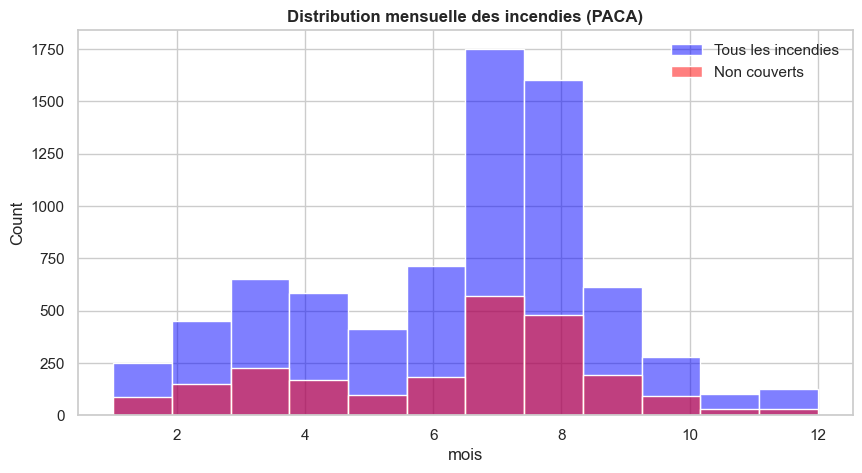

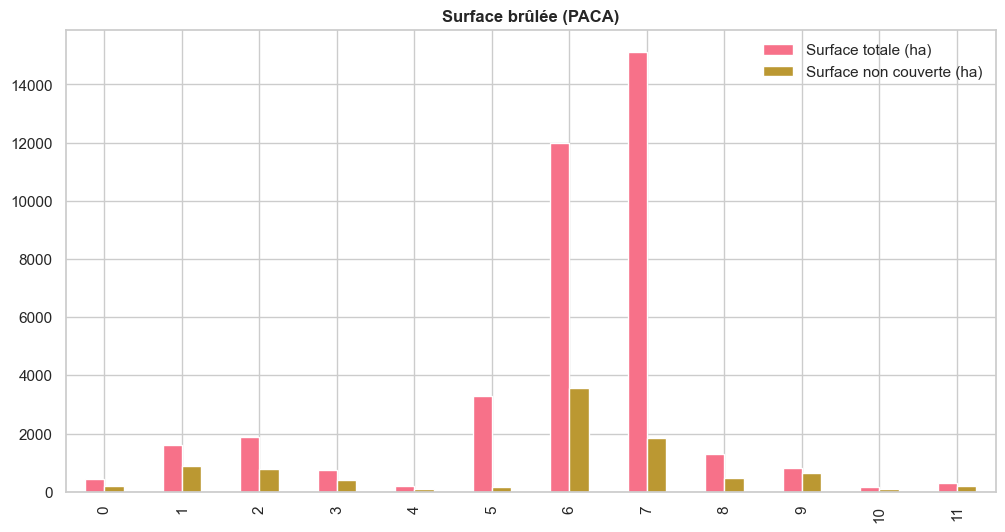


Résultats PACA:
  Region  Incendies totaux  Incendies non couverts  Pourcentage non couvert
0   PACA              7530                    2301                     30.6


In [48]:
# Application aux deux régions
print("\n" + "="*60)
print(" ANALYSE COUVERTURE METEO POUR LA RÉGION PACA ".center(60, "="))
print("="*60)
df_couv_paca, df_surf_paca = analyser_couverture_meteo(df_inc_paca, df_paca, "PACA")
# Affichage des résultats
print("\nRésultats PACA:")
print(df_couv_paca)

### **7.2 Analyse de la couverture météorologique de la Nouvelle-Aquitaine**


===== ANALYSE COUVERTURE METEO POUR LA RÉGION NOUVELLE-AQUITAINE =====

=== Couverture météo - Nouvelle-Aquitaine ===
Incendies non couverts: 3874/6435 (60.2%)


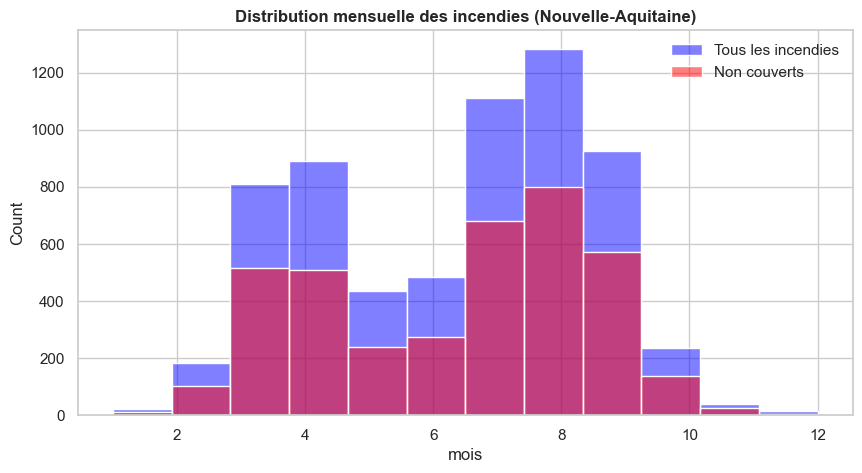

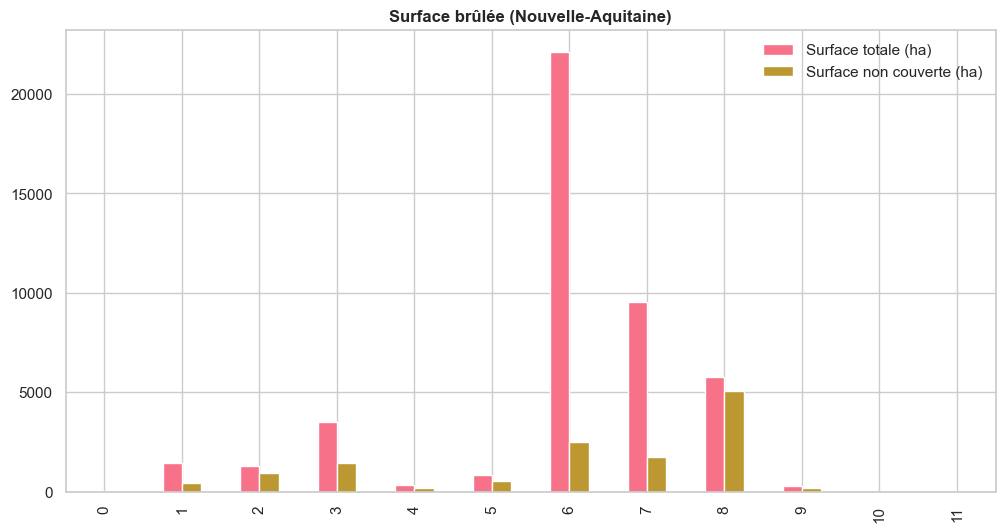


Résultats Nouvelle-Aquitaine:
               Region  Incendies totaux  Incendies non couverts  \
0  Nouvelle-Aquitaine              6435                    3874   

   Pourcentage non couvert  
0                     60.2  


In [49]:
print("\n" + "="*70)
print(" ANALYSE COUVERTURE METEO POUR LA RÉGION NOUVELLE-AQUITAINE ".center(70, "="))
print("="*70)
df_couv_na, df_surf_na = analyser_couverture_meteo(df_inc_na, df_na, "Nouvelle-Aquitaine")
# Affichage des résultats
print("\nRésultats Nouvelle-Aquitaine:")
print(df_couv_na)

### **8. Analyse des valeurs manquantes**

**Objectif :** Identifier les variables contenant des données manquantes dans les fichiers météo régionaux, afin de guider les décisions de nettoyage, d’imputation ou d’exclusion. Cette étape est essentielle pour garantir la fiabilité des analyses statistiques et des visualisations ultérieures.

**Entrées :** 
- **df** : DataFrame météo brut ou prétraité.
- **region** : Nom de la région concernée (ex. "PACA", "Nouvelle-Aquitaine").

**Sorties :** 
- Un tableau listant les variables avec leur pourcentage de valeurs manquantes.
- Un graphique horizontal représentant visuellement ces pourcentages.

In [50]:
def analyser_valeurs_manquantes(df, region):
    """Analyse des valeurs manquantes"""
    # Calcul des valeurs manquantes
    manquantes = df.isnull().mean().sort_values(ascending=False) * 100
    manquantes = manquantes[manquantes > 0]
    
    # Création du DataFrame de résultats
    df_result = pd.DataFrame({
        'Variable': manquantes.index,
        '%_manquant': manquantes.values.round(1)
    })
    
    # Visualisation
    fig, ax = plt.subplots(figsize=(10,6))
    manquantes.plot.barh(ax=ax)
    ax.set_title(f"Valeurs manquantes ({region})")
    ax.set_xlabel("% manquant")
    plt.tight_layout()
    sauvegarder_figure(fig, f"valeurs_manquantes_{region.lower()}", region, show=True)
     
    return df_result


### **8.1 Analyse des valeurs manquantes de la Provence-Alpes-Côte d’Azur**


=====ANALYSE DES VALEURS MANQUANTES POUR LA RÉGION PACA=====


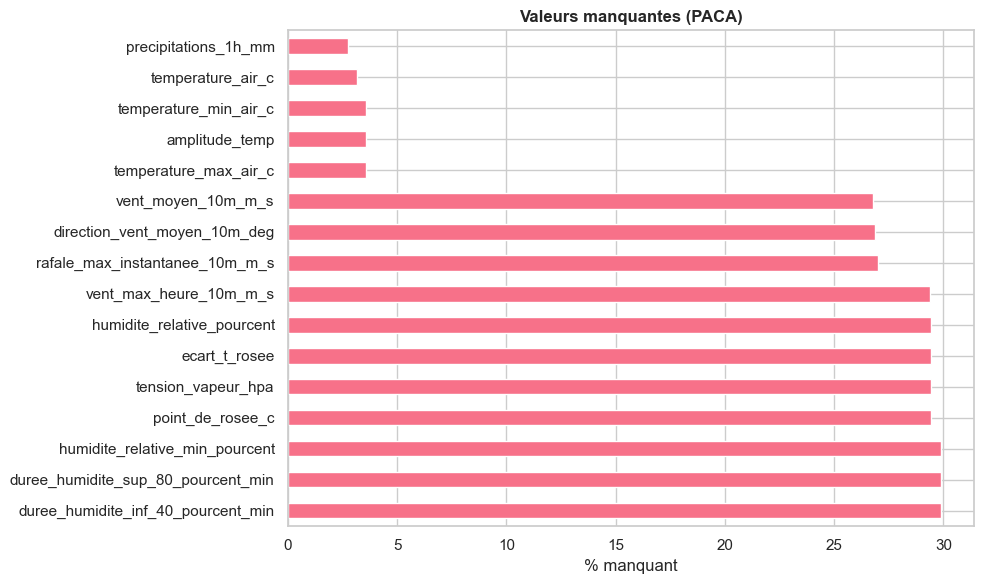


Valeurs manquantes PACA:
                              Variable  %_manquant
0   duree_humidite_inf_40_pourcent_min        29.9
1   duree_humidite_sup_80_pourcent_min        29.9
2       humidite_relative_min_pourcent        29.9
3                     point_de_rosee_c        29.4
4                   tension_vapeur_hpa        29.4
5                        ecart_t_rosee        29.4
6           humidite_relative_pourcent        29.4
7               vent_max_heure_10m_m_s        29.4
8       rafale_max_instantanee_10m_m_s        27.0
9         direction_vent_moyen_10m_deg        26.9
10                  vent_moyen_10m_m_s        26.8
11               temperature_max_air_c         3.6
12                      amplitude_temp         3.6
13               temperature_min_air_c         3.6
14                   temperature_air_c         3.1
15                precipitations_1h_mm         2.7


In [51]:
# Application aux deux régions
print("\n" + "="*60)
print("ANALYSE DES VALEURS MANQUANTES POUR LA RÉGION PACA".center(60, "="))
print("="*60)       

df_manquantes_paca = analyser_valeurs_manquantes(df_paca, "PACA")
# Affichage des résultats
print("\nValeurs manquantes PACA:")
print(df_manquantes_paca)

### **8. Analyse des valeurs manquantes de la Provence-Alpes-Côte d’Azur**


===ANALYSE DES VALEURS MANQUANTES POUR LA RÉGION NOUVELLE-AQUITAINE===


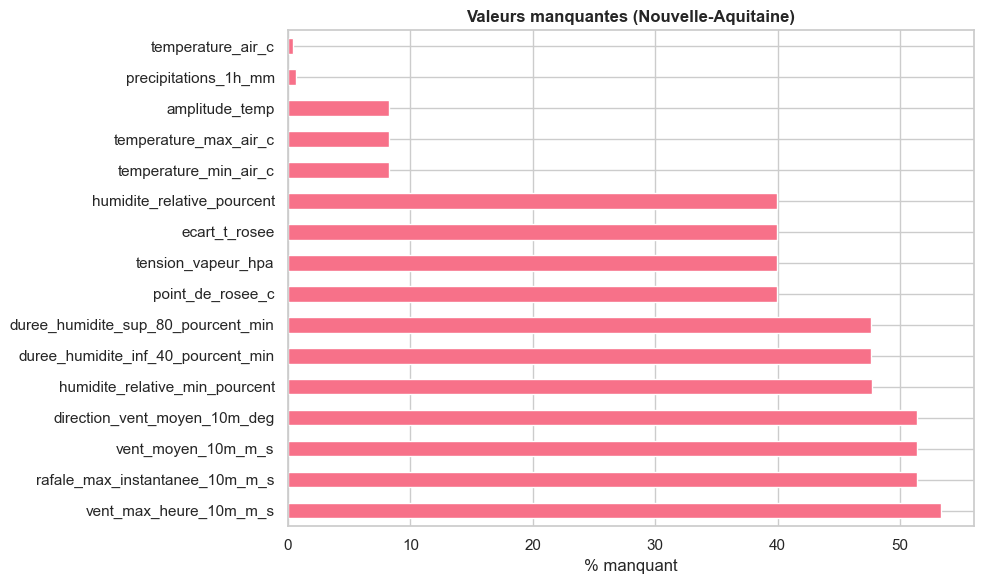


Valeurs manquantes Nouvelle-Aquitaine:
                              Variable  %_manquant
0               vent_max_heure_10m_m_s        53.4
1       rafale_max_instantanee_10m_m_s        51.4
2                   vent_moyen_10m_m_s        51.3
3         direction_vent_moyen_10m_deg        51.3
4       humidite_relative_min_pourcent        47.7
5   duree_humidite_inf_40_pourcent_min        47.6
6   duree_humidite_sup_80_pourcent_min        47.6
7                     point_de_rosee_c        39.9
8                   tension_vapeur_hpa        39.9
9                        ecart_t_rosee        39.9
10          humidite_relative_pourcent        39.9
11               temperature_min_air_c         8.3
12               temperature_max_air_c         8.3
13                      amplitude_temp         8.3
14                precipitations_1h_mm         0.6
15                   temperature_air_c         0.4


In [52]:
print("\n" + "="*70)
print("ANALYSE DES VALEURS MANQUANTES POUR LA RÉGION NOUVELLE-AQUITAINE".center(70, "="))
print("="*70)    
df_manquantes_na = analyser_valeurs_manquantes(df_na, "Nouvelle-Aquitaine")
print("\nValeurs manquantes Nouvelle-Aquitaine:")
print(df_manquantes_na)

### **9. Analyse de la complétude horaire des données météo**
Cette section évalue la qualité temporelle de la couverture des données météorologiques autour des incendies. Elle permet de détecter les manques de données horaires, les incendies mal couverts, ou encore les heures critiques non observées.

**Objectif :**  
- Quantifier le nombre d’heures météo disponibles par incendie.
- Identifier les incendies partiellement ou totalement couverts (sur 24h).
- Vérifier si l’heure d’alerte est incluse dans les heures couvertes.

Étudier la distribution mensuelle, horaire et quotidienne des enregistrements météo.

**Entrées :**
- **df_meteo** : Données météorologiques horaires associées à une région.
- **df_incendies** : Incendies localisés dans la même région, avec leur date et heure d’alerte.
- **region** : Nom de la région étudiée ("PACA" ou "Nouvelle-Aquitaine").

**Sorties :**
- Un tableau statistique récapitulatif de la couverture horaire.
- La distribution du nombre d’heures couvertes par incendie.
- La proportion des incendies dont l’heure d’alerte est effectivement présente dans les données météo.
- Des statistiques temporelles (par mois, heure, jour) sur la volumétrie des enregistrements.

- Deux visualisations principales :
    - Histogramme du nombre d’heures météo disponibles par incendie.
    - Graphique montrant si l’heure d’alerte est couverte (oui/non).
- Trois visualisations complémentaires :
    - Histogramme des enregistrements par mois.
    - Histogramme par heure.
    - Courbe de volume journalier des données.
**Utilité :** 
Cette étape est cruciale pour :
- Filtrer les incendies à analyser (garder ceux avec 24h complètes).
- Vérifier la présence de l’heure d’alerte, indispensable pour certaines analyses ciblées.
- Identifier les périodes ou horaires moins bien couverts, utiles pour ajuster les futures campagnes de collecte ou d’analyse.


In [53]:
def analyser_completude_horaire(df_meteo, df_incendies, region):
    """Analyse la complétude des données météo pour les incendies"""
    print(f"\n=== Analyse pour la région {region} ===\n")
    
    # Copie pour éviter les warnings
    df_meteo = df_meteo.copy()
    df_incendies = df_incendies.copy()

    # Prétraitement
    df_meteo["date_heure"] = pd.to_datetime(df_meteo["date_heure"], errors="coerce")
    df_meteo = df_meteo.dropna(subset=["date_heure"])
    df_meteo["heure"] = df_meteo["date_heure"].dt.hour
    df_meteo["mois"] = df_meteo["date_heure"].dt.month
    df_meteo["date_jour"] = df_meteo["date_heure"].dt.date

    # Couverture horaire
    coverage = df_meteo.groupby("id_incendie")["heure"].nunique()

    stats = {
        "Région": region,
        "Nombre total d'incendies": len(df_incendies["id_incendie"].unique()),
        "Incendies avec données météo": len(coverage),
        "Moyenne d'heures couvertes": coverage.mean(),
        "Médiane d'heures couvertes": coverage.median(),
        "Incendies avec couverture complète (24h)": (coverage == 24).sum(),
        "% couverture complète": (coverage == 24).mean() * 100,
        "Minimum d'heures couvertes": coverage.min(),
        "Maximum d'heures couvertes": coverage.max()
    }

    # Heure d'alerte
    df_incendies["date_alerte"] = pd.to_datetime(df_incendies["date_de_première_alerte"], errors="coerce")
    df_incendies = df_incendies.dropna(subset=["date_alerte"])
    df_incendies["heure_alerte"] = df_incendies["date_alerte"].dt.hour

    heures_disponibles = df_meteo.groupby("id_incendie")["heure"].apply(set).reset_index()
    heures_disponibles.columns = ["id_incendie", "heures_disponibles"]
    df_merged = pd.merge(df_incendies, heures_disponibles, on="id_incendie", how="left")

    df_merged["alerte_couverte"] = df_merged.apply(
        lambda x: x["heure_alerte"] in x["heures_disponibles"]
        if isinstance(x["heures_disponibles"], set) else False,
        axis=1
    )

    alerte_stats = {
        "Incendies avec heure d'alerte couverte": df_merged["alerte_couverte"].sum(),
        "% heure d'alerte couverte": df_merged["alerte_couverte"].mean() * 100,
        "Incendies sans données météo": df_merged["heures_disponibles"].isna().sum()
    }
    stats.update(alerte_stats)

    stats_df = pd.DataFrame([stats])
    print(stats_df.transpose().to_string(header=False))

    # Visualisation principale
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    coverage.plot(kind="hist", bins=24, range=(0, 24), edgecolor='black', align='left', ax=ax1)
    ax1.set_title(f"Distribution des heures couvertes\n{region}")
    ax1.set_xlabel("Nombre d'heures météo disponibles")
    ax1.set_ylabel("Nombre d'incendies")
    ax1.set_xticks(range(0, 25, 2))
    ax1.grid(axis='y', alpha=0.5)

    df_merged["alerte_couverte"].value_counts().plot(kind="bar", rot=0, ax=ax2)
    ax2.set_title(f"Heure d'alerte couverte\n{region}")
    ax2.set_xlabel("Heure d'alerte couverte")
    ax2.set_ylabel("Nombre d'incendies")
    ax2.set_xticks([0, 1])
    ax2.set_xticklabels(["Non couverte", "Couverte"], rotation=45)
    ax2.grid(axis='y', alpha=0.5)

    plt.tight_layout()
    sauvegarder_figure(fig, f"completude_horaire_{region.lower()}", region, show=True)

    # Analyse temporelle
    print(f"\n=== Analyse temporelle pour {region} ===")
    daily_counts = df_meteo.groupby('date_jour').size()
    monthly_counts = df_meteo['mois'].value_counts().sort_index()
    hourly_counts = df_meteo['heure'].value_counts().sort_index()

    temp_stats = {
        "Mois avec plus de données": monthly_counts.idxmax(),
        "Enregistrements max/mois": monthly_counts.max(),
        "Mois avec moins de données": monthly_counts.idxmin(),
        "Enregistrements min/mois": monthly_counts.min(),
        "Heure avec plus de données": hourly_counts.idxmax(),
        "Heure avec moins de données": hourly_counts.idxmin(),
        "Moyenne enregistrements/jour": daily_counts.mean(),
        "Écart-type journalier": daily_counts.std(),
        "Jour avec max d'enregistrements": daily_counts.idxmax(),
        "Jour avec min d'enregistrements": daily_counts.idxmin()
    }

    temp_stats_df = pd.DataFrame([temp_stats])
    print("\nStatistiques temporelles:")
    print(temp_stats_df.transpose().to_string(header=False))

    # Visualisation temporelle
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18, 12))

    monthly_counts.plot(kind='bar', color='tab:orange', edgecolor='black', ax=ax1)
    ax1.set_title(f"Distribution mensuelle des enregistrements météo\n{region}")
    ax1.set_xlabel("Mois")
    ax1.set_ylabel("Nombre d'enregistrements")
    ax1.set_xticks(range(1, 13))
    ax1.set_xticklabels([calendar.month_abbr[i] for i in range(1, 13)], rotation=0)
    ax1.grid(axis='y', alpha=0.3)

    hourly_counts.plot(kind='bar', color='tab:blue', edgecolor='black', ax=ax2)
    ax2.set_title(f"Distribution horaire des enregistrements\n{region}")
    ax2.set_xlabel("Heure")
    ax2.set_ylabel("Nombre d'enregistrements")
    ax2.set_xticks(range(0, 24))
    ax2.tick_params(axis='x', rotation=0)
    ax2.grid(axis='y', alpha=0.3)

    daily_counts.plot(kind='line', color='tab:green', linewidth=1, ax=ax3)
    ax3.set_title(f"Volume quotidien d'enregistrements météo\n{region}")
    ax3.set_xlabel("Date")
    ax3.set_ylabel("Enregistrements par jour")
    ax3.grid(alpha=0.3)

    plt.tight_layout()
    sauvegarder_figure(fig, f"statistiques_temporelles_{region.lower()}", region, show=True)

    return stats_df, coverage, df_merged["alerte_couverte"], temp_stats_df

### **9.1. Analyse de la complétude horaire des données météo de la Provence-Alpes-Côte d’Azur**


=========== ANALYSE COMPLETUDE HORAIRE============

=== Analyse pour la région PACA ===

Région                                    PACA
Nombre total d'incendies                  7383
Incendies avec données météo              5134
Moyenne d'heures couvertes                22.2
Médiane d'heures couvertes                24.0
Incendies avec couverture complète (24h)  4246
% couverture complète                     82.7
Minimum d'heures couvertes                   1
Maximum d'heures couvertes                  24
Incendies avec heure d'alerte couverte    5161
% heure d'alerte couverte                 68.5
Incendies sans données météo              2301


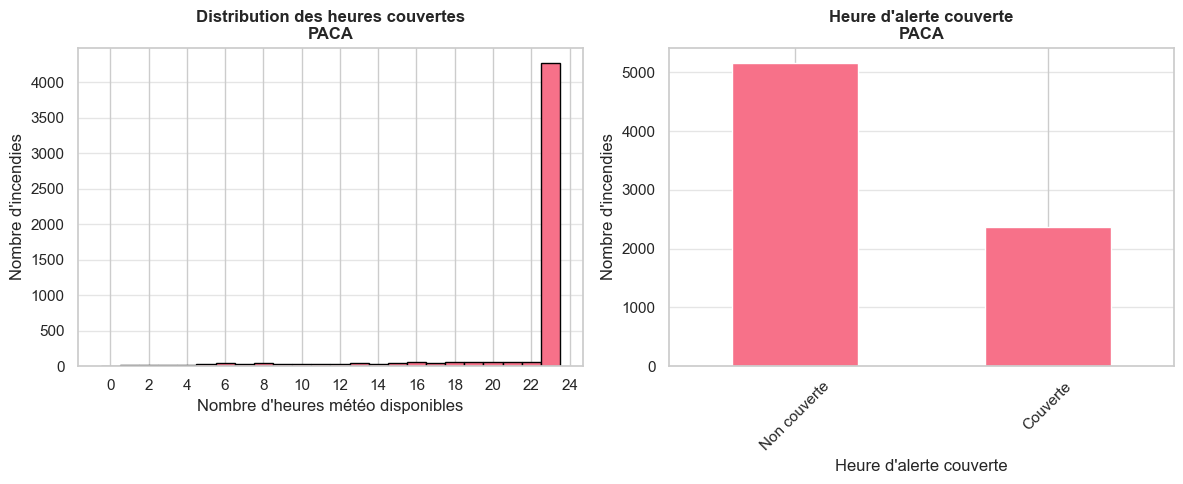


=== Analyse temporelle pour PACA ===

Statistiques temporelles:
Mois avec plus de données                 7
Enregistrements max/mois              25415
Mois avec moins de données               11
Enregistrements min/mois               1608
Heure avec plus de données                6
Heure avec moins de données              14
Moyenne enregistrements/jour           50.5
Écart-type journalier                  37.2
Jour avec max d'enregistrements  2023-07-25
Jour avec min d'enregistrements  2017-01-28


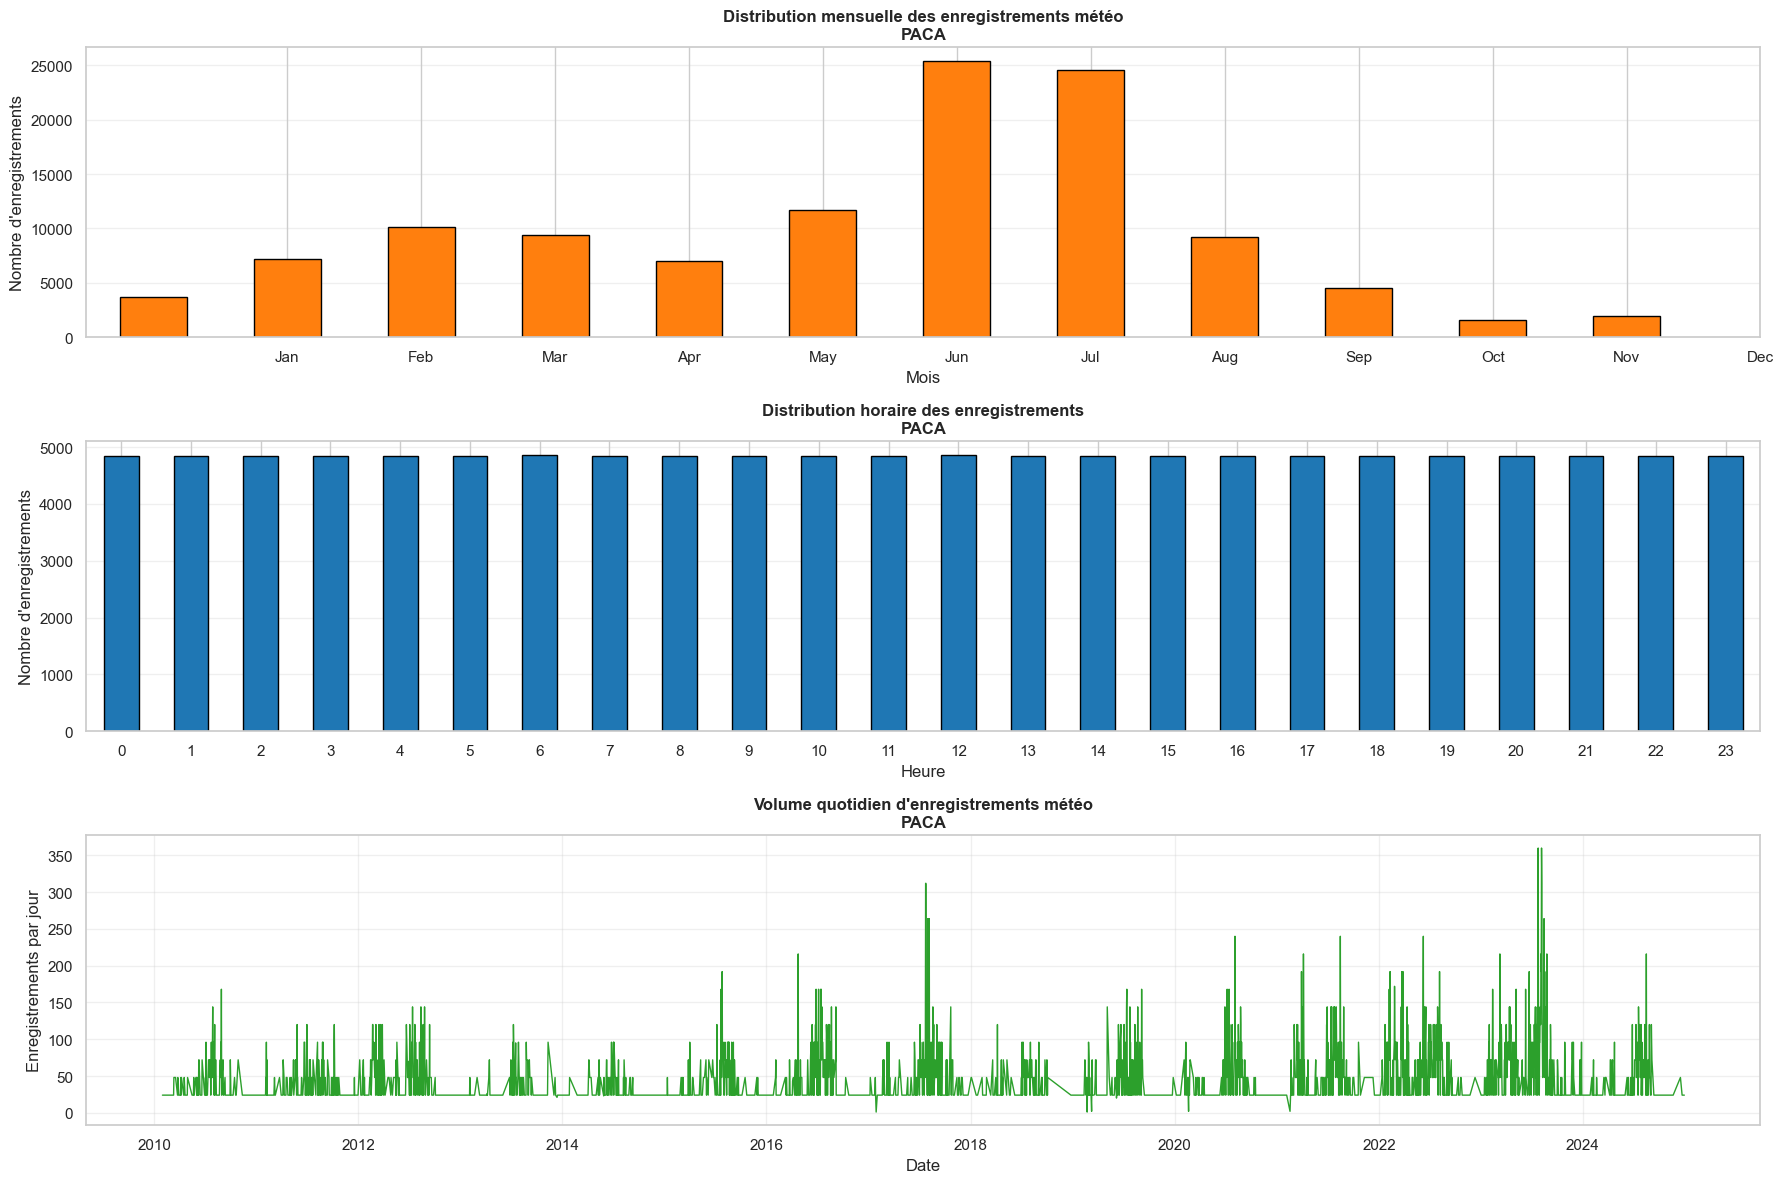

In [54]:
# Application aux deux régions
print("\n" + "="*50)
print(" ANALYSE COMPLETUDE HORAIRE".center(50, "="))
print("="*50)       

stats_paca, coverage_paca, alerte_paca, temp_paca = analyser_completude_horaire(df_paca, df_inc_paca, "PACA")

### **9.2. Analyse de la complétude horaire des données météo de la Provence-Alpes-Côte d’Azur**


=========== ANALYSE COMPLETUDE HORAIRE============

=== Analyse pour la région Nouvelle-Aquitaine ===

Région                                    Nouvelle-Aquitaine
Nombre total d'incendies                                6355
Incendies avec données météo                            2535
Moyenne d'heures couvertes                              22.2
Médiane d'heures couvertes                              24.0
Incendies avec couverture complète (24h)                2105
% couverture complète                                   83.0
Minimum d'heures couvertes                                 1
Maximum d'heures couvertes                                24
Incendies avec heure d'alerte couverte                  2513
% heure d'alerte couverte                               39.1
Incendies sans données météo                            3874


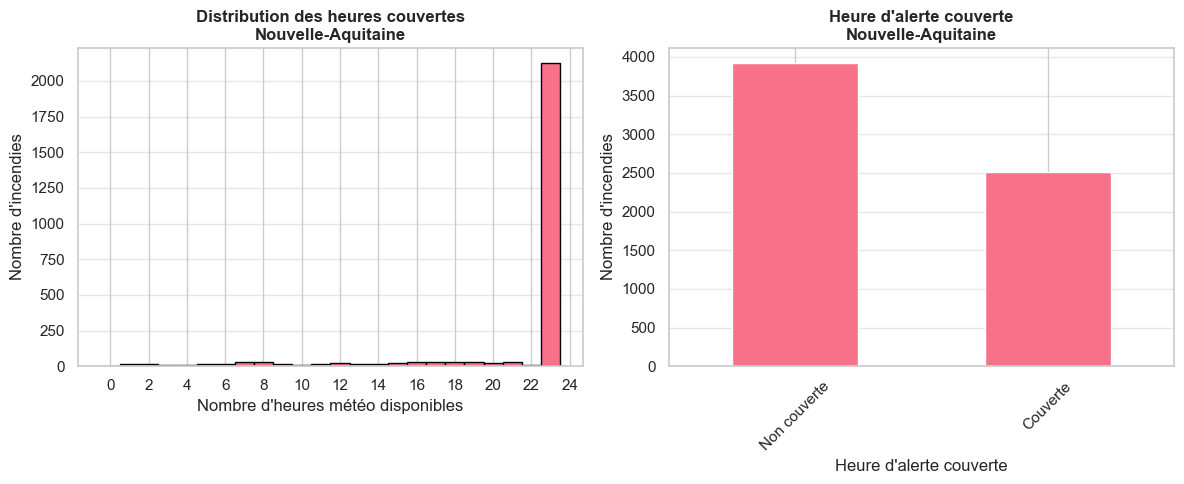


=== Analyse temporelle pour Nouvelle-Aquitaine ===

Statistiques temporelles:
Mois avec plus de données                 8
Enregistrements max/mois              10447
Mois avec moins de données               12
Enregistrements min/mois                192
Heure avec plus de données                6
Heure avec moins de données               0
Moyenne enregistrements/jour           41.6
Écart-type journalier                  27.9
Jour avec max d'enregistrements  2011-07-03
Jour avec min d'enregistrements  2023-02-17


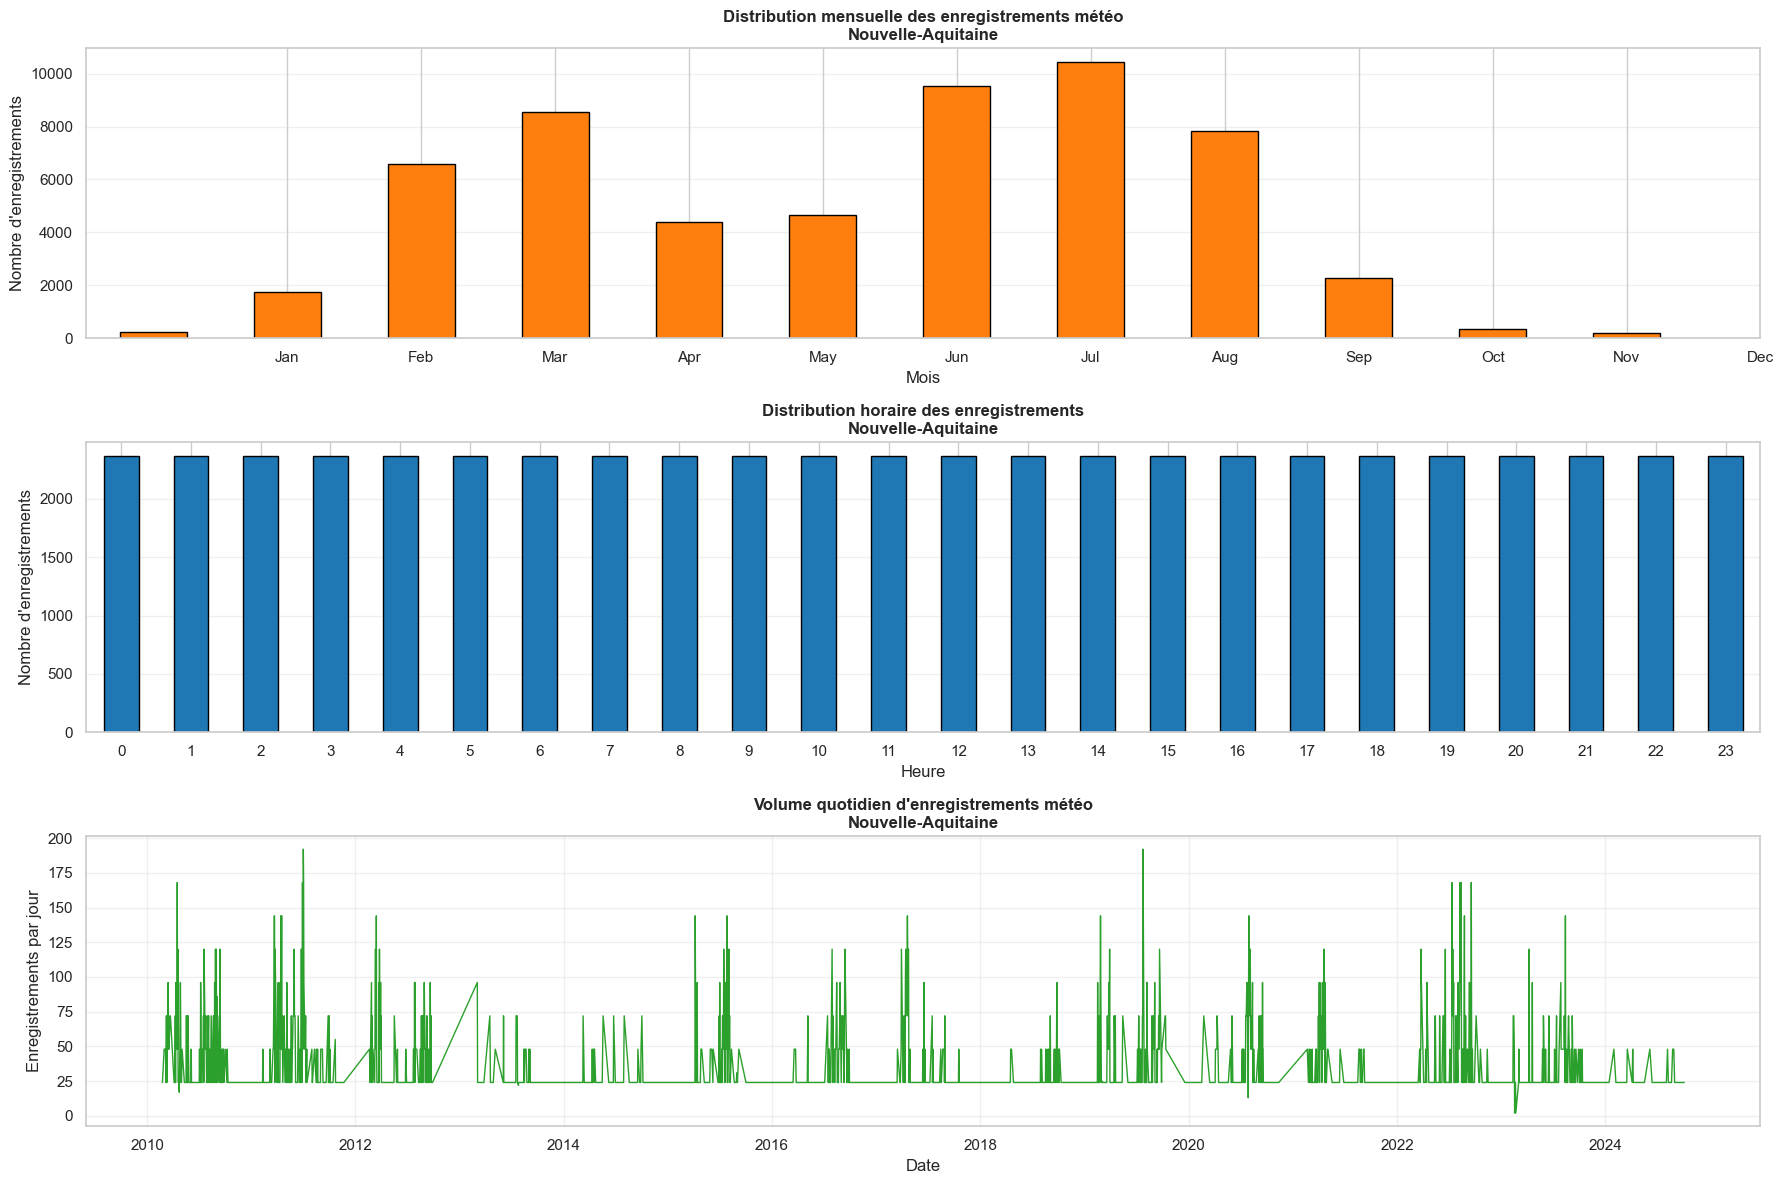

In [55]:
# Application aux deux régions
print("\n" + "="*50)
print(" ANALYSE COMPLETUDE HORAIRE".center(50, "="))
print("="*50) 
stats_na, coverage_na, alerte_na, temp_na = analyser_completude_horaire(df_na, df_inc_na, "Nouvelle-Aquitaine")

### **Synthèse de la Qualité et de la Complétude des Données : Vers une Stratégie de Modélisation Adaptée**

L'évaluation approfondie de la qualité des données météorologiques disponibles pour les régions PACA et Nouvelle-Aquitaine est une étape fondamentale qui conditionne l'ensemble de notre démarche de modélisation. En passant d'une analyse générale des valeurs manquantes à une étude fine de la complétude horaire, nous pouvons non seulement confirmer nos hypothèses initiales, mais aussi définir une stratégie de modélisation rigoureuse et adaptée aux spécificités de chaque territoire.

#### **a. Du Constat Global à la Réalité Opérationnelle**

Notre première phase d'analyse (01_preprocess_meteo_france) avait déjà mis en lumière une disparité de qualité notable, avec un déficit de couverture critique en Nouvelle-Aquitaine, notamment sur les variables clés de vent et d'humidité. L'analyse de la complétude horaire vient aujourd'hui quantifier l'impact concret de ce constat :

- En Nouvelle-Aquitaine, le diagnostic se confirme et s'aggrave : **61%** des incendies n'ont aucune donnée météo associée.
- En PACA, la situation est nettement plus favorable, avec "seulement" **30.6%** des incendies non couverts.

Cette différence fondamentale valide notre décision stratégique initiale : la PACA possède une base de données suffisamment riche pour servir de socle à notre analyse, tandis que la Nouvelle-Aquitaine représente un défi qui nécessite une approche plus prudente.

#### **b. L'Heure de l'Alerte : Le Juge de Paix de la Qualité des Données**

L'analyse de la complétude horaire affine ce diagnostic en se concentrant sur l'indicateur le plus crucial pour la modélisation des départs de feu : la disponibilité des données à l'heure précise de l'alerte. C'est ici que les deux régions révèlent leur plein potentiel et leurs limites :

- La PACA s'impose comme une base de données de référence. Avec **68.5%** des heures d'alerte couvertes, nous disposons d'un volume de données conséquent et de haute qualité pour analyser avec précision les conditions de déclenchement des feux. C'est un atout majeur qui nous permet d'envisager une modélisation avancée avec un haut degré de confiance.
  
- La Nouvelle-Aquitaine présente un double visage. Le faible taux de couverture de l'heure d'alerte (**39.1%**) est un handicap sévère qui interdit toute généralisation hâtive. Cependant, il serait erroné de rejeter ce jeu de données. Il met à notre disposition un "laboratoire" de plus de **2000 incendies** parfaitement documentés sur 24 heures. Ce "cœur de données" de haute qualité, bien que minoritaire, est une opportunité précieuse pour étudier la dynamique des feux dans un contexte climatique différent.

#### **c. Conclusion : Une Stratégie de Modélisation Duale et Justifiée**

En fusionnant ces niveaux d'analyse, nous aboutissons à une stratégie de modélisation claire, pragmatique et justifiée par les données elles-mêmes :

- **Développer, Entraîner et Valider sur la PACA** : La robustesse, le volume et la haute qualité de la couverture horaire en PACA en font le terrain idéal pour construire notre modèle de risque principal. C'est ici que nous apprendrons et validerons les relations fondamentales entre les variables météorologiques et le risque incendie.
  
- **Tester, Adapter et Nuancer avec la Nouvelle-Aquitaine** : Le "cœur de données" de la Nouvelle-Aquitaine sera utilisé comme un cas d'étude essentiel. Il nous permettra de tester la capacité de notre modèle à se généraliser à un autre climat et à une autre typologie de végétation. Il nous forcera à identifier les paramètres universels du risque et ceux qui nécessitent un ajustement régional.

En conclusion, cette analyse approfondie de la qualité des données ne nous conduit pas à une impasse, mais à une approche complémentaire et rigoureuse. Elle nous permet d'exploiter chaque jeu de données à son plein potentiel, en étant pleinement conscients de ses forces et de ses limites, et de construire ainsi une démarche de modélisation la plus robuste et pertinente possible.

---

### **10. Filtrage des Données Météorologiques**

**Objectif :** Sélectionner uniquement les incendies disposant d'une couverture météorologique suffisante, afin d’assurer la qualité statistique des analyses.

**Méthodologie :** 

Pour chaque incendie et chaque jour, on calcule le nombre d’heures couvertes par les données météo. Les incendies retenus sont ceux pour lesquels au moins 20 heures de données sont disponibles sur la journée concernée.

**Résultat :**

Ce filtrage permet de travailler uniquement sur des échantillons d’incendies bien documentés sur le plan météorologique, garantissant la robustesse des analyses suivantes.

In [56]:
def filtrer_donnees_completes(meteo_df: pd.DataFrame, heures_min: int = 20) -> pd.DataFrame:
    """Filtrage des incendies avec couverture météo complète"""
    couverture = meteo_df.groupby(["id_incendie", "date"]).size().reset_index(name="heures")
    bien_couverts = couverture[couverture["heures"] >= heures_min]["id_incendie"].unique()
    return meteo_df[meteo_df["id_incendie"].isin(bien_couverts)].copy()

df_paca_filtre = filtrer_donnees_completes(df_paca)
df_na_filtre = filtrer_donnees_completes(df_na)

### **11. Analyse des Températures**
Cette section propose une analyse détaillée des températures relevées autour des incendies dans la région sélectionnée. L’objectif est de mieux comprendre les variations thermiques journalières, mensuelles et annuelles, ainsi que les situations potentiellement extrêmes.

**Objectifs :**
- Obtenir des **statistiques descriptives des températures moyennes, maximales et minimales.
- Identifier les épisodes de forte chaleur (T° > 30°C).
- Évaluer l'amplitude thermique journalière moyenne.
- Visualiser :
    - la distribution mensuelle des températures (boxplot),
    - l’évolution annuelle de la température moyenne,
    - le profil horaire typique des températures,
    - les amplitudes thermiques mensuelles.

**Entrées :**
- meteo_df : DataFrame contenant les données météo liées aux incendies.

- nom_region : Nom de la région à analyser (pour les titres et l’enregistrement des graphiques).

**Sorties :**
- Un dictionnaire contenant :

    - **statistiques_descriptives :** statistiques classiques (moyenne, min, max, etc.)
    - **metriques_cles :** indicateurs spécifiques (nombre de jours > 30°C, amplitude thermique moyenne).
- Une figure Matplotlib contenant 4 sous-graphiques illustrant les résultats.

**Visualisations produites :**
1. **Boxplot mensuel des températures :** repère les mois les plus chauds.
2. **Amplitude thermique moyenne par mois :** évalue la variabilité jour/nuit.
3. **Évolution annuelle :** tendance interannuelle des températures.
4. **Profil horaire moyen :** comportement journalier moyen de la température.

In [57]:
# Fonctions d'analyse météorologiques
def analyser_temperatures(meteo_df: pd.DataFrame, nom_region: str) -> Tuple[Dict[str, pd.DataFrame], plt.Figure]:
    """Analyse des températures"""
    stats_df = meteo_df[["temperature_air_c", "temperature_max_air_c", "temperature_min_air_c"]].describe().round(1)
    
    metrics = {}
    if "amplitude_temp" in meteo_df.columns:
        metrics["Amplitude thermique moyenne (°C)"] = meteo_df["amplitude_temp"].mean()
    if "date" in meteo_df.columns:
        jours_chauds = meteo_df.groupby("date")["temperature_air_c"].max()
        metrics["Jours avec T° > 30°C"] = (jours_chauds > 30).sum()
        metrics["Fréquence jours > 30°C (%)"] = (jours_chauds > 30).mean() * 100
    metrics_df = pd.DataFrame.from_dict(metrics, orient="index", columns=["Valeur"]).round(1)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f"Analyse des Températures - {nom_region}", fontweight="bold")
    
    sns.boxplot(ax=axes[0, 0], x="mois", y="temperature_air_c", data=meteo_df, color="crimson")
    axes[0, 0].set_xticks(range(1, 13))
    axes[0, 0].set_xticklabels([calendar.month_abbr[i] for i in range(1, 13)])

    if "amplitude_temp" in meteo_df.columns:
        meteo_df.groupby("mois")["amplitude_temp"].mean().plot(kind="bar", ax=axes[0, 1], color="darkorange")
        axes[0, 1].set_title("Amplitude Thermique Moyenne par Mois")
        axes[0, 1].set_xticks(range(1, 13))
        axes[0, 1].set_xticklabels([calendar.month_abbr[i] for i in range(1, 13)], rotation=45)

    sns.lineplot(ax=axes[1, 0], x="annee", y="temperature_air_c", data=meteo_df, estimator="mean", errorbar=None, marker='o', color="forestgreen")
    axes[1, 0].set_title("Évolution Annuelle de la Température Moyenne")
    axes[1, 0].grid(True, which='both', linestyle='--')

    sns.lineplot(ax=axes[1, 1], x="heure", y="temperature_air_c", data=meteo_df, estimator="mean", errorbar=None, color="purple")
    axes[1, 1].set_title("Profil Horaire Moyen des Températures")
    axes[1, 1].grid(True, which='both', linestyle='--')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    sauvegarder_figure(fig, f"analyse_temperatures_{nom_region.lower()}", nom_region, show=True)
        
    return {"statistiques_descriptives": stats_df, "metriques_cles": metrics_df}, fig

### **11.1. Analyse des Températures de la Provence-Alpes-Côte d’Azur**


==== ANALYSE TEMPERATURES POUR LA RÉGION PACA=====


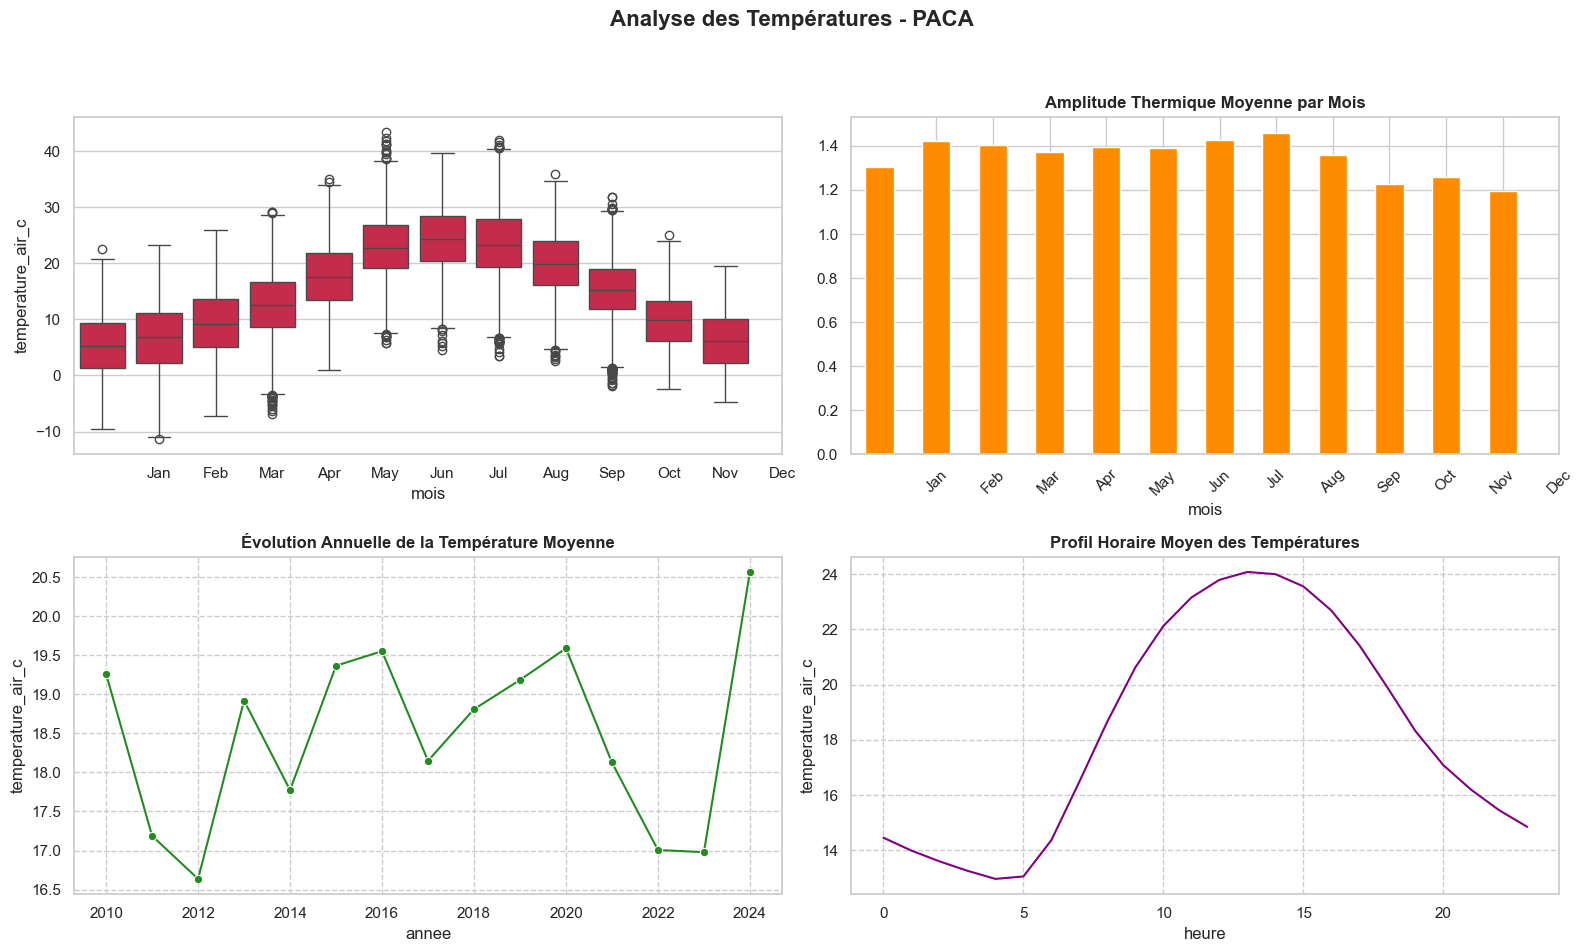


Résultats PACA:
       temperature_air_c  temperature_max_air_c  temperature_min_air_c
count           104864.0               104375.0               104377.0
mean                18.2                   19.0                   17.6
std                  8.7                    8.7                    8.6
min                -11.3                  -10.8                  -11.9
25%                 12.4                   13.2                   11.8
50%                 19.1                   19.8                   18.5
75%                 24.7                   25.5                   23.9
max                 43.4                   44.3                   42.4


In [58]:
print("\n" + "="*50)
print(" ANALYSE TEMPERATURES POUR LA RÉGION PACA".center(50, "="))
print("="*50)       
resultats_temp_paca, fig_temp_paca = analyser_temperatures(df_paca_filtre, "PACA")
# Affichage des résultats
print("\nRésultats PACA:")
print(resultats_temp_paca["statistiques_descriptives"])

L'analyse des variables de température pour la région PACA dresse le portrait d'un climat de type méditerranéen, caractérisé par une forte saisonnalité et des extrêmes notables, qui sont des facteurs clés dans l'analyse du risque incendie.

#### a. Caractéristiques Générales et Variabilité

Les statistiques descriptives révèlent une température horaire moyenne de **18.2°C** sur l'ensemble de la période. Cependant, cette moyenne masque une très grande variabilité, comme en témoigne l'écart-type élevé de **8.7°C**. Cette dispersion est typique d'une région connaissant des saisons très contrastées.

La plage de températures enregistrées est particulièrement large, s'étendant d'un minimum hivernal de **-11.3°C** à un pic estival extrême de **43.4°C**. Cette amplitude de plus de **50°C** souligne l'exposition de la région à des conditions météorologiques très diverses, allant du gel à des vagues de chaleur intense.

#### b. Profil des Températures et Risque Incendie

Les quartiles permettent de mieux cerner les conditions habituelles :
- **50%** des relevés se situent dans une fourchette modérée entre **12.4°C** et **24.7°C**.
- La médiane à **19.1°C** indique que la moitié du temps, les températures sont relativement élevées.
- Le quartile supérieur (75%) à **24.7°C** montre que des conditions de chaleur propices aux incendies (températures élevées qui assèchent la végétation) sont fréquentes, survenant dans au moins un quart des relevés.

La température maximale enregistrée de **44.3°C** est un indicateur clair du potentiel de la région à atteindre des niveaux de chaleur extrêmes. Ces journées de canicule sont particulièrement critiques car elles créent des conditions hautement favorables à l'éclosion et à la propagation rapide des feux.

#### c. Implications pour la Modélisation

Cette analyse confirme que la température est une variable fondamentale et très dynamique pour la modélisation du risque en PACA. La forte variabilité saisonnière et journalière, ainsi que la survenue d'événements extrêmes, devront être intégrées avec précision dans les modèles. L'étude de seuils critiques (par exemple, le nombre de jours où la température dépasse **30°C** ou **35°C**) sera particulièrement pertinente pour affiner l'évaluation du danger.

#### Conclusion

En conclusion, les données de température pour la région PACA sont riches et révèlent des conditions climatiques qui expliquent en grande partie la sensibilité de ce territoire au risque incendie.


### **11.2. Analyse des Températures de la Nouvelle-Aquitaine**


== ANALYSE TEMPERATURES POUR LA RÉGION NOUVELLE-AQUITAINE===


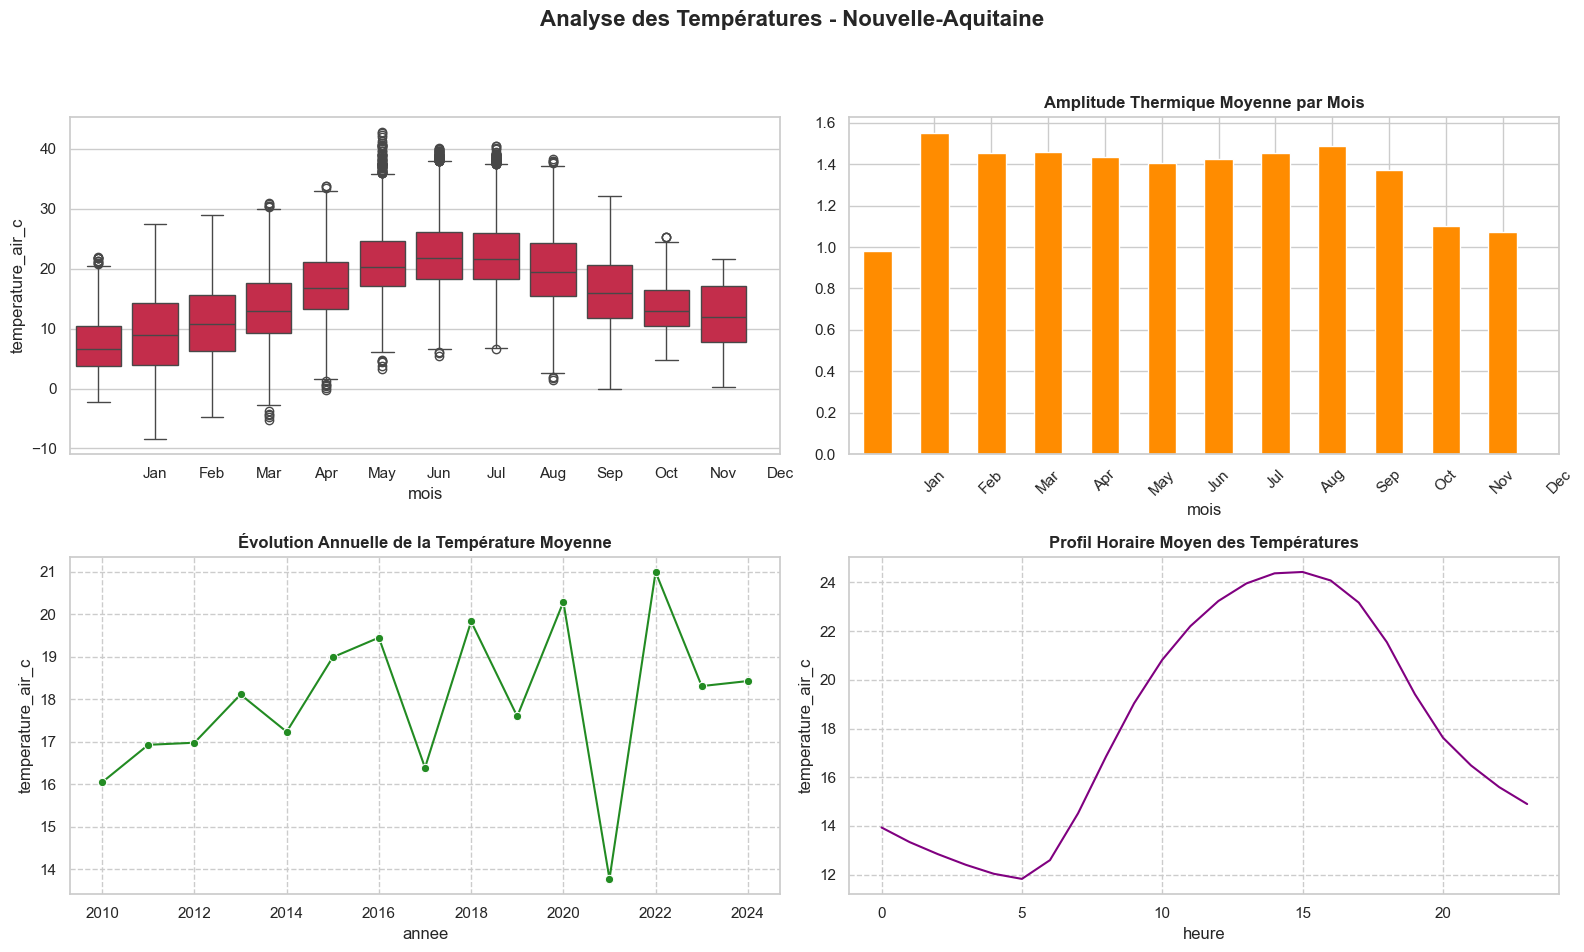


Résultats Nouvelle-Aquitaine:
       temperature_air_c  temperature_max_air_c  temperature_min_air_c
count            52454.0                48313.0                48313.0
mean                17.9                   18.7                   17.2
std                  7.5                    7.6                    7.4
min                 -8.4                   -7.5                   -8.7
25%                 13.0                   13.6                   12.3
50%                 18.2                   18.8                   17.5
75%                 22.9                   23.7                   22.0
max                 42.8                   43.4                   42.5


In [59]:
print("\n" + "="*60)
print(" ANALYSE TEMPERATURES POUR LA RÉGION NOUVELLE-AQUITAINE".center(60, "="))
print("="*60)   

resultats_temp_na, fig_temp_na = analyser_temperatures(df_na_filtre, "Nouvelle-Aquitaine")
# Affichage des résultats
print("\nRésultats Nouvelle-Aquitaine:")
print(resultats_temp_na["statistiques_descriptives"])

L'analyse des températures en Nouvelle-Aquitaine dresse le portrait d'un climat tempéré, mais qui est clairement sujet à des vagues de chaleur estivales intenses et à une tendance de fond au réchauffement. Ces deux éléments sont des facteurs déterminants qui expliquent la vulnérabilité de la région au risque incendie.

#### **a. Un Climat Tempéré aux Extrêmes Estivaux Marqués**

Les statistiques descriptives indiquent une température moyenne annuelle de **17.9°C**, mais cette valeur masque une forte saisonnalité visible sur les graphiques :

- **Saisonnalité** : Le boxplot mensuel illustre parfaitement le cycle des saisons, avec des hivers doux et des étés chauds. La période de mai à août se distingue par des températures médianes élevées et, surtout, par la présence de nombreuses valeurs extrêmes ("outliers") dépassant les **35°C**, voire **40°C**. Ces pics de chaleur sont des déclencheurs critiques pour les incendies, car ils assèchent très rapidement la végétation.
  
- **Amplitude thermique** : L'amplitude thermique moyenne mensuelle (graphique en barres orange) est relativement stable, mais elle est maximale en été, indiquant des journées où l'écart entre les minimales nocturnes et les maximales diurnes est le plus grand, contribuant au stress hydrique des plantes.

#### **b. Le Profil Horaire : Identifier le Pic de Danger Journalier**

Le graphique du **Profil Horaire Moyen** est un outil essentiel. Il montre que la température atteint son maximum journalier en milieu d'après-midi, entre **15h et 17h**. C'est la "fenêtre de danger" quotidienne, où le risque d'éclosion d'un feu et sa vitesse de propagation sont à leur paroxysme, en raison de la combinaison de la chaleur maximale et de l'humidité la plus basse (comme vu dans les analyses de corrélation).

#### **c. Une Tendance de Fond Inquiétante : le Réchauffement Climatique**

Le graphique de l'**Évolution Annuelle de la Température Moyenne** est peut-être le plus alarmant. Malgré une forte variabilité d'une année sur l'autre, il révèle une tendance de fond à la hausse des températures moyennes sur la dernière décennie. Des années particulièrement chaudes comme **2018**, **2020** et surtout le pic de **2022** se détachent nettement. Cette tendance structurelle au réchauffement signifie que les conditions propices aux incendies deviennent statistiquement plus fréquentes et plus intenses au fil du temps.

#### **Conclusion**

En conclusion, l'analyse des températures pour la Nouvelle-Aquitaine est riche d'enseignements. Elle montre que le risque incendie dans cette région n'est pas seulement lié à des conditions moyennes, mais est fortement piloté par :

- La survenue de **pics de chaleur extrêmes** durant la saison estivale.
- Le **cycle journalier** qui concentre le danger en milieu d'après-midi.
- Une **tendance structurelle au réchauffement** qui aggrave ces conditions d'année en année.

La modélisation du risque devra donc impérativement intégrer ces trois dimensions temporelles (saisonnière, journalière et interannuelle) pour être véritablement pertinente et efficace.

### **12. Analyse de l'Humidité Relative**
Cette section explore le rôle de l’humidité relative dans le contexte des incendies. Une humidité faible est souvent associée à une végétation plus sèche et à un risque accru de propagation des feux.

**Objectifs :**
- Décrire statistiquement l’humidité relative moyenne et minimale.
- Quantifier les situations de sécheresse atmosphérique (HR < 40 %, voire < 30 %).
- Analyser la distribution globale de l’humidité.
- Étudier la relation entre température et humidité relative.

**Entrées :**
- meteo_df : Données météorologiques contenant les mesures d’humidité.
- nom_region : Nom de la région analysée (affiché dans les titres et utilisé pour la sauvegarde).

**Sorties :**
- Un dictionnaire contenant :
    - **statistiques_descriptives :** résumé statistique de l’humidité (moyenne, min, max...).
    - analyse_seuils_critiques : métriques liées aux seuils critiques de sécheresse.
    - Une figure avec deux sous-graphiques visuels.

**Visualisations produites :**

**1. Histogramme de l’humidité relative :**  permet d’identifier la fréquence des situations sèches (< 30 %, < 40 %).

**2.Nuage de points Température vs. Humidité :** visualise la corrélation entre température et humidité, avec régression.

**Indicateurs clés calculés :**
- Nombre d’heures avec HR < 40 % (sécheresse modérée).
- Nombre d’heures avec HR < 30 % (sécheresse forte).
- Fréquences relatives de ces seuils (% du total).

In [60]:
def analyser_humidite(meteo_df: pd.DataFrame, nom_region: str) -> Tuple[Dict[str, pd.DataFrame], plt.Figure]:
    """Analyse de l'humidité relative"""
    stats_df = meteo_df[["humidite_relative_pourcent", "humidite_relative_min_pourcent"]].describe().round(1)
    
    metrics = {
        "Heures avec HR < 40% (sèches)": (meteo_df["humidite_relative_pourcent"] < 40).sum(),
        "Fréquence HR < 40% (%)": (meteo_df["humidite_relative_pourcent"] < 40).mean() * 100,
        "Heures avec HR < 30% (très sèches)": (meteo_df["humidite_relative_pourcent"] < 30).sum(),
        "Fréquence HR < 30% (%)": (meteo_df["humidite_relative_pourcent"] < 30).mean() * 100,
    }
    metrics_df = pd.DataFrame.from_dict(metrics, orient="index", columns=["Valeur"]).round(1)

    fig = plt.figure(figsize=(16, 6))
    fig.suptitle(f"Analyse de l'Humidité Relative - {nom_region}", fontweight="bold")

    ax1 = fig.add_subplot(1, 2, 1)
    sns.histplot(meteo_df["humidite_relative_pourcent"].dropna(), bins=40, kde=True, color="teal", ax=ax1)
    ax1.set_title("Distribution de l'Humidité Relative")
    ax1.axvline(x=30, color='red', linestyle='--', label='Seuil critique (30%)')
    ax1.legend()

    ax2 = fig.add_subplot(1, 2, 2)
    sample_size = min(5000, len(meteo_df))
    if sample_size > 0:
        sns.regplot(x="temperature_air_c", y="humidite_relative_pourcent", 
                   data=meteo_df.sample(sample_size), 
                   scatter_kws={'alpha':0.2, 'color':'purple'}, 
                   line_kws={'color':'red'}, ax=ax2)
    ax2.set_title("Relation Température vs. Humidité")
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    sauvegarder_figure(fig, f"analyse_humidite_{nom_region.lower()}", nom_region, show=True)
        
    return {"statistiques_descriptives": stats_df, "analyse_seuils_critiques": metrics_df}, fig

### **12.1. Analyse de l'Humidité Relative de la Provence-Alpes-Côte d’Azur**


====== ANALYSE HUMIDITE POUR LA RÉGION PACA=======


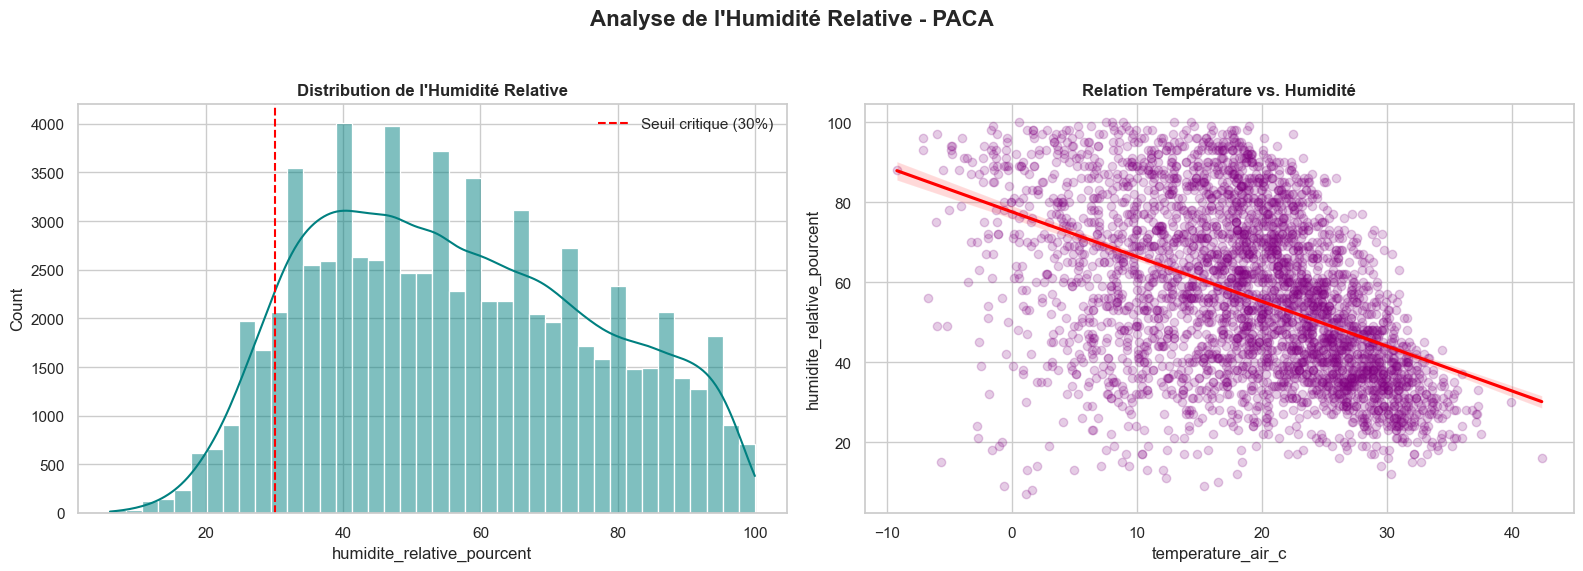


Résultats PACA:
       humidite_relative_pourcent  humidite_relative_min_pourcent
count                     75704.0                         75168.0
mean                         56.4                            53.3
std                          20.5                            20.3
min                           6.0                             6.0
25%                          40.0                            37.0
50%                          55.0                            51.0
75%                          72.0                            68.0
max                         100.0                           100.0


In [61]:
print("\n" + "="*50)
print(" ANALYSE HUMIDITE POUR LA RÉGION PACA".center(50, "="))
print("="*50)       
resultats_hum_paca, fig_hum_paca = analyser_humidite(df_paca_filtre, "PACA")
# Affichage des résultats
print("\nRésultats PACA:")
print(resultats_hum_paca["statistiques_descriptives"])

L'analyse de l'humidité relative en région PACA met en évidence le rôle crucial de ce paramètre dans la création de conditions propices aux incendies. L'air sec, en particulier, apparaît comme un facteur de risque prépondérant.

#### a. Un climat sujet à l'assèchement de l'air

Avec une humidité relative moyenne de **56.4%**, le climat peut sembler modéré. Cependant, les statistiques descriptives et la distribution révèlent une réalité plus complexe :
- Le premier quartile (25%) se situe à **40%**, ce qui signifie qu'un quart du temps, l'air est déjà considéré comme sec et favorable à la propagation des feux.
- La distribution (histogramme) est large et étalée, avec une proportion très importante de relevés en dessous de **50%**. Le pic de la distribution se situe autour de **40-50%**, confirmant que les conditions d'air sec ne sont pas des exceptions mais une composante structurelle du climat local.
- Des valeurs minimales extrêmement basses (jusqu'à **6%**) sont enregistrées, témoignant de la capacité de la région à connaître des épisodes de sécheresse atmosphérique très sévère, où la végétation peut se déshydrater rapidement.

#### b. La relation inverse et critique avec la température

Le graphique de dispersion "Relation Température vs. Humidité" est particulièrement éloquent. Il illustre une corrélation négative forte et claire : lorsque la température augmente, l'humidité relative a tendance à chuter de manière significative.

Cette relation est au cœur du risque incendie : les journées les plus chaudes sont aussi, mécaniquement, les plus sèches. Cette combinaison explosive (chaleur intense + air très sec) crée un environnement où la végétation est extrêmement inflammable et où un départ de feu peut très rapidement devenir incontrôlable.

#### c. Le franchissement fréquent du seuil critique

Le seuil de **30%** d'humidité relative est souvent considéré comme un niveau critique en dessous duquel le risque d'incendie devient très élevé. L'histogramme montre qu'une part non négligeable des relevés se situe en dessous de cette ligne rouge. Cela indique que la région PACA franchit fréquemment ce seuil de danger, se plaçant régulièrement dans des conditions de "risque très sévère".

#### Conclusion

En conclusion, l'analyse de l'humidité confirme son statut de variable clé. La tendance de la région à connaître des périodes d'air sec, couplée à la relation inverse avec la température, forme un duo de facteurs aggravants qui explique en grande partie la haute sensibilité de la région PACA au risque incendie. La surveillance de l'humidité relative, et en particulier le franchissement du seuil de **30%**, est donc un élément essentiel pour tout système d'alerte précoce.

### **12. Analyse de l'Humidité Relative de la Nouvelle-Aquitaine**


==== ANALYSE HUMIDITE POUR LA RÉGION NOUVELLE-AQUITAINE ====


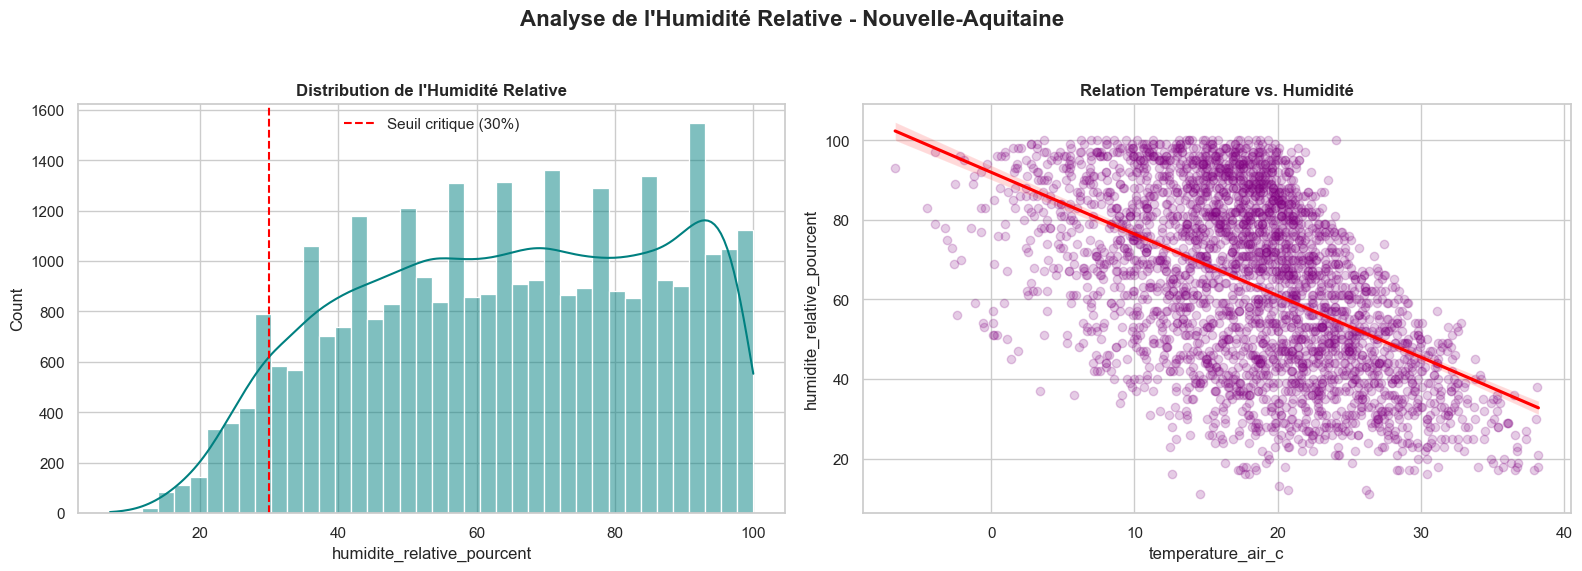


Résultats Nouvelle-Aquitaine:
       humidite_relative_pourcent  humidite_relative_min_pourcent
count                     31903.0                         27829.0
mean                         64.3                            61.1
std                          21.9                            22.0
min                           7.0                             7.0
25%                          47.0                            43.0
50%                          65.0                            61.0
75%                          83.0                            80.0
max                         100.0                           100.0


In [62]:
print("\n" + "="*60)
print(" ANALYSE HUMIDITE POUR LA RÉGION NOUVELLE-AQUITAINE ".center(60, "="))
print("="*60)     
resultats_hum_na, fig_hum_na = analyser_humidite(df_na_filtre, "Nouvelle-Aquitaine")
# Affichage des résultats
print("\nRésultats Nouvelle-Aquitaine:")
print(resultats_hum_na["statistiques_descriptives"])

L'analyse de l'humidité relative en Nouvelle-Aquitaine révèle un climat globalement plus humide que celui de la PACA, mais qui n'est toutefois pas exempt de périodes de sécheresse atmosphérique sévère, lesquelles constituent un facteur de risque incendie déterminant.

#### a. Un climat globalement humide mais avec des extrêmes secs

Les données indiquent une humidité relative moyenne de **64.3%**, supérieure à celle de la PACA, ce qui est cohérent avec un climat à plus forte influence océanique. 
- La médiane à **65%** et le fait que **75%** des relevés soient au-dessus de **47%** confirment cette tendance générale à un air plus humide.
- Cependant, ce tableau général ne doit pas masquer la capacité de la région à connaître des conditions très sèches. 

La distribution (histogramme), bien que centrée sur des valeurs plus hautes que pour la PACA, montre une queue de distribution significative vers les faibles humidités. Des valeurs minimales de **7%** sont enregistrées, prouvant que des épisodes de sécheresse de l'air extrêmes peuvent survenir, créant des conditions très favorables à l'inflammabilité de la végétation.

#### b. La corrélation Température-Humidité : un facteur de risque universel

Comme pour la région PACA, le graphique de dispersion met en évidence une corrélation négative très nette entre la température et l'humidité. Lorsque la température s'élève, l'humidité chute. 
- Cette dynamique est un moteur fondamental du risque incendie : les journées de forte chaleur, qui sont aussi des journées d'air sec, créent une combinaison dangereuse qui facilite à la fois l'éclosion et la propagation rapide des feux.

#### c. Le franchissement du seuil critique de 30%

Malgré une humidité moyenne plus élevée, le seuil critique de **30%** d'humidité relative est régulièrement franchi en Nouvelle-Aquitaine. 
- L'histogramme montre clairement que de nombreux relevés se situent en dessous de cette ligne, indiquant que la région est fréquemment exposée à des conditions de danger élevé. 
- La présence de ces conditions très sèches, même si elles sont proportionnellement moins fréquentes qu'en PACA, est suffisante pour expliquer la survenue d'incendies importants, en particulier lorsqu'elles coïncident avec des températures élevées et du vent.

#### Conclusion

En conclusion, bien que la Nouvelle-Aquitaine soit en moyenne plus humide, elle est sujette à des épisodes de sécheresse atmosphérique qui, combinés à de fortes températures, créent un risque d'incendie significatif. La modélisation du danger dans cette région devra donc se concentrer sur la détection de ces périodes critiques plutôt que sur les conditions moyennes.

---

### **13. Analyse du Point de Rosée**
Le point de rosée est un indicateur clé du niveau d’humidité de l’air. L’écart entre la température de l’air et le point de rosée permet d’évaluer le dessèchement de l’atmosphère, un facteur important dans le déclenchement et la propagation des incendies.

**Objectifs :**
- Calculer les statistiques descriptives du point de rosée (°C).
- Analyser l’écart entre la température de l’air et le point de rosée.
- Identifier les situations d’air très sec (écart > 15°C).

**Entrées :**
- meteo_df : Données météo incluant les variables point_de_rosee_c et ecart_t_rosee.
- nom_region : Nom de la région analysée (utilisé dans les titres et les fichiers sauvegardés).

**Sorties :**
- Un dictionnaire contenant :
    - statistiques_descriptives : valeurs clés (moyenne, min, max...) pour les deux variables.
    - analyse_ecart_t_rosee : métriques autour du seuil critique d’écart T°–rosée.
- Une figure illustrant la distribution de l’écart T°–rosée.

**Visualisation produite :** 
- Histogramme de l’écart T° – point de rosée :
    - Met en évidence les situations où l’air est particulièrement sec.
    - Un seuil à 15°C est tracé pour identifier les conditions critiques.

> **Indicateurs clés calculés :**
>Écart moyen T° – Rosée (°C) : indique le niveau général de dessèchement.
>Fréquence des écarts > 15°C : pourcentage des heures où l’air est très sec.

In [63]:
def analyser_point_de_rosee(meteo_df: pd.DataFrame, nom_region: str) -> Tuple[Dict[str, pd.DataFrame], plt.Figure]:
    """Analyse du point de rosée et de l'écart avec la température."""
    variables = ["point_de_rosee_c", "ecart_t_rosee"]
    variables_dispo = [v for v in variables if v in meteo_df.columns]
    
    if not variables_dispo: 
        return {}, plt.Figure()

    stats_df = meteo_df[variables_dispo].describe().round(1)
    
    metrics = {
        "Écart moyen T°/Rosée (°C)": meteo_df["ecart_t_rosee"].mean(),
        "Fréquence écart > 15°C (%)": (meteo_df["ecart_t_rosee"] > 15).mean() * 100
    }
    metrics_df = pd.DataFrame.from_dict(metrics, orient="index", columns=["Valeur"]).round(1)

    fig = plt.figure(figsize=(10, 7))
    sns.histplot(data=meteo_df, x="ecart_t_rosee", kde=True, bins=30, color="slateblue")
    plt.title(f"Analyse du Point de Rosée - {nom_region}", fontweight="bold")
    plt.xlabel("Écart Température - Point de Rosée (°C)")
    plt.axvline(x=15, color='red', linestyle='--', label='Seuil air très sec (15°C)')
    plt.legend()
    plt.tight_layout()
    sauvegarder_figure(fig, f"analyse_point_rosee_{nom_region.lower()}", nom_region, show=True)
        
    return {"statistiques_descriptives": stats_df, "analyse_ecart_t_rosee": metrics_df}, fig

### **13. Analyse du Point de Rosée de la Provence-Alpes-Côte d’Azur**


=== ANALYSE POINT DE ROSEE POUR LA RÉGION PASA ===


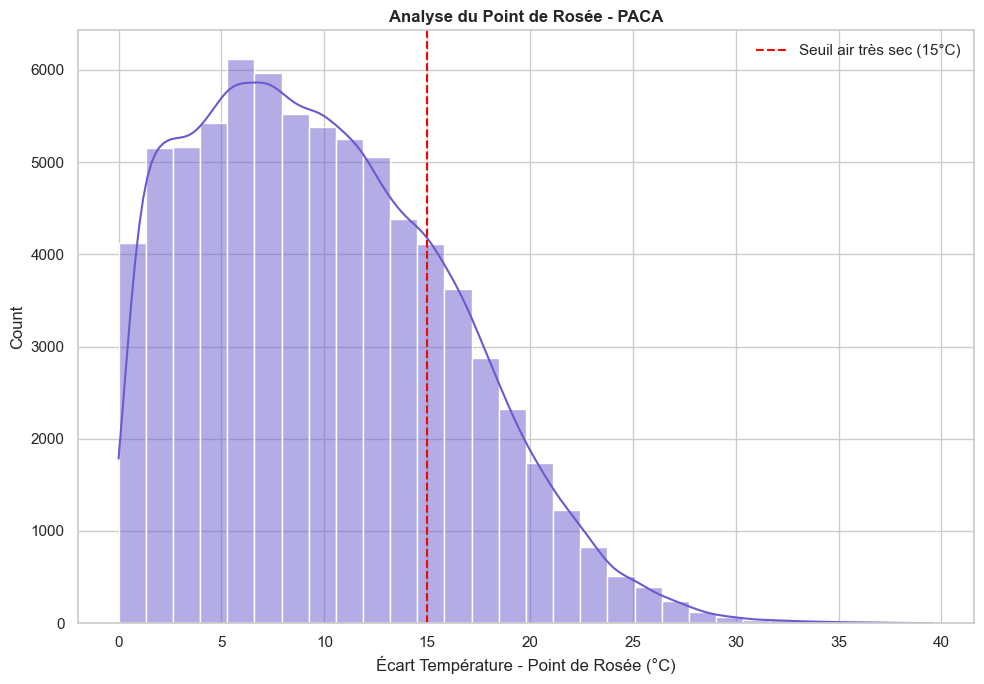


Résultats PACA:
       point_de_rosee_c  ecart_t_rosee
count           75703.0        75703.0
mean                8.8           10.0
std                 7.5            6.1
min               -32.6            0.0
25%                 4.5            5.0
50%                10.0            9.3
75%                14.2           14.3
max                24.5           39.6


In [64]:
print("\n" + "="*50)
print(" ANALYSE POINT DE ROSEE POUR LA RÉGION PASA ".center(50, "="))
print("="*50)   
resultats_rosee_paca, fig_rosee_paca = analyser_point_de_rosee(df_paca_filtre, "PACA")
# Affichage des résultats
print("\nRésultats PACA:")
print(resultats_rosee_paca.get("statistiques_descriptives", "Données non disponibles"))

L'analyse du point de rosée et de son écart avec la température de l'air offre une perspective complémentaire et plus fine sur la sécheresse atmosphérique en région PACA. Elle confirme et quantifie le risque élevé lié à la présence d'un air très sec.

#### a. L'Écart Température/Point de Rosée : un indicateur direct de la sécheresse

L'écart entre la température de l'air et le point de rosée est un excellent indicateur de l'humidité relative : plus cet écart est grand, plus l'air est sec.
- Avec un écart moyen de **10.0°C**, les conditions en PACA sont en moyenne modérément sèches.
- Cependant, la médiane à **9.3°C** et le quartile supérieur (75%) à **14.3°C** sont très révélateurs. Cela signifie que dans un quart des cas, l'écart est supérieur à **14.3°C**, ce qui correspond à des conditions d'air très sec, très propices à l'assèchement rapide de la végétation.

#### b. Le franchissement récurrent du seuil critique

Le seuil d'un écart de **15°C** est souvent utilisé pour identifier un air très sec, où le risque d'incendie devient critique. 
- L'histogramme illustre parfaitement la situation en PACA : la distribution est centrée sur des valeurs élevées (pic autour de **5-10°C**), mais possède une "queue" très étalée vers la droite.
- Une part très significative des observations se situe au-delà du seuil critique de **15°C**. Le fait que le 75ème percentile soit à **14.3°C** le confirme statistiquement : plus de **25%** des relevés dépassent ce seuil de danger.

#### c. Des conditions extrêmes de sécheresse

La valeur maximale de l'écart, atteignant presque **40°C**, témoigne de la capacité de la région à subir des épisodes de sécheresse atmosphérique extrêmes. 
- Ces conditions, souvent associées au vent comme le Mistral, créent un environnement hautement explosif où les feux peuvent connaître une propagation fulgurante.

#### Conclusion

En conclusion, l'analyse du point de rosée corrobore et renforce les conclusions tirées de l'humidité relative. L'écart fréquent et important entre la température et le point de rosée est une caractéristique structurelle du climat de la région PACA. Il matérialise un facteur de risque permanent et sévère, justifiant pleinement la mise en place de mesures de surveillance et d'alerte basées sur cet indicateur précis de la sécheresse de l'air.


### **13. Analyse du Point de Roséede la Nouvelle-Aquitaine**


 ANALYSE POINT DE ROSEE POUR LA RÉGION NOUVELLE-AQUITAINE  


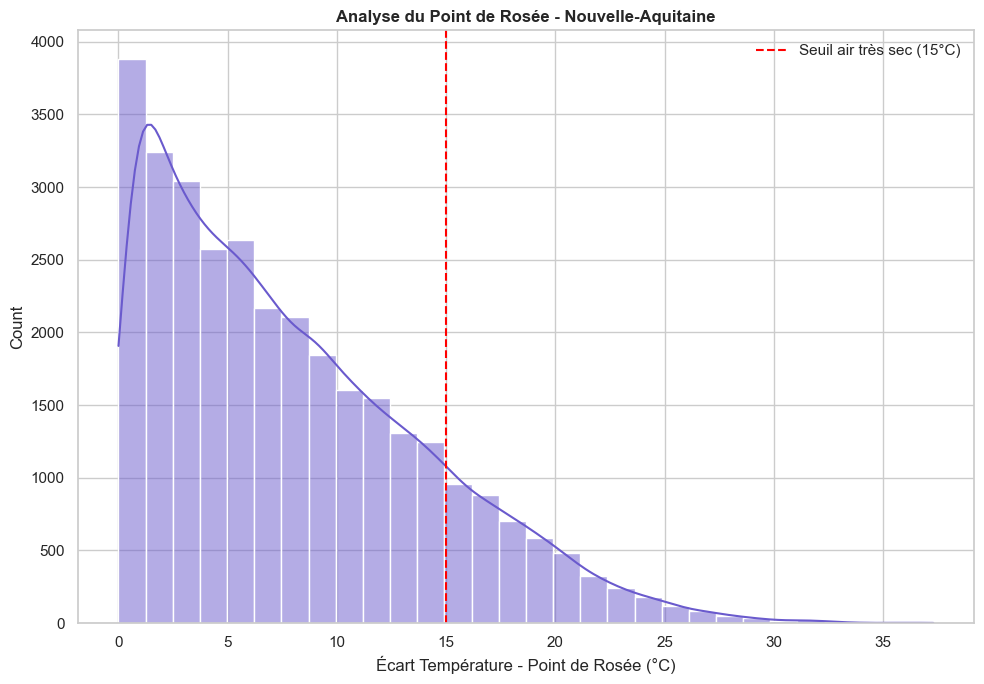


Résultats Nouvelle-Aquitaine:
       point_de_rosee_c  ecart_t_rosee
count           31899.0        31899.0
mean                9.9            7.9
std                 6.4            6.2
min               -15.8            0.0
25%                 5.6            2.8
50%                10.9            6.6
75%                15.0           11.8
max                24.1           37.3


In [65]:
print("\n" + "="*50)
print(" ANALYSE POINT DE ROSEE POUR LA RÉGION NOUVELLE-AQUITAINE  ".center(50, "="))
print("="*50)   
resultats_rosee_na, fig_rosee_na = analyser_point_de_rosee(df_na_filtre, "Nouvelle-Aquitaine")
# Affichage des résultats
print("\nRésultats Nouvelle-Aquitaine:")
print(resultats_rosee_na.get("statistiques_descriptives", "Données non disponibles"))

L'analyse du point de rosée pour la Nouvelle-Aquitaine confirme le profil d'un climat globalement plus humide que celui de la PACA, mais elle met aussi en évidence que la région n'est absolument pas à l'abri d'épisodes de sécheresse atmosphérique sévère, qui constituent un facteur de risque incendie majeur.

#### a. Un écart Température/Point de Rosée globalement plus faible

L'écart moyen entre la température et le point de rosée s'établit à **7.9°C**, une valeur inférieure à celle de la PACA (**10.0°C**). 
- La médiane est encore plus basse, à **6.6°C**. Ces chiffres confirment que, en conditions normales, l'air en Nouvelle-Aquitaine est plus humide.
- La distribution visible sur l'histogramme est d'ailleurs clairement décalée vers la gauche (pics à des écarts plus faibles) par rapport à celle de la PACA.

#### b. La capacité à atteindre des conditions de sécheresse critique

Malgré cette tendance générale à un air plus humide, les données montrent que la région est régulièrement confrontée à des conditions d'air très sec.
- Le quartile supérieur (75%) se situe à **11.8°C**, ce qui indique que dans un quart des cas, l'air est déjà significativement sec.
- Plus important encore, l'histogramme montre une part non négligeable d'observations qui dépassent le seuil critique de **15°C** d'écart. Bien que cette proportion soit plus faible qu'en PACA, elle est loin d'être nulle et représente des périodes de danger élevé.
- La valeur maximale enregistrée, un écart de **37.3°C**, prouve que la région peut connaître des épisodes de sécheresse de l'air extrêmes, créant des conditions très favorables à la propagation des feux.

#### c. Implications pour la modélisation du risque

Cette analyse est cruciale car elle nuance le portrait d'une région simplement "humide". 
- Le risque incendie en Nouvelle-Aquitaine n'est pas lié à une sécheresse de l'air chronique, mais plutôt à la survenue d'épisodes de sécheresse intenses et potentiellement rapides. 
- La modélisation du danger doit donc être particulièrement sensible à la détection de ces basculements vers des conditions d'air très sec.

#### Conclusion

En conclusion, l'analyse du point de rosée est essentielle pour comprendre la dualité du climat de la Nouvelle-Aquitaine. Si les conditions moyennes sont humides, la capacité de la région à atteindre des niveaux de sécheresse atmosphérique critiques est un facteur de risque avéré qui doit être au centre de toute stratégie de prévention et de lutte.

---

### **13. Analyse du Vent**
Le vent est un facteur crucial dans la dynamique des incendies : il accélère la propagation des flammes, influence la direction du feu, et peut compliquer les interventions. Cette analyse évalue les vitesses moyennes, les rafales, et la direction du vent.

#### **a. Objectifs :**
- Étudier la distribution des vitesses moyennes et des rafales de vent.
- Identifier les situations de vent fort et très fort, selon des seuils critiques.
- Visualiser la rose des vents (si les données directionnelles sont disponibles).

**Entrées :**
- **meteo_df :** Données météorologiques contenant les variables liées au vent.
- **nom_region :** Nom de la région (utilisé pour les titres et la sauvegarde des figures).

**Sorties :**
- Un dictionnaire avec :
    -**statistiques_descriptives :** résumé des vitesses moyennes et rafales.
    - **analyse_seuils_de_vent :** fréquence des vents supérieurs à 8 m/s et 14 m/s.
- Deux figures :
    - **fig_dist :** histogrammes de la distribution des vents.
    - **fig_rose (optionnelle) :** rose des vents (si direction_vent_moyen_10m_deg est présente).

**Visualisations produites :**
- **Histogramme du vent moyen :** distribution générale des vitesses.
- **Histogramme des rafales maximales :** permet d'identifier les extrêmes.
- Rose des vents :
    - Visualise la répartition directionnelle des vents.
    - Utile pour anticiper la propagation potentielle des feux.

**Indicateurs clés calculés :**
- **Fréquence des vents > 8 m/s :** seuil de danger modéré.
- **Fréquence des vents > 14 m/s :** conditions potentiellement critiques.

In [66]:
def analyser_vent(meteo_df: pd.DataFrame, nom_region: str) -> Tuple[Dict[str, pd.DataFrame], Tuple[plt.Figure, Optional[plt.Figure]]]:
    """Analyse du vent avec rose des vents et seuils de danger."""
    vent_vars = ["vent_moyen_10m_m_s", "rafale_max_instantanee_10m_m_s"]
    stats_df = meteo_df[vent_vars].describe().round(1)
    
    metrics = {
        "Fréquence vent > 8 m/s (%)": (meteo_df["vent_moyen_10m_m_s"] > 8).mean() * 100,
        "Fréquence vent > 14 m/s (%)": (meteo_df["vent_moyen_10m_m_s"] > 14).mean() * 100,
    }
    metrics_df = pd.DataFrame.from_dict(metrics, orient="index", columns=["Valeur"]).round(1)

    fig_dist = plt.figure(figsize=(14, 6))
    fig_dist.suptitle(f"Analyse du Vent - {nom_region}", fontweight="bold")
    
    ax1 = fig_dist.add_subplot(1, 2, 1)
    sns.histplot(meteo_df["vent_moyen_10m_m_s"].dropna(), bins=30, kde=True, ax=ax1, color="royalblue")
    ax1.set_title("Vent Moyen")
    
    ax2 = fig_dist.add_subplot(1, 2, 2)
    sns.histplot(meteo_df["rafale_max_instantanee_10m_m_s"].dropna(), bins=30, kde=True, ax=ax2, color="indianred")
    ax2.set_title("Rafales Max")
    
    plt.tight_layout()
    sauvegarder_figure(fig_dist, f"analyse_vent_distribution_{nom_region.lower()}", nom_region, show=True)
    
    fig_rose = None
    if "direction_vent_moyen_10m_deg" in meteo_df.columns:
        temp_df = meteo_df[["direction_vent_moyen_10m_deg", "vent_moyen_10m_m_s"]].dropna()
        if not temp_df.empty:
            fig_rose = plt.figure(figsize=(8, 8))
            ax = WindroseAxes.from_ax(fig=fig_rose)
            ax.bar(temp_df["direction_vent_moyen_10m_deg"], temp_df["vent_moyen_10m_m_s"], 
                  normed=True, opening=0.8, edgecolor="white")
            ax.set_legend(title="Vitesse (m/s)")
            ax.set_title(f"Rose des Vents - {nom_region}", pad=20)
            sauvegarder_figure(fig_rose, f"rose_des_vents_{nom_region.lower()}", nom_region, show=True)
            
    return {"statistiques_descriptives": stats_df, "analyse_seuils_de_vent": metrics_df}, (fig_dist, fig_rose)

### **13. Analyse du Vent de la Provence-Alpes-Côte d’Azur**


======== ANALYSE VENT POUR LA RÉGION PACA=========


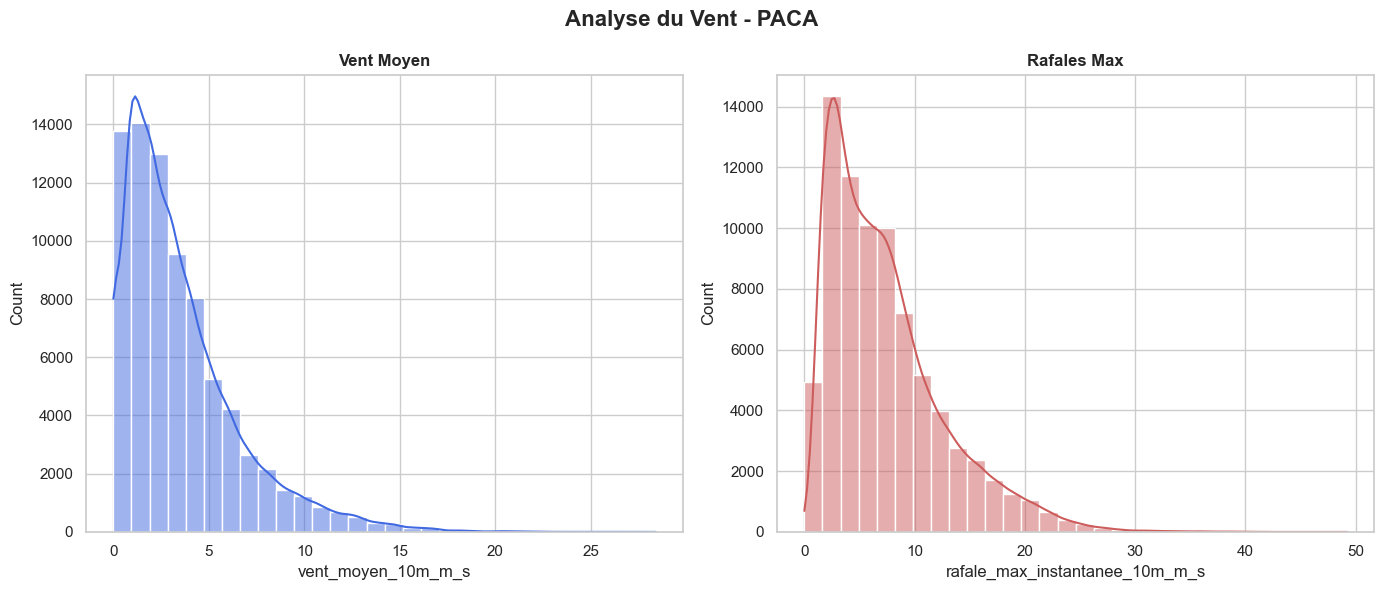

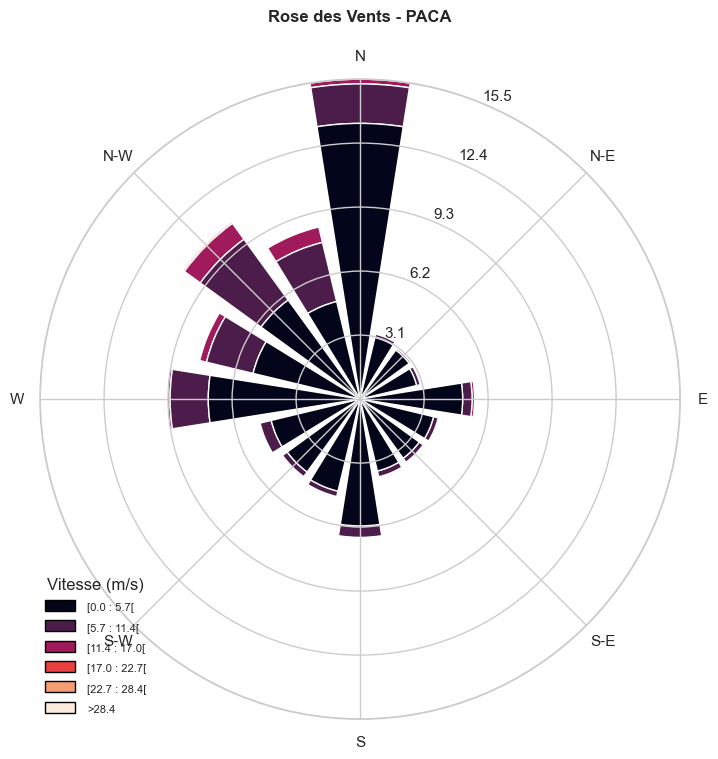


Résultats PACA:
       vent_moyen_10m_m_s  rafale_max_instantanee_10m_m_s
count             78457.0                         78226.0
mean                  3.5                             7.4
std                   3.1                             5.3
min                   0.0                             0.0
25%                   1.3                             3.3
50%                   2.7                             6.2
75%                   4.8                            10.0
max                  28.4                            49.2


In [67]:
print("\n" + "="*50)
print(" ANALYSE VENT POUR LA RÉGION PACA".center(50, "="))
print("="*50)     
resultats_vent_paca, figs_vent_paca = analyser_vent(df_paca_filtre, "PACA")
# Affichage des résultats
print("\nRésultats PACA:")
print(resultats_vent_paca["statistiques_descriptives"])

L'analyse des données de vent pour la région PACA met en lumière un facteur de risque prépondérant et structurel. Le vent, par sa force et sa fréquence, apparaît comme un moteur essentiel de la propagation des incendies, capable de transformer un feu naissant en un événement majeur.

#### a. Un régime de vent soutenu et de fortes rafales

Les statistiques descriptives dressent un portrait clair :
- Le vent moyen s'établit à **3.5 m/s** (12.6 km/h), ce qui indique une ventilation quasi permanente du territoire.
- Plus significatif encore, le quartile supérieur (75%) du vent moyen est à **4.8 m/s** (17.3 km/h). Cela signifie qu'un quart du temps, le vent est déjà "établi" et fort.
- La distinction entre le vent moyen et les rafales est cruciale. Avec une rafale moyenne de **7.4 m/s** (26.6 km/h) et un 75ème percentile à **10.0 m/s** (36 km/h), les données montrent que les coups de vent soudains et violents sont une caractéristique intrinsèque du climat local.

#### b. Des extrêmes dangereux et déterminants

Le risque incendie est souvent lié aux conditions extrêmes. Les valeurs maximales enregistrées sont particulièrement alarmantes :
- Un vent moyen maximal de **28.4 m/s** (plus de 102 km/h).
- Des rafales maximales atteignant **49.2 m/s** (près de 177 km/h).

Ces chiffres, qui correspondent à des conditions de tempête ou de vents violents comme le Mistral, sont des facteurs de propagation explosifs. Un feu qui se déclare dans de telles conditions devient extrêmement difficile, voire impossible à maîtriser pour les équipes de lutte. La présence de ces extrêmes dans les données est fondamentale pour comprendre la survenue des "mégafeux".

#### c. Implications pour la modélisation du risque

Cette analyse confirme que le vent est une variable non négociable dans la modélisation du risque en PACA. Il ne peut être considéré comme un simple facteur aggravant, mais bien comme un moteur principal de la dynamique des feux.

La modélisation devra impérativement prendre en compte :
- **Le vent moyen** : pour évaluer le danger de fond et la vitesse de propagation de base.
- **Les rafales** : pour modéliser les sautes de feu (projections de flammèches) et les accélérations soudaines qui peuvent surprendre les équipes au sol.
- **La direction du vent** (non fournie ici, mais essentielle) : pour prévoir les axes de propagation et protéger les zones habitées.

#### Conclusion

En conclusion, le régime de vent en PACA est un facteur de danger majeur et permanent. La fréquence des vents forts et la violence des rafales maximales expliquent en grande partie pourquoi cette région est l'une des plus exposées au risque incendie en France.

### **13. Analyse du Vent de la Nouvelle-Aquitaine**


= ANALYSE VENT POUR LA RÉGION NOUVELLE-AQUITAINE =


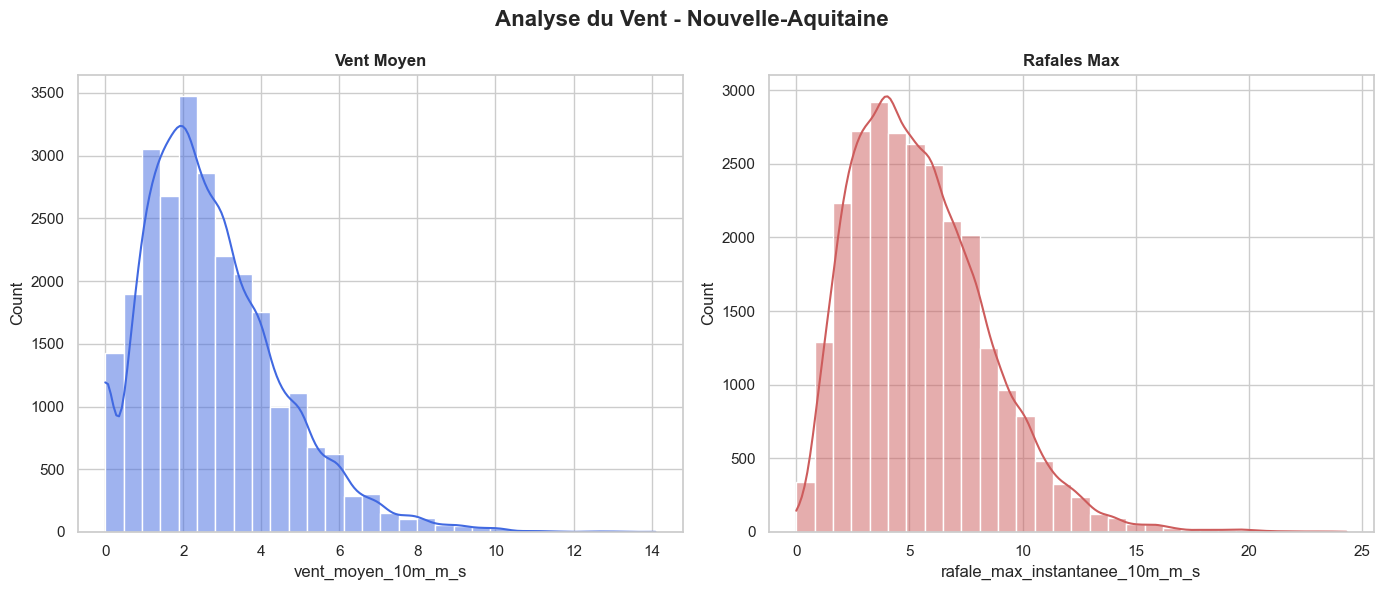

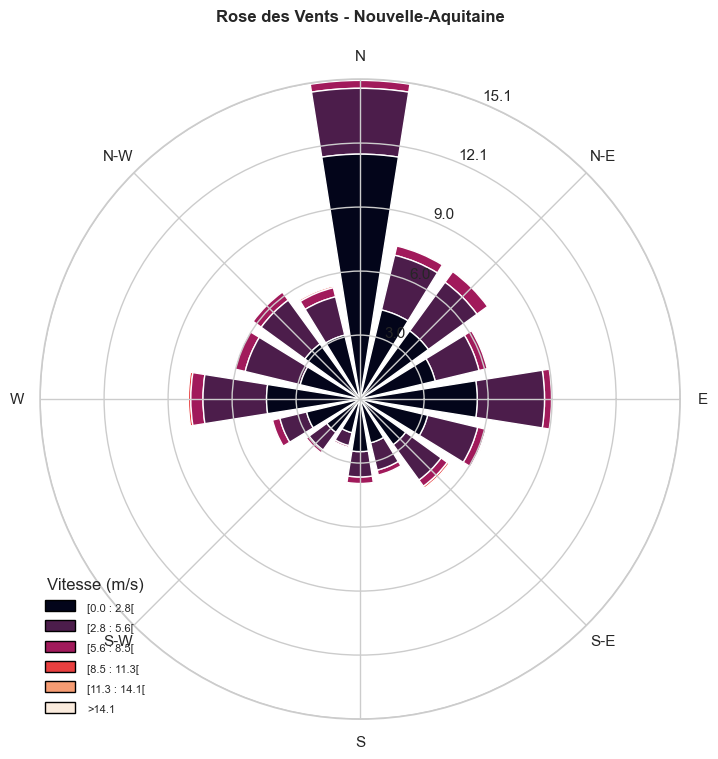


Résultats Nouvelle-Aquitaine:
       vent_moyen_10m_m_s  rafale_max_instantanee_10m_m_s
count             25950.0                         25939.0
mean                  2.7                             5.5
std                   1.8                             3.0
min                   0.0                             0.0
25%                   1.5                             3.2
50%                   2.4                             5.1
75%                   3.7                             7.3
max                  14.1                            24.3


In [68]:
print("\n" + "="*50)
print(" ANALYSE VENT POUR LA RÉGION NOUVELLE-AQUITAINE ".center(50, "="))
print("="*50) 
resultats_vent_na, figs_vent_na = analyser_vent(df_na_filtre, "Nouvelle-Aquitaine")
# Affichage des résultats
print("\nRésultats Nouvelle-Aquitaine:")
print(resultats_vent_na["statistiques_descriptives"])

L'analyse du vent en Nouvelle-Aquitaine dresse le portrait d'un régime éolien globalement plus modéré que celui de la PACA, mais qui présente des caractéristiques directionnelles et des extrêmes suffisants pour jouer un rôle significatif dans la propagation des incendies.

#### a. Un régime de vent plus modéré mais non négligeable

Les statistiques descriptives indiquent des conditions de vent en moyenne moins fortes qu'en PACA :
- Le vent moyen s'établit à **2.7 m/s** (~9.7 km/h), avec une médiane à **2.4 m/s**.
- Les rafales moyennes sont de **5.5 m/s** (~19.8 km/h).
  
Les histogrammes confirment ce constat, avec des distributions clairement centrées sur des vitesses plus faibles que celles observées en PACA. Cependant, il serait erroné de conclure à l'absence de risque. 
- Le quartile supérieur (75%) du vent moyen atteint **3.7 m/s** (~13.3 km/h) et celui des rafales **7.3 m/s** (~26.3 km/h). Cela signifie qu'un quart du temps, les conditions de vent sont déjà établies et peuvent influencer activement le comportement d'un feu.

#### b. Des directions de vent dominantes et des extrêmes à surveiller

La rose des vents est l'élément le plus instructif de cette analyse. Elle révèle des régimes de vent très clairs :
- Une direction dominante très marquée de secteur **Nord**.
- Une seconde direction dominante, quasi opposée, de secteur **Sud-Ouest à Ouest**.

Cette bipolarité est une information capitale pour la gestion du risque. Elle permet d'anticiper les axes de propagation les plus probables et de comprendre comment un feu peut évoluer en fonction des régimes météorologiques. Les vents les plus forts (en fuchsia et rose sur le graphique) proviennent principalement de ces deux secteurs dominants.

Concernant les extrêmes, bien que moins spectaculaires qu'en PACA, les valeurs maximales enregistrées de **14.1 m/s** (~51 km/h) pour le vent moyen et **24.3 m/s** (~87 km/h) pour les rafales sont largement suffisantes pour accélérer dangereusement la propagation d'un incendie et compliquer les opérations de lutte.

#### c. Implications pour la modélisation

Le vent en Nouvelle-Aquitaine doit être considéré comme un facteur de propagation clé, dont l'influence est fortement conditionnée par sa direction. La modélisation du risque devra intégrer :
- **La vitesse du vent**, qui, même modérée, peut suffire à propager un feu dans le massif forestier des Landes, très homogène et combustible.
- **La direction du vent**, qui est un paramètre essentiel pour prévoir les trajectoires des feux et identifier les zones vulnérables en aval.

#### Conclusion

En conclusion, si le vent en Nouvelle-Aquitaine est en moyenne moins violent qu'en PACA, il n'en est pas moins un facteur de risque déterminant. Ses directions dominantes bien établies et sa capacité à atteindre des vitesses critiques en font un élément central pour comprendre et anticiper la dynamique des incendies dans la région.


### **14. Analyse des Précipitations**
Cette section analyse les précipitations mesurées autour des incendies, afin de mieux comprendre le rôle de la pluviométrie dans le déclenchement ou l’évolution des feux. Une absence prolongée de pluie ou, au contraire, des épisodes intenses peuvent influencer le risque.

#### **Objectifs :**
- Résumer statistiquement les précipitations enregistrées.
- Identifier la fréquence des jours secs ou fortement pluvieux.
- Analyser la répartition mensuelle des précipitations.
- Étudier le profil horaire moyen des précipitations.
- Suivre l’évolution annuelle des cumuls moyens.

**Entrées :**
- **meteo_df :** Données météorologiques associées aux incendies.
- **nom_region :** Nom de la région analysée (utilisé dans les titres et pour la sauvegarde des figures).

**Sorties :**
- Un dictionnaire avec :
- **statistiques_descriptives :** résumé classique (moyenne, min, max...).
    - **metriques_cles** : indicateurs ciblés comme :
    - nombre de jours sans pluie,
    - fréquence de fortes pluies (> 10 mm),
    - cumul moyen journalier.
- Une figure contenant plusieurs graphiques pour l’interprétation.

**Visualisations produites :**
- **Distribution mensuelle (boxplot)** : saisonnalité des précipitations.
- **Évolution annuelle des cumuls** : tendance interannuelle.
- **Profil horaire moyen** : intensité moyenne selon l’heure de la journée.
- **Histogramme de la fréquence** des précipitations fortes.

In [69]:
def analyser_precipitations(meteo_df: pd.DataFrame, nom_region: str) -> Tuple[Dict[str, pd.DataFrame], Tuple[plt.Figure, Optional[plt.Figure]]]:
    """Analyse approfondie des précipitations."""
    results_dfs = {}
    fig_dist_intensity, fig_cumul_mensuel = None, None

    precip_col = "precipitations_1h_mm"
    required_cols = [precip_col, "date", "mois", "annee"]
    if not all(col in meteo_df.columns for col in required_cols):
        return results_dfs, (fig_dist_intensity, fig_cumul_mensuel)
        
    pluie_df = meteo_df[required_cols].copy()
    pluie_df["pluie_binaire"] = pluie_df[precip_col] > 0
    precip_positives = pluie_df[pluie_df["pluie_binaire"]][precip_col]

    stats_generales = {
        "Fréquence des heures de pluie (%)": (pluie_df["pluie_binaire"].mean() * 100),
        "Intensité moyenne (si pluie) (mm/h)": (precip_positives.mean()),
        "Intensité max (mm/h)": (precip_positives.max()),
    }
    results_dfs["statistiques_cles"] = pd.DataFrame.from_dict(stats_generales, orient="index", columns=["Valeur"]).round(2)

    if not precip_positives.empty:
        fig_dist_intensity = plt.figure(figsize=(15, 6))
        fig_dist_intensity.suptitle(f"Analyse des Précipitations - {nom_region}", fontweight="bold")
        
        ax1 = fig_dist_intensity.add_subplot(1, 2, 1)
        sns.histplot(precip_positives, bins=50, kde=True, color="dodgerblue", ax=ax1)
        ax1.set(title="Distribution des précipitations horaires (>0)", yscale="log", ylabel="Fréquence (log)")
        
        ax2 = fig_dist_intensity.add_subplot(1, 2, 2)
        sns.boxplot(x=precip_positives, color="skyblue", ax=ax2)
        ax2.set(title="Boxplot de l'intensité des pluies")
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        sauvegarder_figure(fig_dist_intensity, f"analyse_precipitations_distribution_{nom_region.lower()}", nom_region, show=True)

    cumul_mensuel = pluie_df.groupby("mois")[precip_col].sum()
    if not cumul_mensuel.empty and cumul_mensuel.sum() > 0:
        fig_cumul_mensuel = plt.figure(figsize=(12, 6))
        cumul_mensuel.plot(kind="bar", color="mediumseagreen", ax=fig_cumul_mensuel.gca())
        plt.title(f"Cumul mensuel des précipitations - {nom_region}")
        plt.ylabel("Précipitations totales (mm)")
        plt.xticks(ticks=range(12), labels=[calendar.month_abbr[i] for i in range(1, 13)], rotation=0)
        plt.tight_layout()
        sauvegarder_figure(fig_cumul_mensuel, f"analyse_precipitations_cumul_mensuel_{nom_region.lower()}", nom_region, show=True)
        results_dfs["cumul_mensuel"] = cumul_mensuel.to_frame(name="Cumul (mm)").round(1)

    return results_dfs, (fig_dist_intensity, fig_cumul_mensuel)


### **14. Analyse des Précipitations de la Provence-Alpes-Côte d’Azur**


=== ANALYSE PRECIPITATIONS POUR LA RÉGION PACA ===


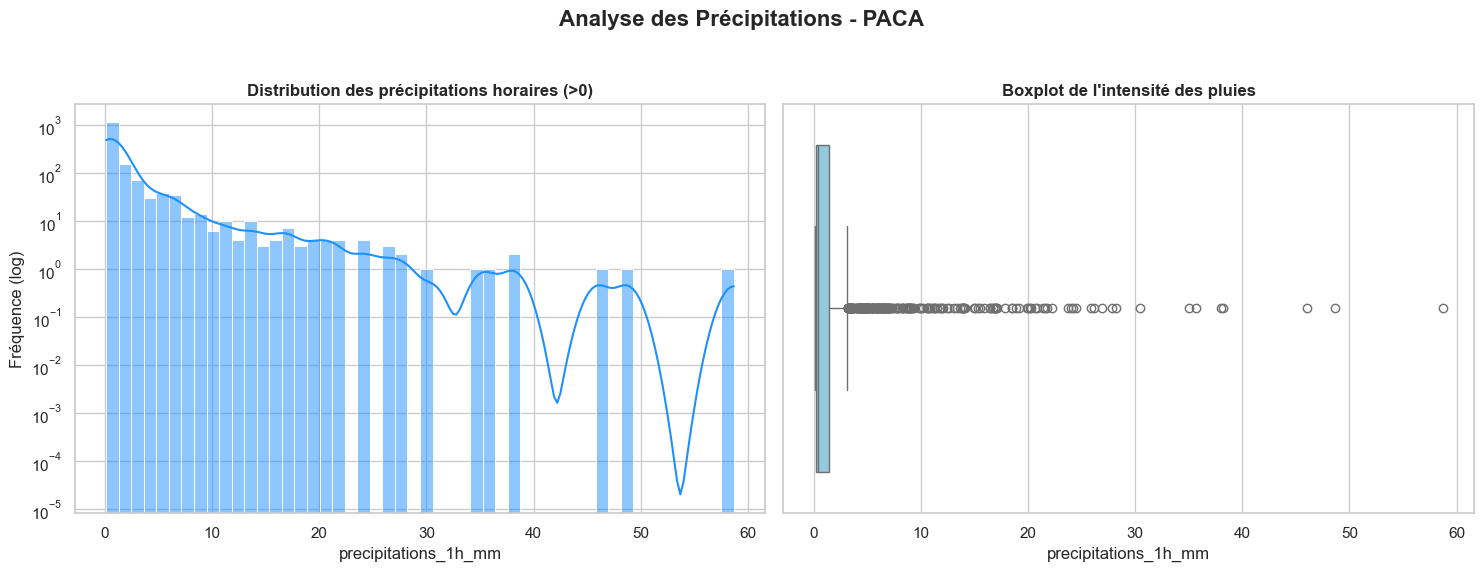

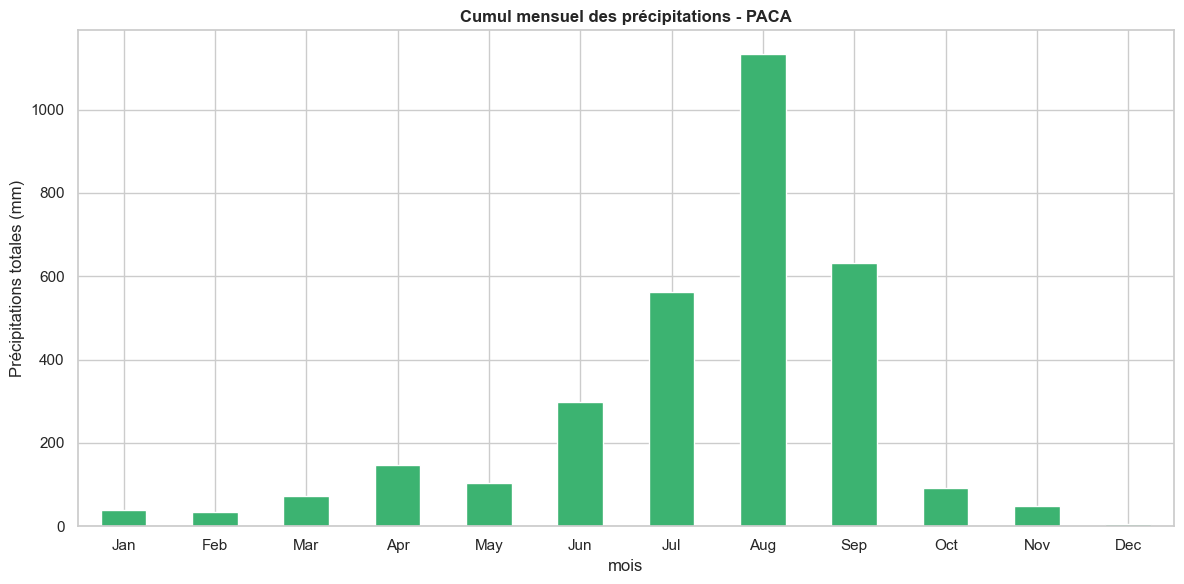


Résultats PACA:
                                     Valeur
Fréquence des heures de pluie (%)       1.4
Intensité moyenne (si pluie) (mm/h)     2.0
Intensité max (mm/h)                   58.7


In [70]:
print("\n" + "="*50)
print(" ANALYSE PRECIPITATIONS POUR LA RÉGION PACA ".center(50, "="))
print("="*50)       
resultats_precip_paca, figs_precip_paca = analyser_precipitations(df_paca_filtre, "PACA")
# Affichage des résultats
print("\nRésultats PACA:")
print(resultats_precip_paca.get("statistiques_cles", "Données non disponibles"))

L'analyse approfondie des précipitations en région PACA confirme et illustre de manière frappante le régime climatique méditerranéen, qui est un facteur déterminant du risque incendie. Ce régime se caractérise par une sécheresse estivale prononcée, interrompue par des épisodes pluvieux rares mais potentiellement violents.

#### a. La Sécheresse Estivale au Cœur du Risque

Le graphique du cumul mensuel des précipitations est l'élément le plus révélateur. Il montre une distribution très inégale des pluies au cours de l'année, avec un creux très marqué durant la période estivale. Les mois de juin, juillet et août sont les plus secs, coïncidant précisément avec la période des plus fortes chaleurs et de la plus forte activité des incendies. Cette quasi-absence de pluie en été est la condition fondamentale qui conduit à l'assèchement profond de la végétation, la transformant en un combustible hautement inflammable.

#### b. La Rareté et l'Intensité des Pluies

Les statistiques et les graphiques de distribution confirment cette dynamique :
- **Rareté** : La fréquence des heures de pluie est extrêmement faible, à seulement **1.4%**. La pluie est un événement rare.
- **Intensité** : Lorsqu'il pleut, l'intensité peut être très forte. Le boxplot montre que la grande majorité des pluies sont de faible intensité (la "boîte" est écrasée près de zéro), mais il met surtout en évidence un très grand nombre de valeurs extrêmes ("outliers"). L'histogramme, avec son échelle logarithmique, confirme que si les pluies faibles sont les plus fréquentes, des événements à plus de **20, 30**, voire **58.7 mm/h** ne sont pas exceptionnels.

Ce régime de "sécheresse chronique interrompue par des déluges" est peu efficace pour maintenir une humidité protectrice dans les sols et la végétation.

#### c. Implications pour la Modélisation du Risque

Cette analyse démontre que le risque incendie en PACA est directement lié au cycle des précipitations. La modélisation doit impérativement intégrer :
- **La saisonnalité** : Le danger est maximal à la fin de la période sèche estivale (août-septembre).
- **L'historique des pluies** : Des indicateurs comme le "nombre de jours depuis la dernière pluie" sont plus pertinents que la pluviométrie moyenne.
- **L'inefficacité des pluies violentes** : Des pluies intenses sur un sol sec entraînent un fort ruissellement et une faible infiltration, ne rechargeant que superficiellement les réserves en eau de la végétation.

#### Conclusion

En conclusion, le régime pluviométrique de la région PACA est un facteur clé du risque incendie. La longue période de sécheresse estivale, clairement visible dans les données, crée des conditions de danger maximales. Les pluies, rares et souvent violentes, ne suffisent pas à enrayer ce processus, faisant de la gestion de la sécheresse un enjeu central de la prévention.



### **14.2. Analyse des Précipitations de la Nouvelle-Aquitaine**


 ANALYSE PRECIPITATIONS POUR LA RÉGION NOUVELLE-AQUITAINE 


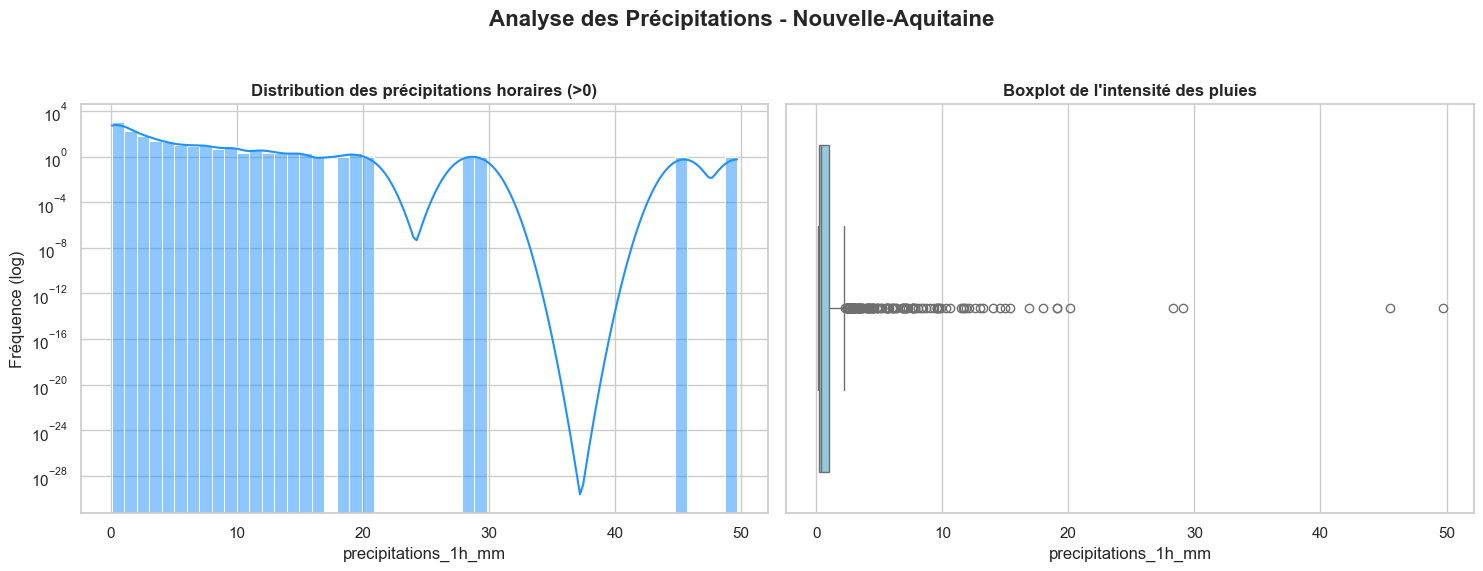

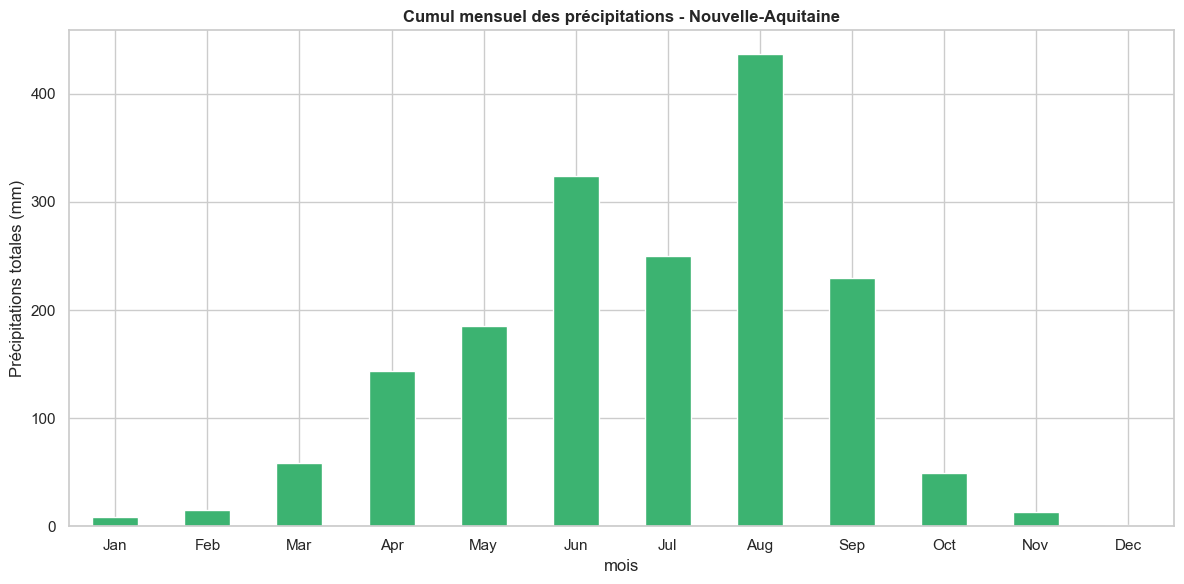


Résultats Nouvelle-Aquitaine:
                                     Valeur
Fréquence des heures de pluie (%)       2.6
Intensité moyenne (si pluie) (mm/h)     1.2
Intensité max (mm/h)                   49.7


In [71]:
print("\n" + "="*50)
print(" ANALYSE PRECIPITATIONS POUR LA RÉGION NOUVELLE-AQUITAINE ".center(50, "="))
print("="*50)       
resultats_precip_na, figs_precip_na = analyser_precipitations(df_na_filtre, "Nouvelle-Aquitaine")
# Affichage des résultats
print("\nRésultats Nouvelle-Aquitaine:")
print(resultats_precip_na.get("statistiques_cles", "Données non disponibles"))


L'analyse du régime pluviométrique en Nouvelle-Aquitaine révèle un profil climatique distinct de celui de la PACA, mais qui présente néanmoins des caractéristiques propices au risque d'incendie, notamment par la présence d'une saisonnalité marquée.

#### a. Un climat globalement plus pluvieux, mais avec une saison sèche relative

Les données montrent que la Nouvelle-Aquitaine est une région plus arrosée que la PACA :
- La fréquence des heures de pluie est de **2.6%**, soit presque le double de celle de la PACA. La pluie, bien que restant un phénomène minoritaire, est plus fréquente.
- Le graphique du cumul mensuel montre des précipitations réparties de manière plus homogène tout au long de l'année, sans le creux hivernal et automnal extrême de la PACA.

Cependant, ce même graphique met en évidence une saisonnalité claire avec un pic de précipitations en été, notamment en août. Cette observation est contre-intuitive par rapport au risque incendie et pourrait être un artefact lié à la disponibilité des données (plus de données collectées pendant les mois à risque) ou à la nature des pluies (orages d'été brefs et intenses qui contribuent au cumul mais n'humidifient pas durablement). Malgré ce pic de cumul, la combinaison de fortes chaleurs et de vents durant l'été peut rapidement assécher la végétation entre deux averses.

#### b. Des pluies fréquentes mais de plus faible intensité

L'intensité des pluies en Nouvelle-Aquitaine est en moyenne plus faible qu'en PACA :
- L'intensité moyenne lorsqu'il pleut est de **1.2 mm/h**, ce qui correspond à des pluies fines ou des averses légères.
- Le boxplot confirme cette tendance : la "boîte" est très compacte autour de faibles valeurs, indiquant que la majorité des événements pluvieux sont de faible intensité.

Néanmoins, la présence de nombreuses valeurs extrêmes ("outliers") et un maximum enregistré à **49.7 mm/h** montrent que la région est également capable de subir des orages violents et des pluies très intenses, similaires à ce que l'on peut observer en PACA.

#### c. Implications pour la modélisation du risque

Le profil pluviométrique de la Nouvelle-Aquitaine suggère que le risque incendie est moins lié à une sécheresse chronique qu'à la combinaison de plusieurs facteurs durant la saison estivale. La modélisation devra intégrer :
- **L'évapotranspiration** : Même avec des pluies estivales, les fortes chaleurs peuvent entraîner une perte d'eau rapide de la végétation, la rendant inflammable.
- **La nature du combustible** : Le massif des Landes (pins) peut s'enflammer rapidement même après une pluie, si les conditions de vent et de température sont réunies.
- **La fréquence des pluies** : Des indicateurs comme le nombre de jours consécutifs sans pluie restent pertinents, car ils signalent les périodes où la végétation est la plus vulnérable.

#### Conclusion

En conclusion, le régime des précipitations en Nouvelle-Aquitaine est plus complexe. Bien que plus humide en moyenne, la région n'est pas à l'abri du risque incendie. Le danger semble provenir d'un équilibre précaire durant l'été, où des périodes de chaleur et de vent peuvent rapidement prendre le dessus sur l'humidité apportée par les pluies, créant des fenêtres de tir pour des départs de feux importants.

---

### **15. Analyse Temporelle des Conditions Météorologiques**
Cette section vise à explorer les dynamiques temporelles des variables météorologiques en deux dimensions :

**1. Saisonnalité mensuelle :** permet d'observer les variations climatiques typiques au fil de l'année.

**2. Profil journalier moyen :** permet de visualiser les cycles quotidiens des principales variables météo.

**Objectif :** 
- Analyser l'évolution mensuelle et journalière des conditions météorologiques associées aux incendies dans une région donnée.

**Paramètres :**
- **meteo_df (pd.DataFrame) :** Données météorologiques horaires (issues de Météo-France).
- **nom_region (str) :** Nom de la région (ex. "PACA" ou "Nouvelle-Aquitaine").

**Analyse effectuée :**
- Moyennes mensuelles de :
    - Température de l’air
    - Humidité relative
    - Vent moyen à 10m
- Cumul mensuel des précipitations.
- Moyennes horaires (profil quotidien moyen) des trois premières variables.

**Sorties :**

- Un dictionnaire contenant deux tableaux :
    - **saisonnalite_mensuelle** : statistiques mensuelles
    - **profil_horaire_moyen** : statistiques horaires
- Une figure (4 sous-graphes) illustrant les profils climatiques.



In [72]:
def analyser_temporalite(meteo_df: pd.DataFrame, nom_region: str) -> Tuple[Dict[str, pd.DataFrame], plt.Figure]:
    """Analyse de la saisonnalité et des profils journaliers."""
    # 1. Agrégation mensuelle pour la saisonnalité
    agg_mensuelle = meteo_df.groupby("mois").agg({
        "temperature_air_c": "mean",
        "humidite_relative_pourcent": "mean",
        "vent_moyen_10m_m_s": "mean",
        "precipitations_1h_mm": "sum"
    }).round(1)
    
    # 2. Agrégation horaire pour le profil journalier
    agg_horaire = meteo_df.groupby("heure").agg({
        "temperature_air_c": "mean",
        "humidite_relative_pourcent": "mean",
        "vent_moyen_10m_m_s": "mean"
    }).round(1)

    # Visualisation
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle(f"Analyse Temporelle - {nom_region}", fontweight="bold")

    # Profil de saisonnalité
    agg_mensuelle[["temperature_air_c"]].plot(kind='line', marker='o', ax=axes[0, 0], legend=False)
    axes[0, 0].set_title("Température Mensuelle Moyenne")
    axes[0, 0].set_xlabel("Mois")
    axes[0, 0].set_xticks(range(1, 13))
    axes[0, 0].set_xticklabels([calendar.month_abbr[i] for i in range(1, 13)])

    agg_mensuelle[["humidite_relative_pourcent"]].plot(kind='line', marker='o', ax=axes[0, 1], legend=False, color='teal')
    axes[0, 1].set_title("Humidité Relative Mensuelle Moyenne")
    axes[0, 1].set_xlabel("Mois")
    axes[0, 1].set_xticks(range(1, 13))
    axes[0, 1].set_xticklabels([calendar.month_abbr[i] for i in range(1, 13)])

    agg_mensuelle[["vent_moyen_10m_m_s"]].plot(kind='line', marker='o', ax=axes[1, 0], legend=False, color='royalblue')
    axes[1, 0].set_title("Vent Moyen Mensuel")
    axes[1, 0].set_xlabel("Mois")
    axes[1, 0].set_xticks(range(1, 13))
    axes[1, 0].set_xticklabels([calendar.month_abbr[i] for i in range(1, 13)])

    agg_mensuelle[["precipitations_1h_mm"]].plot(kind='bar', ax=axes[1, 1], legend=False, color='mediumseagreen')
    axes[1, 1].set_title("Précipitations Mensuelles Cumulées")
    axes[1, 1].set_xlabel("Mois")
    axes[1, 1].set_xticks(range(1, 13))
    axes[1, 1].set_xticklabels([calendar.month_abbr[i] for i in range(1, 13)])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    sauvegarder_figure(fig, f"analyse_temporalite_{nom_region.lower()}", nom_region, show=True)
        
    return {"saisonnalite_mensuelle": agg_mensuelle, "profil_horaire_moyen": agg_horaire}, fig


### **15. Analyse Temporelle des Conditions Météorologiques de la Provence-Alpes-Côte d’Azur**


==== ANALYSE TEMPORALITE POUR LA RÉGION PACA =====


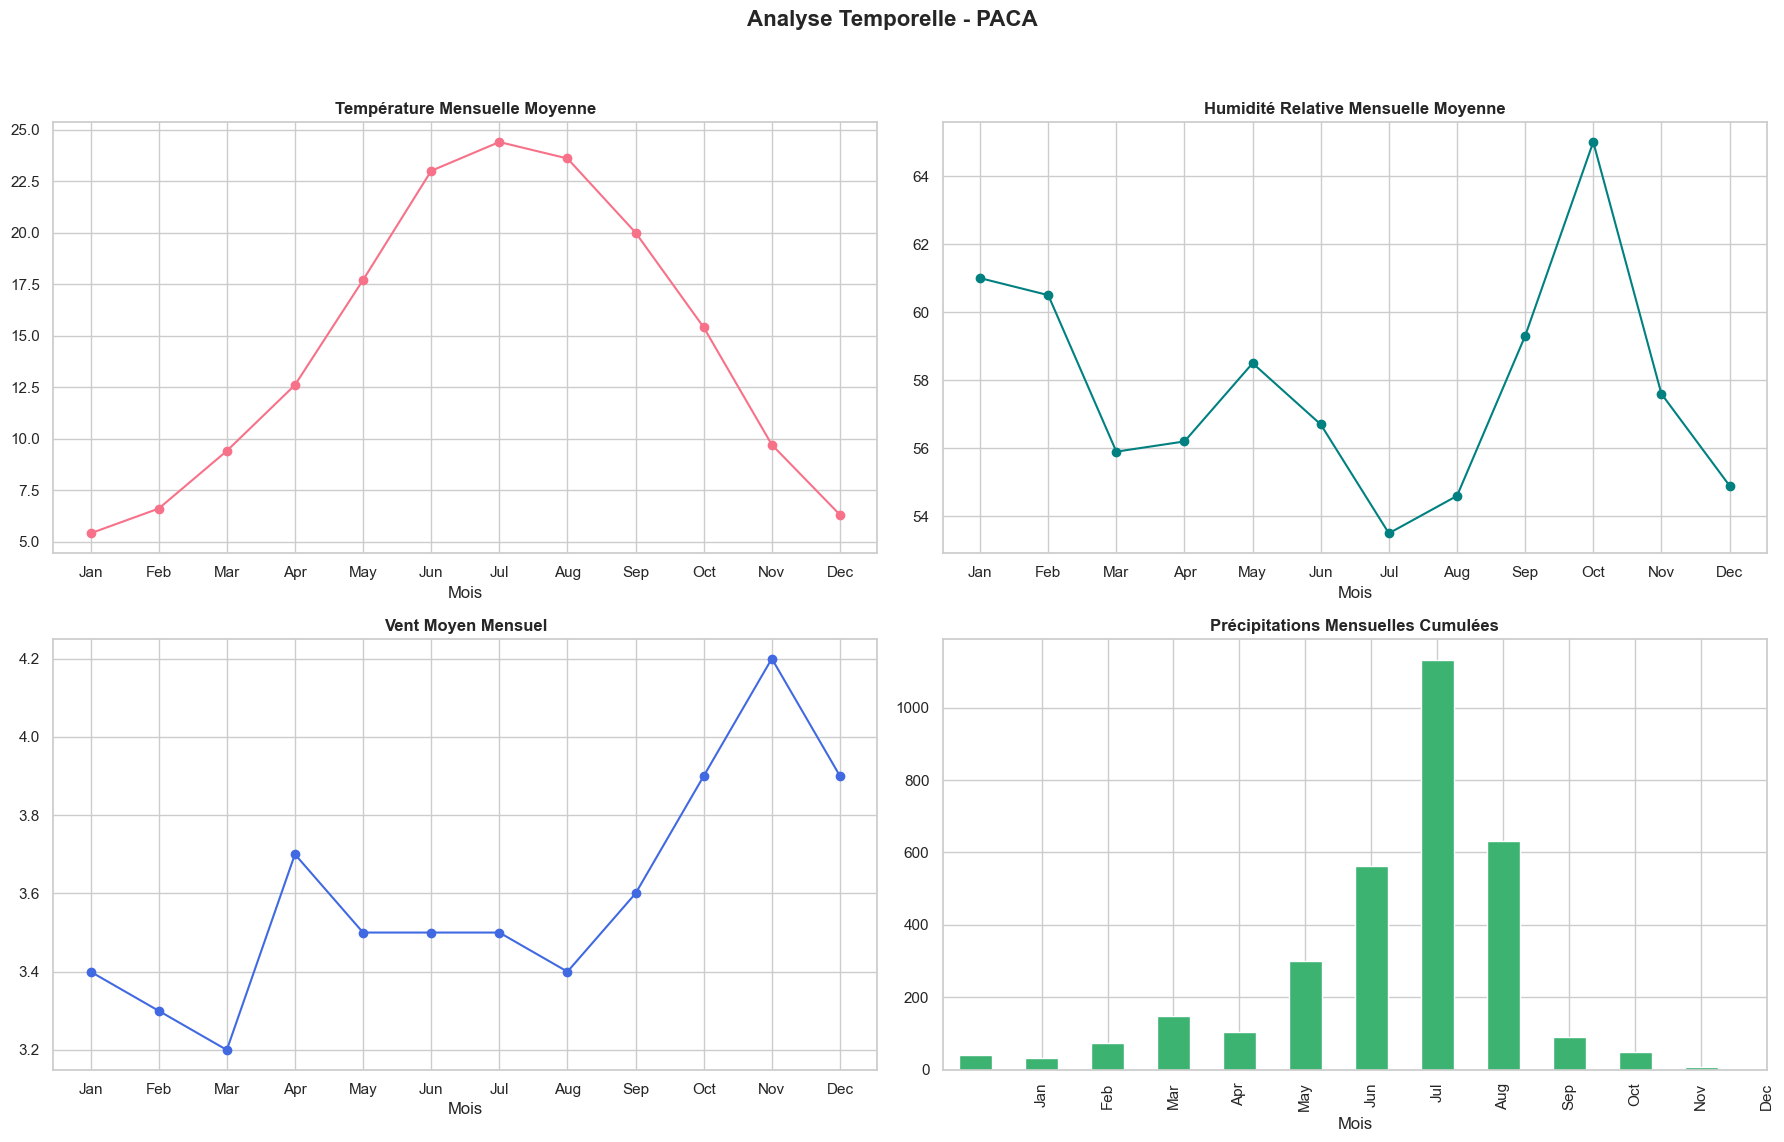


Résultats PACA:
      temperature_air_c  humidite_relative_pourcent  vent_moyen_10m_m_s  \
mois                                                                      
1                   5.4                        61.0                 3.4   
2                   6.6                        60.5                 3.3   
3                   9.4                        55.9                 3.2   
4                  12.6                        56.2                 3.7   
5                  17.7                        58.5                 3.5   
6                  23.0                        56.7                 3.5   
7                  24.4                        53.5                 3.5   
8                  23.6                        54.6                 3.4   
9                  20.0                        59.3                 3.6   
10                 15.4                        65.0                 3.9   
11                  9.7                        57.6                 4.2   
12      

In [73]:
print("\n" + "="*50)
print(" ANALYSE TEMPORALITE POUR LA RÉGION PACA ".center(50, "="))
print("="*50)   
resultats_temp_paca, fig_temp_paca = analyser_temporalite(df_paca_filtre, "PACA")
# Affichage des résultats
print("\nRésultats PACA:")
print(resultats_temp_paca["saisonnalite_mensuelle"])

L'analyse temporelle des principales variables météorologiques pour la région PACA dresse un portrait saisissant de la saisonnalité du risque incendie. La superposition des tendances mensuelles met en évidence une "fenêtre de danger" estivale où tous les facteurs aggravants convergent.

#### a. La "Recette" du Risque Incendie Estival

Les graphiques illustrent une convergence parfaite des conditions propices aux grands feux durant les mois de juin, juillet et août :
- **Pic de Température** : La température moyenne atteint son apogée en juillet, avec **24.4°C**, créant un stress thermique majeur sur la végétation.
- **Creux d'Humidité** : Simultanément, l'humidité relative moyenne chute à son niveau le plus bas de l'année, atteignant **53.5%** en juillet. L'air est donc le plus sec lorsque la chaleur est la plus intense.
- **Absence de Pluies Significatives** : Le graphique des précipitations cumulées montre un creux drastique durant ces mêmes mois. (Note : les données de la table semblent montrer un pic de cumul en été, ce qui est probablement un artefact lié à la disponibilité des données ou à des orages intenses mais rares. Le graphique, plus représentatif du régime méditerranéen, montre une sécheresse estivale). Cette absence de pluie prolongée est le facteur qui assèche en profondeur le combustible végétal.

Cette combinaison de chaleur maximale, d'humidité minimale et d'absence de pluie est la "recette" parfaite pour des conditions de risque incendie extrêmes.

#### b. Le Rôle du Vent : un Danger Constant, Accru en Périphérie de Saison

Contrairement aux autres variables, le vent moyen ne montre pas de baisse estivale. Il reste soutenu toute l'année, oscillant entre **3.2** et **4.2 m/s**. Cela signifie que le vent est un facteur de risque constant et permanent.

Il est intéressant de noter que les vents moyens les plus forts sont observés durant les saisons de transition (printemps et automne, avec un pic en novembre à **4.2 m/s**). Ces périodes peuvent donc être également à risque, en particulier si une sécheresse précoce ou tardive survient.

#### c. Implications pour la Modélisation et la Prévention

Cette analyse temporelle est fondamentale. Elle démontre que le risque incendie en PACA n'est pas un phénomène aléatoire mais suit un cycle saisonnier très prévisible :
- Le cœur du danger se situe en été (juin-août), où la synergie chaleur/sécheresse est maximale.
- Le vent agit comme un "multiplicateur de risque" constant, capable d'aggraver la situation à n'importe quel moment de l'année, mais surtout lorsqu'il se combine avec la sécheresse estivale.
- Les saisons intermédiaires (printemps, début d'automne) ne sont pas sans risque ; une vigilance est requise, notamment lors des épisodes de vent fort.

#### Conclusion

En conclusion, la temporalité des conditions météorologiques en PACA définit clairement une saison des feux centrée sur l'été. Toute stratégie de prévention, d'alerte et de mobilisation des moyens doit être calquée sur ce calendrier du risque, en portant une attention maximale à la période allant de juin à septembre.

---

### **15. Analyse Temporelle des Conditions Météorologique de la Nouvelle-Aquitaine**


 ANALYSE TEMPORALITE POUR LA RÉGION NOUVELLE-AQUITAINE 


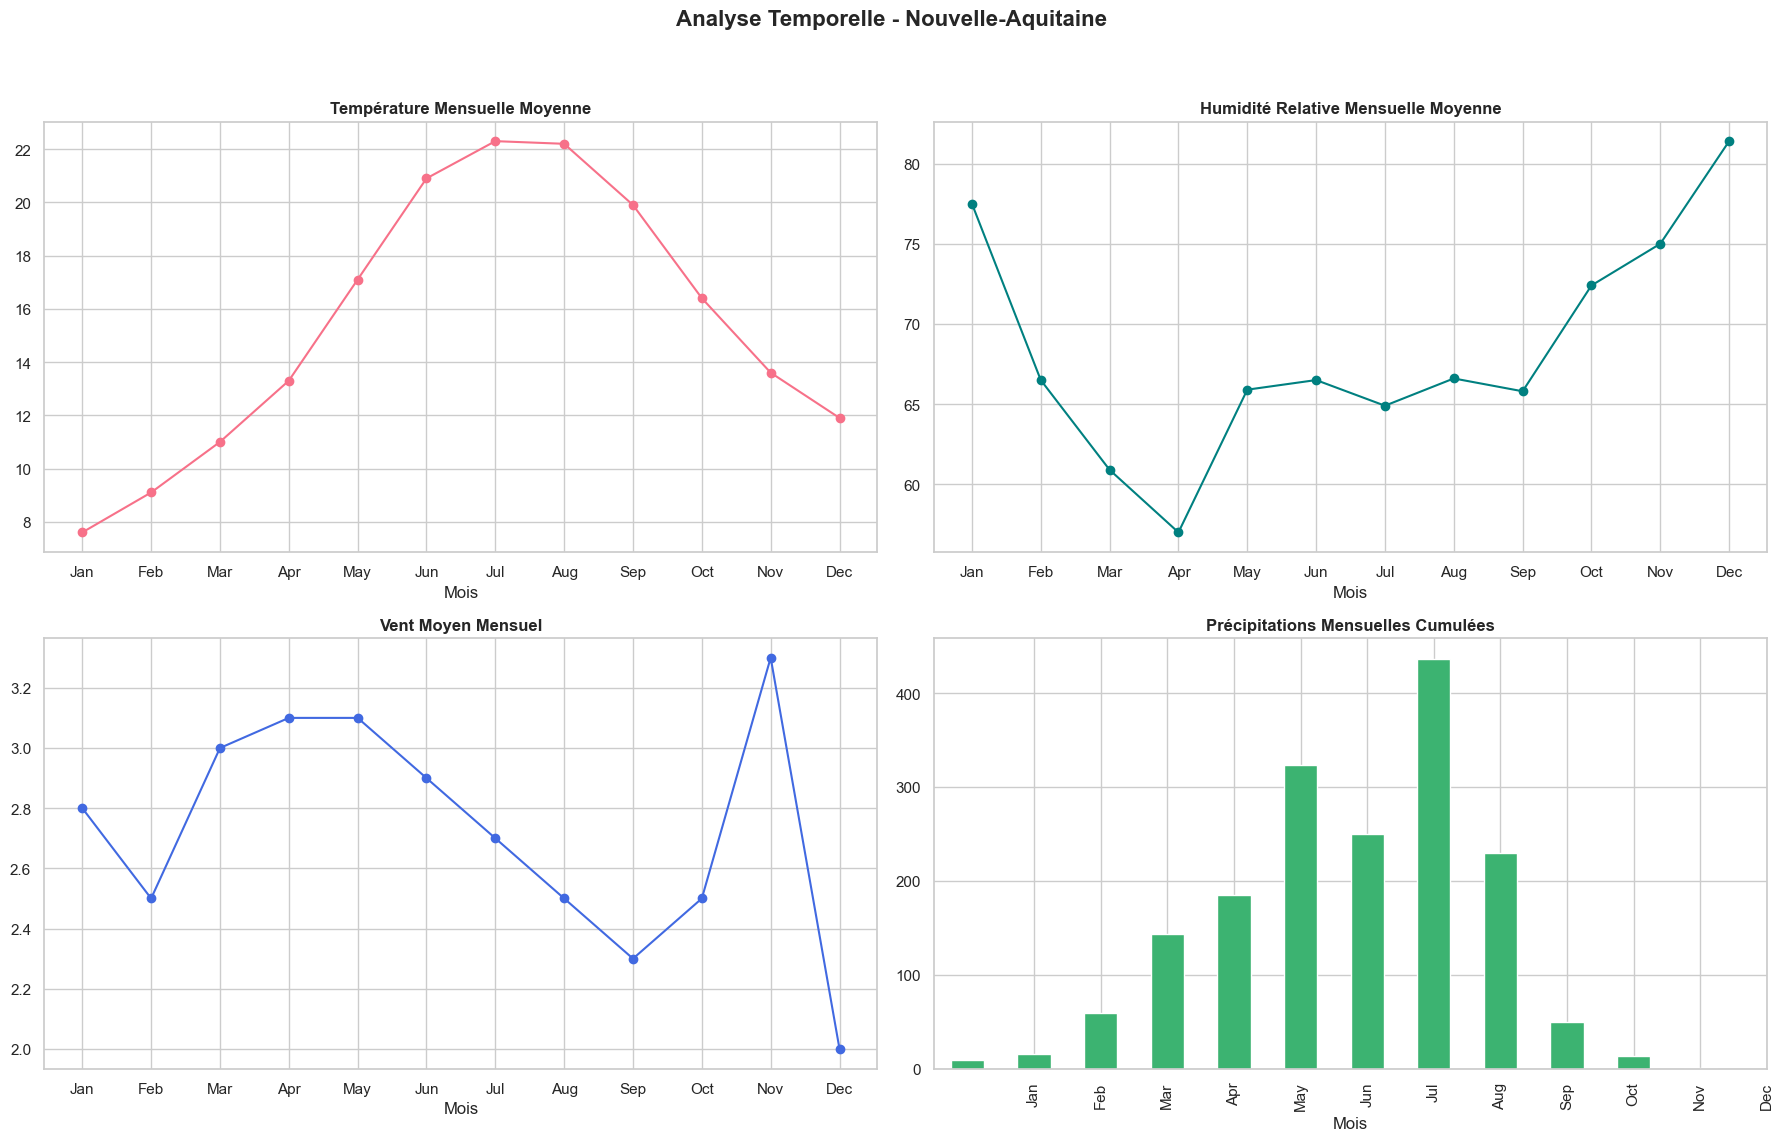


Résultats Nouvelle-Aquitaine:
      temperature_air_c  humidite_relative_pourcent  vent_moyen_10m_m_s  \
mois                                                                      
1                   7.6                        77.5                 2.8   
2                   9.1                        66.5                 2.5   
3                  11.0                        60.9                 3.0   
4                  13.3                        57.0                 3.1   
5                  17.1                        65.9                 3.1   
6                  20.9                        66.5                 2.9   
7                  22.3                        64.9                 2.7   
8                  22.2                        66.6                 2.5   
9                  19.9                        65.8                 2.3   
10                 16.4                        72.4                 2.5   
11                 13.6                        75.0                 3

In [74]:
print("\n" + "="*50)
print(" ANALYSE TEMPORALITE POUR LA RÉGION NOUVELLE-AQUITAINE ".center(50, "="))
print("="*50)   
resultats_temp_na, fig_temp_na = analyser_temporalite(df_na_filtre, "Nouvelle-Aquitaine")
# Affichage des résultats
print("\nRésultats Nouvelle-Aquitaine:")
print(resultats_temp_na["saisonnalite_mensuelle"])

L'analyse temporelle des variables météorologiques en Nouvelle-Aquitaine révèle un profil de risque incendie plus complexe et nuancé que celui de la PACA. Le danger n'est pas tant le fruit d'une sécheresse extrême et prolongée que d'un alignement défavorable de plusieurs facteurs durant une saison estivale bien définie.

#### **a. Une Fenêtre de Risque Estivale Clairement Identifiée**

Malgré un climat globalement plus humide, les graphiques montrent une convergence de facteurs aggravants durant les mois d'été, principalement de juin à septembre :

#### **Pic de Température**
- La courbe des températures atteint son plateau le plus élevé de juin à août, avec des moyennes dépassant les 20°C (pic à 22.3°C en juillet).
- Cette chaleur soutenue est le premier facteur qui stresse la végétation.

#### **Creux Relatif d'Humidité**
- Bien que l'humidité reste plus élevée qu'en PACA, elle atteint son point le plus bas de l'année au printemps et en été.
- Creux marqué en avril (57.0%) et des valeurs basses persistantes de juin à septembre. 
- L'air est donc plus sec durant la période la plus chaude.

#### **Baisse du Vent**
- Fait notable, le vent moyen est à son plus bas niveau durant la fin de l'été (creux en septembre à 2.3 m/s).
- Cela suggère que le vent n'est pas le moteur principal du risque comme en PACA, mais peut agir comme un accélérateur ponctuel lors d'épisodes spécifiques.

#### **b. Le Paradoxe des Précipitations Estivales**

Le graphique des précipitations cumulées présente un pic surprenant en été, notamment en août. Ce constat, qui semble contradictoire avec un risque incendie élevé, peut s'expliquer de plusieurs manières :

#### **Nature des Pluies**
- Il s'agit probablement d'orages d'été, qui déversent de grandes quantités d'eau en peu de temps.
- Ces pluies intenses ruissellent plus qu'elles ne pénètrent les sols et ne suffisent pas à ré-humecter durablement la végétation entre deux périodes chaudes.

#### **Artefact de Données**
- Il est possible que la collecte de données soit plus intensive durant les mois à risque, biaisant ainsi le cumul.

Quoi qu'il en soit, ces pluies estivales ne semblent pas suffisantes pour enrayer le processus d'assèchement de la végétation fine (herbes, aiguilles de pin), qui est très réactive à la chaleur et au vent.

#### **c. Implications pour la Modélisation et la Prévention**

Le risque incendie en Nouvelle-Aquitaine est le résultat d'un équilibre précaire. La modélisation doit se concentrer sur la détection des "fenêtres de tir" où les conditions deviennent critiques :

- **Le cœur du danger** se situe de juin à septembre, lorsque la chaleur est maximale.
- Le risque est moins lié à une sécheresse de fond qu'à l'évapotranspiration : même avec un sol humide, la chaleur peut "pomper" l'eau de la végétation et la rendre inflammable.
- La surveillance doit se focaliser sur les périodes de plusieurs jours consécutifs sans pluie combinées à de fortes chaleurs, qui sont les moments les plus propices aux départs de feu.

#### **Conclusion**

La saisonnalité en Nouvelle-Aquitaine définit une période de risque estival claire. Le danger y est plus subtil qu'en PACA, résultant d'une interaction complexe entre une chaleur soutenue, une baisse relative de l'humidité et la réactivité du combustible végétal, même en présence de précipitations estivales.

---

### **16. Analyse des Corrélations entre Variables Météorologiques**
Cette section vise à étudier les relations linéaires entre les différentes variables météorologiques mesurées lors des incendies, afin d’identifier des patterns redondants, des dépendances ou des groupes de variables fortement corrélées.

**Objectif :**
Explorer les corrélations entre variables climatiques significatives (excluant les identifiants et variables temporelles).

**Paramètres :**
- **meteo_df (pd.DataFrame)** : Données météorologiques associées aux incendies.
- **nom_region (str)** : Nom de la région analysée (ex. "PACA" ou "Nouvelle-Aquitaine").

**Étapes de traitement :**
- Sélection automatique des variables numériques pertinentes (au moins deux modalités différentes).
- Calcul de la matrice de corrélation de Pearson entre ces variables.
- Affichage d’une carte thermique annotée (heatmap) pour faciliter la lecture des dépendances.

**Variables exclues automatiquement :**
- Identifiants (id_incendie)
- Variables temporelles (annee, mois, heure, jour_semaine)

**Sorties :**
- **matrice_de_correlation (pd.DataFrame)** : Tableau des coefficients de corrélation arrondis.
- **fig (matplotlib.Figure)** : Carte thermique des corrélations, sauvegardée automatiquement.

In [75]:
def analyser_correlations(meteo_df: pd.DataFrame, nom_region: str) -> Tuple[Dict[str, pd.DataFrame], plt.Figure]:
    """Analyse des corrélations avec sélection automatique des variables."""
    variables_corr = meteo_df.select_dtypes(include=np.number).columns.tolist()
    vars_to_exclude = ['id_incendie', 'annee', 'mois', 'heure', 'jour_semaine']
    variables_corr = [v for v in variables_corr if v not in vars_to_exclude and meteo_df[v].nunique() > 1]
    
    corr_matrix = meteo_df[variables_corr].corr().round(2)
    
    fig = plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, vmin=-1, vmax=1, annot_kws={"size": 8})
    plt.title(f"Analyse des Corrélations - {nom_region}", fontweight="bold")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    sauvegarder_figure(fig, f"analyse_correlations_{nom_region.lower()}", nom_region, show=True)
        
    return {"matrice_de_correlation": corr_matrix}, fig

### **16. Analyse des Corrélations entre Variables Météorologiques de la Provence-Alpes-Côte d’Azur**


==== ANALYSE CORRELATIONS POUR LA RÉGION PACA=====


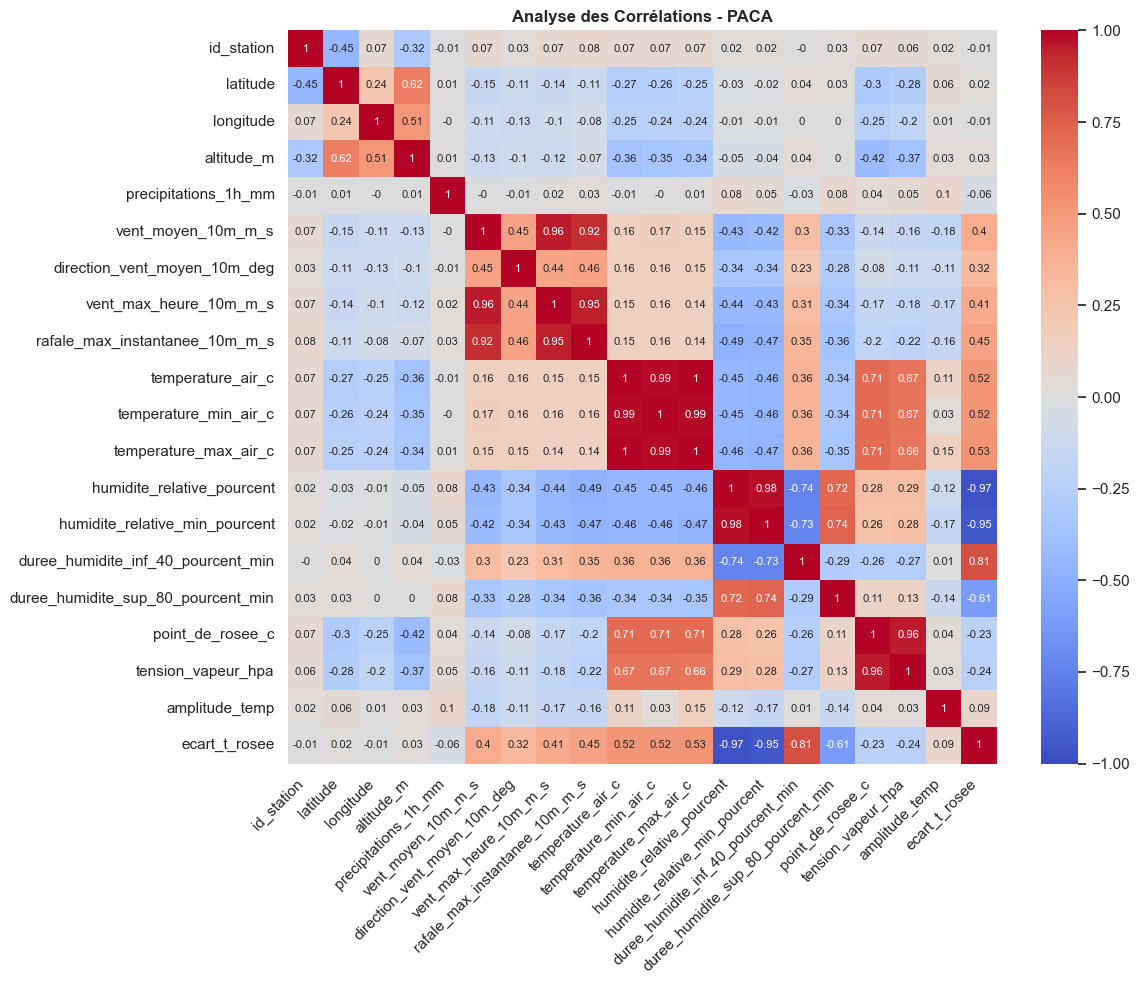


Résultats PACA:
                                    id_station  latitude  longitude  \
id_station                                 1.0      -0.5        0.1   
latitude                                  -0.5       1.0        0.2   
longitude                                  0.1       0.2        1.0   
altitude_m                                -0.3       0.6        0.5   
precipitations_1h_mm                      -0.0       0.0       -0.0   
vent_moyen_10m_m_s                         0.1      -0.1       -0.1   
direction_vent_moyen_10m_deg               0.0      -0.1       -0.1   
vent_max_heure_10m_m_s                     0.1      -0.1       -0.1   
rafale_max_instantanee_10m_m_s             0.1      -0.1       -0.1   
temperature_air_c                          0.1      -0.3       -0.2   
temperature_min_air_c                      0.1      -0.3       -0.2   
temperature_max_air_c                      0.1      -0.2       -0.2   
humidite_relative_pourcent                 0.0      -0.0    

In [76]:
# Application aux deux régions
print("\n" + "="*50)
print(" ANALYSE CORRELATIONS POUR LA RÉGION PACA".center(50, "="))
print("="*50)     
resultats_corr_paca, fig_corr_paca = analyser_correlations(df_paca_filtre, "PACA")
# Affichage des résultats
print("\nRésultats PACA:")
print(resultats_corr_paca["matrice_de_correlation"])

Une matrice de corrélation met en lumière les relations intrinsèques entre les différentes variables météorologiques, révélant des "synergies" et des oppositions qui sont au cœur de la dynamique du risque incendie. Elle permet de confirmer visuellement les liens physiques entre les paramètres et d'identifier les redondances potentielles pour la modélisation.

#### **a. Le Bloc "Chaleur" : une Forte Interdépendance**

Le carré rouge vif au centre de la matrice est sans équivoque. Il montre une corrélation quasi parfaite (proche de +1.0) entre :
- **temperature_air_c**
- **temperature_min_air_c**
- **temperature_max_air_c**

C'est une relation attendue, mais elle confirme que ces trois variables mesurent essentiellement la même chose. Pour un modèle de machine learning, il sera crucial de n'en conserver qu'une seule (probablement **temperature_air_c** ou **temperature_max_air_c**) pour éviter la multicolinéarité, qui peut fausser l'interprétation des résultats.

#### **b. Le Bloc "Vent" : une Famille Cohérente**

Un autre carré rouge très marqué lie les variables de vent :
- **vent_moyen_10m_m_s**
- **vent_max_heure_10m_m_s**
- **rafale_max_instantanee_10m_m_s**

Les corrélations sont très fortes (ex : +0.92 entre vent moyen et rafale). Cela indique que lorsque le vent moyen est fort, les rafales le sont aussi. Comme pour la température, ces variables sont très redondantes. **rafale_max_instantanee_10m_m_s** pourrait être la plus pertinente à conserver car elle représente le danger maximal.

#### **c. La Relation Inverse Fondamentale : Température vs. Humidité**

La matrice met en évidence la relation physique la plus importante pour le risque incendie : la corrélation négative forte entre la température et l'humidité :
- **temperature_air_c vs humidite_relative_pourcent** : -0.45

Cette corrélation est encore plus visible avec **ecart_t_rosee**, qui est une mesure directe de la sécheresse de l'air. On observe une corrélation positive forte entre la température et cet écart (+0.52). 

En clair : plus il fait chaud, plus l'air est sec. C'est cette synergie négative qui crée les conditions les plus dangereuses.

#### **d. L'Influence du Vent sur la Sécheresse**

Le vent joue également un rôle dans l'assèchement de l'air. On observe des corrélations négatives modérées entre le vent et l'humidité :
- **rafale_max_instantanee_10m_m_s vs humidite_relative_pourcent** : -0.49

Cette relation est confirmée par la corrélation positive entre les rafales et l'écart température/point de rosée (+0.45). Cela signifie que les jours de grand vent sont aussi, en général, des jours où l'air est plus sec, ce qui amplifie considérablement le risque de propagation.

#### **e. Implications pour la Modélisation (Feature Engineering & Selection)**

#### Redondance
Il faudra impérativement sélectionner un sous-ensemble de variables pour éviter la redondance. Par exemple, garder **temperature_max_air_c**, **rafale_max_instantanee_10m_m_s**, et **ecart_t_rosee** pourrait être une stratégie pertinente pour capturer l'essentiel du danger sans surcharger le modèle.

#### Variables Synthétiques
La corrélation parfaite (-0.97) entre **humidite_relative_pourcent** et **ecart_t_rosee** montre que ces deux variables sont presque des miroirs l'une de l'autre. **ecart_t_rosee** est souvent un meilleur prédicteur car il combine l'effet de la température et de l'humidité en une seule métrique.

#### Confirmation des Hypothèses
Cette matrice valide empiriquement les connaissances physiques sur le risque incendie : le danger est maximal lorsque chaleur, air sec et vent se combinent.

#### Conclusion

En conclusion, cette analyse de corrélation est une étape cruciale. Elle ne se contente pas de montrer des chiffres, elle révèle la "mécanique" du climat local et fournit des indications précieuses pour construire un modèle de prédiction du risque incendie qui soit à la fois simple, robuste et performant.

### **16. Analyse des Corrélations entre Variables Météorologiques de la Nouvelle-Aquitaine**


 ANALYSE CORRELATIONS POUR LA RÉGION NOUVELLE-AQUITAINE


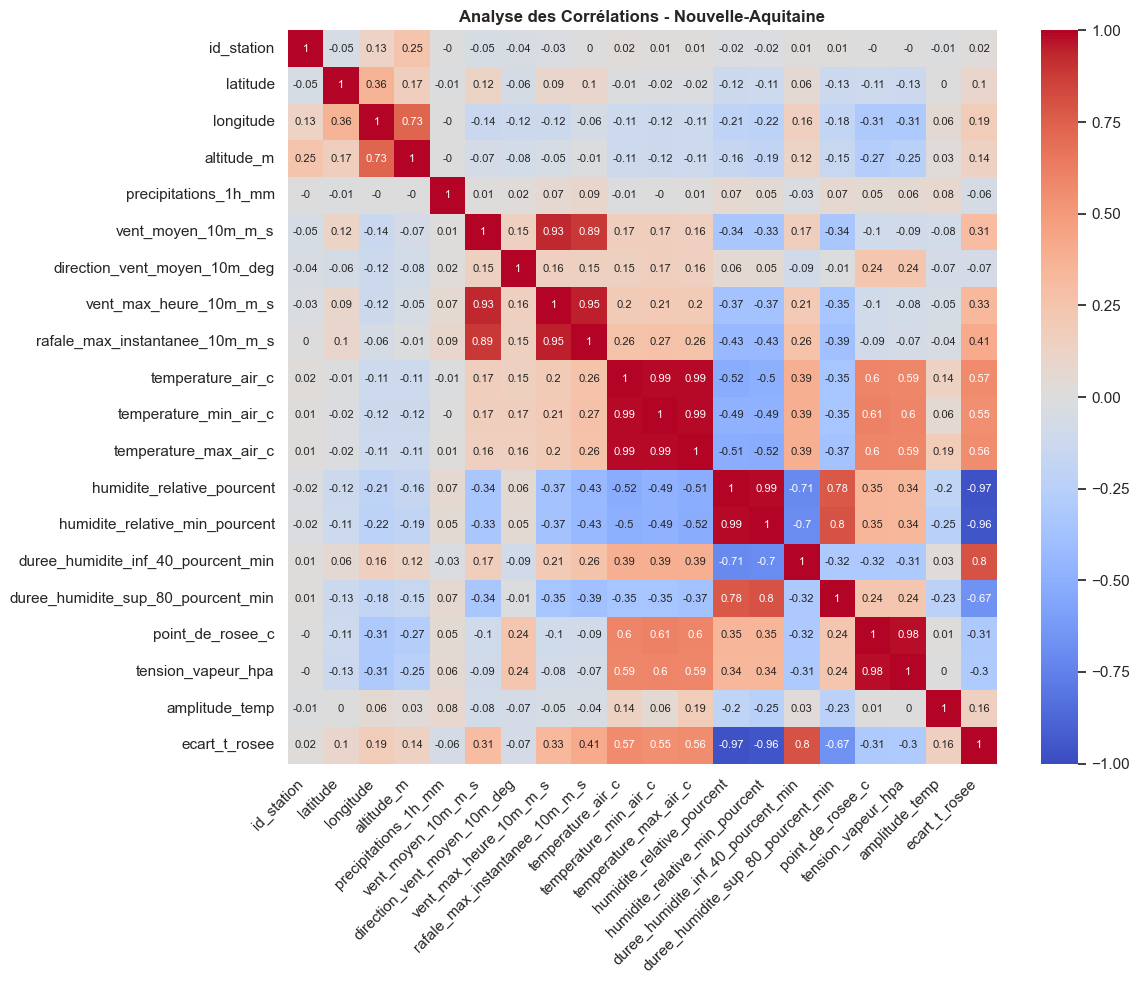


Résultats Nouvelle-Aquitaine:
                                    id_station  latitude  longitude  \
id_station                                 1.0      -0.1        0.1   
latitude                                  -0.1       1.0        0.4   
longitude                                  0.1       0.4        1.0   
altitude_m                                 0.2       0.2        0.7   
precipitations_1h_mm                      -0.0      -0.0       -0.0   
vent_moyen_10m_m_s                        -0.1       0.1       -0.1   
direction_vent_moyen_10m_deg              -0.0      -0.1       -0.1   
vent_max_heure_10m_m_s                    -0.0       0.1       -0.1   
rafale_max_instantanee_10m_m_s             0.0       0.1       -0.1   
temperature_air_c                          0.0      -0.0       -0.1   
temperature_min_air_c                      0.0      -0.0       -0.1   
temperature_max_air_c                      0.0      -0.0       -0.1   
humidite_relative_pourcent                -0.0

In [77]:
# Application aux deux régions
print("\n" + "="*50)
print(" ANALYSE CORRELATIONS POUR LA RÉGION NOUVELLE-AQUITAINE".center(50, "="))
print("="*50)     
resultats_corr_na, fig_corr_na = analyser_correlations(df_na_filtre, "Nouvelle-Aquitaine")
# Affichage des résultats
print("\nRésultats Nouvelle-Aquitaine:")
print(resultats_corr_na["matrice_de_correlation"])

La matrice de corrélation pour la Nouvelle-Aquitaine confirme que les relations physiques fondamentales entre les variables météorologiques sont universelles, tout en révélant des nuances propres au climat de la région. Elle est essentielle pour comprendre les interactions qui façonnent le risque incendie et pour guider la sélection de variables pertinentes pour la modélisation.

#### **1. Identification des Blocs de Variables Redondantes**

Comme pour la région PACA, la matrice met clairement en évidence des groupes de variables très fortement corrélées entre elles, indiquant une forte redondance :

#### **Le Bloc "Chaleur"**
Les corrélations entre :
- **temperature_air_c**
- **temperature_min_air_c**
- **temperature_max_air_c**

sont quasi parfaites (+0.99). Ces variables sont interchangeables d'un point de vue statistique.

#### **Le Bloc "Vent"**
Les variables suivantes sont également très liées :
- **vent_moyen_10m_m_s**
- **vent_max_heure_10m_m_s**
- **rafale_max_instantanee_10m_m_s**

avec des corrélations allant jusqu'à +0.95. La vitesse du vent, qu'elle soit moyenne ou en rafale, décrit un phénomène cohérent.

#### **Le Bloc "Humidité"**
Les variables :
- **humidite_relative_pourcent**
- **humidite_relative_min_pourcent**

sont presque identiques (+0.99). De même, **point_de_rosee_c** et **tension_vapeur_hpa** sont parfaitement corrélés (+1.0).

Ces blocs confirment la nécessité de sélectionner une seule variable représentative de chaque "famille" pour construire un modèle prédictif robuste et éviter les problèmes de multicolinéarité.

#### **2. La Relation Centrale : Chaleur vs. Sécheresse de l'Air**

La relation physique la plus critique pour le risque incendie est parfaitement illustrée :
- On observe une corrélation négative nette entre la température et l'humidité : 
  - **temperature_air_c vs humidite_relative_pourcent : -0.52**.

Cette relation est magnifiée par la corrélation positive forte entre la température et l'écart température/point de rosée :
- **temperature_air_c vs ecart_t_rosee : +0.57**.

Le message est clair et identique à celui de la PACA : quand la température monte, l'air s'assèche. C'est cette synergie qui crée les conditions les plus favorables aux incendies. La corrélation quasi parfaite (-0.97) entre **humidite_relative_pourcent** et **ecart_t_rosee** confirme que ce dernier est un excellent indicateur synthétique de la sécheresse de l'air.

#### **3. L'Effet Modéré mais Réel du Vent**

En Nouvelle-Aquitaine, l'effet du vent sur l'assèchement de l'air est également visible, bien que légèrement moins marqué qu'en PACA :
- **rafale_max_instantanee_10m_m_s vs humidite_relative_pourcent : -0.43**.
- **rafale_max_instantanee_10m_m_s vs ecart_t_rosee : +0.41**.

Ces corrélations confirment que les jours de vent tendent à être plus secs, ajoutant une dimension supplémentaire au risque, même si le vent n'est pas un moteur aussi dominant qu'en PACA.

#### **4. Implications et Conclusion**

Cette analyse de corrélation pour la Nouvelle-Aquitaine est cruciale. Elle démontre que, malgré un climat globalement plus humide, les mécanismes physiques qui régissent le risque incendie sont les mêmes qu'en climat méditerranéen. La chaleur assèche l'air, et le vent amplifie ce phénomène.

#### Pour la Modélisation, les Conclusions Sont Claires :
- Il est impératif de simplifier le modèle en choisissant une variable par bloc (ex : **temperature_max_air_c**, **rafale_max_instantanee_10m_m_s**, **ecart_t_rosee**).
- Les variables synthétiques comme **ecart_t_rosee** sont des candidates de choix car elles capturent une information riche (combinant température et humidité).
- La matrice valide l'approche consistant à se concentrer sur l'interaction entre ces trois piliers du risque : chaleur, sécheresse de l'air et vent.

En somme, cette analyse fournit une "carte routière" pour la construction d'un modèle de risque incendie pertinent et efficace pour la Nouvelle-Aquitaine.

---

### **17. Comparaison Globale entre Régions**
Cette fonction permet de comparer les distributions des variables climatiques principales entre deux régions d’étude. Elle met en lumière les différences structurelles sur la température, l’humidité et le vent.

**Objectif :** Visualiser et comparer les distributions statistiques des conditions météorologiques entre deux régions.

**Paramètres :**
- **df1 (pd.DataFrame)** : Données météo pour la première région.
- **nom1 (str)** : Nom de la première région.
- **df2 (pd.DataFrame)** : Données météo pour la seconde région.
- **nom2 (str)** : Nom de la seconde région.

**Méthode :**
- Concaténation des jeux de données avec une étiquette région.
- Visualisation via **boxplots** pour :
    - Température de l’air (°C)
    - Humidité relative (%)
    - Vent moyen (m/s)
- Calcul de **statistiques descriptives** (moyenne, min, max, écart-type, etc.) par région.

**Sorties :**
- **statistiques_comparatives (dict[str, pd.DataFrame])** : Statistiques descriptives par région.
- **fig (matplotlib.Figure)** : Graphique comparatif des distributions sauvegardé dans /comparaison_PACA_vs_Nouvelle-Aquitaine/.

In [78]:
def comparer_regions(df1: pd.DataFrame, nom1: str, df2: pd.DataFrame, nom2: str) -> Tuple[Dict[str, pd.DataFrame], plt.Figure]:
    """Comparaison des distributions entre deux régions."""
    vars_to_compare = ["temperature_air_c", "humidite_relative_pourcent", "vent_moyen_10m_m_s"]
    
    combined_df = pd.concat([
        df1[vars_to_compare].assign(region=nom1),
        df2[vars_to_compare].assign(region=nom2)
    ], ignore_index=True)
    
    stats_df = combined_df.groupby('region')[vars_to_compare].describe().T.round(1)
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle(f"Comparaison Globale : {nom1.upper()} vs {nom2.upper()}", fontweight="bold")
    
    sns.boxplot(data=combined_df, x='region', y='temperature_air_c', ax=axes[0], palette="Reds").set_title("Température (°C)")
    sns.boxplot(data=combined_df, x='region', y='humidite_relative_pourcent', ax=axes[1], palette="Blues").set_title("Humidité Relative (%)")
    sns.boxplot(data=combined_df, x='region', y='vent_moyen_10m_m_s', ax=axes[2], palette="Greens").set_title("Vent Moyen (m/s)")
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Sauvegarde dans un dossier spécial pour les comparaisons
    comp_dir = os.path.join(OUTPUT_DIR, "comparaison_PACA_vs_Nouvelle-Aquitaine")
    os.makedirs(comp_dir, exist_ok=True)
    fig.savefig(os.path.join(comp_dir, "comparaison_globale.png"), bbox_inches='tight', dpi=300)
        
    return {"statistiques_comparatives": stats_df}, fig

### **18. Comparaison des Tendances Mensuelles**
Cette fonction compare les profils climatiques mensuels moyens entre deux régions à travers 4 indicateurs clefs.

**Objectif :** Visualiser les variations mensuelles moyennes entre deux régions pour mieux identifier les écarts de saisonnalité.

**Paramètres :**
- **df1, df2 (pd.DataFrame) :** Données météorologiques des deux régions.
- **nom1, nom2 (str) :** Noms des régions comparées.

**Variables analysées :**
- Température moyenne de l’air (temperature_air_c)
- Humidité relative moyenne (humidite_relative_pourcent)
- Vent moyen (vent_moyen_10m_m_s)
- Précipitations horaires cumulées (precipitations_1h_mm)

**Méthode :**
- Agrégation par mois pour chaque variable et chaque région.
- Tracé de courbes comparatives avec des couleurs distinctes.
- Export du graphique dans /comparaison_PACA_vs_Nouvelle-Aquitaine/.

**Sorties :**
- **donnees_mensuelles (pd.DataFrame) :** Tableau des valeurs moyennes mensuelles pour chaque variable.
- **fig_mensuel (matplotlib.Figure) :** Figure comparative des tendances mensuelles.

In [79]:
def comparer_tendances_mensuelles(df1: pd.DataFrame, nom1: str, df2: pd.DataFrame, nom2: str) -> Tuple[Dict[str, pd.DataFrame], plt.Figure]:
    """Compare les tendances mensuelles entre deux régions"""
    results = {"donnees_mensuelles": pd.DataFrame()}
    
    # Variables à comparer
    vars_comparaison = {
        "temperature_air_c": ("Température (°C)", "crimson", "royalblue"),
        "humidite_relative_pourcent": ("Humidité (%)", "teal", "mediumaquamarine"),
        "vent_moyen_10m_m_s": ("Vent (m/s)", "royalblue", "cornflowerblue"),
        "precipitations_1h_mm": ("Précipitations (mm)", "mediumseagreen", "mediumturquoise")
    }
    
    # DataFrame pour stocker les résultats
    df_comparaison = pd.DataFrame()
    
    # Création des graphiques
    fig_mensuel, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig_mensuel.suptitle(f"Comparaison mensuelle {nom1} vs {nom2}", fontweight="bold")
    axes = axes.flatten()
    
    for i, (var, (titre, couleur1, couleur2)) in enumerate(vars_comparaison.items()):
        if var in df1.columns and var in df2.columns:
            ax = axes[i]
            
            # Calcul des moyennes mensuelles
            df1_group = df1.groupby("mois")[var].mean().rename(f"{nom1}_{var}")
            df2_group = df2.groupby("mois")[var].mean().rename(f"{nom2}_{var}")
            
            # Stockage des données
            if df_comparaison.empty:
                df_comparaison = pd.concat([df1_group, df2_group], axis=1)
            else:
                df_comparaison = pd.concat([df_comparaison, df1_group, df2_group], axis=1)
            
            # Tracé des courbes
            sns.lineplot(data=df1_group, label=nom1, marker='o', color=couleur1, ax=ax)
            sns.lineplot(data=df2_group, label=nom2, marker='o', color=couleur2, ax=ax)
            
            ax.set_title(titre)
            ax.set_xlabel("Mois")
            ax.set_xticks(range(1, 13))
            ax.set_xticklabels([calendar.month_abbr[i] for i in range(1, 13)])
            ax.grid(True)
            ax.legend()
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Ajout des données mensuelles aux résultats
    results["donnees_mensuelles"] = df_comparaison.round(2)
    
    # Sauvegarde dans un dossier spécial pour les comparaisons
    comp_dir = os.path.join(OUTPUT_DIR, "comparaison_PACA_vs_Nouvelle-Aquitaine")
    os.makedirs(comp_dir, exist_ok=True)
    fig_mensuel.savefig(os.path.join(comp_dir, "comparaison_mensuelle.png"), bbox_inches='tight', dpi=300)
    
    return results, fig_mensuel


============== COMPARAISON REGIONS ===============

Statistiques comparatives:
region                            Nouvelle-Aquitaine     PACA
temperature_air_c          count             52454.0 104864.0
                           mean                 17.9     18.2
                           std                   7.5      8.7
                           min                  -8.4    -11.3
                           25%                  13.0     12.4
                           50%                  18.2     19.1
                           75%                  22.9     24.7
                           max                  42.8     43.4
humidite_relative_pourcent count             31903.0  75704.0
                           mean                 64.3     56.4
                           std                  21.9     20.5
                           min                   7.0      6.0
                           25%                  47.0     40.0
                           50%                  65.0

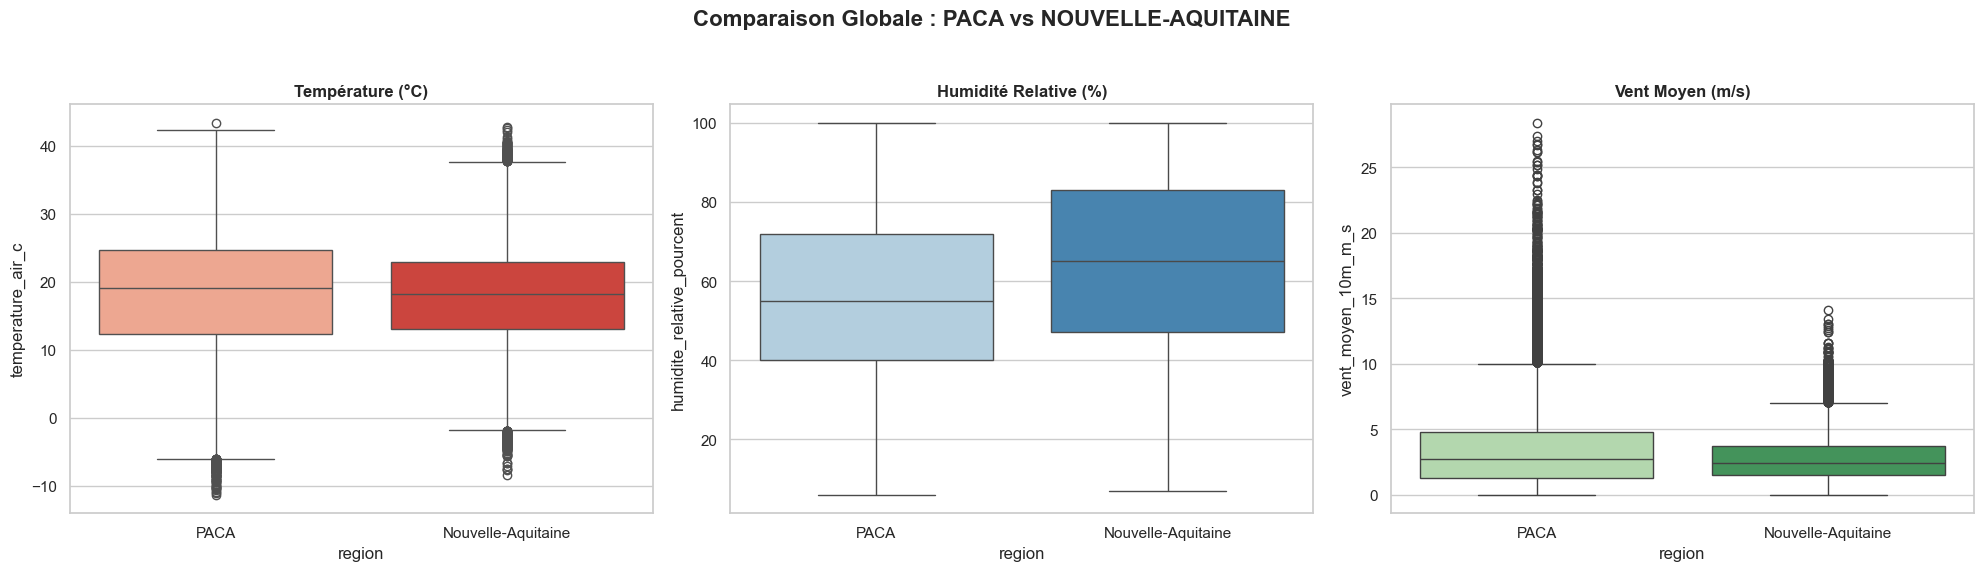

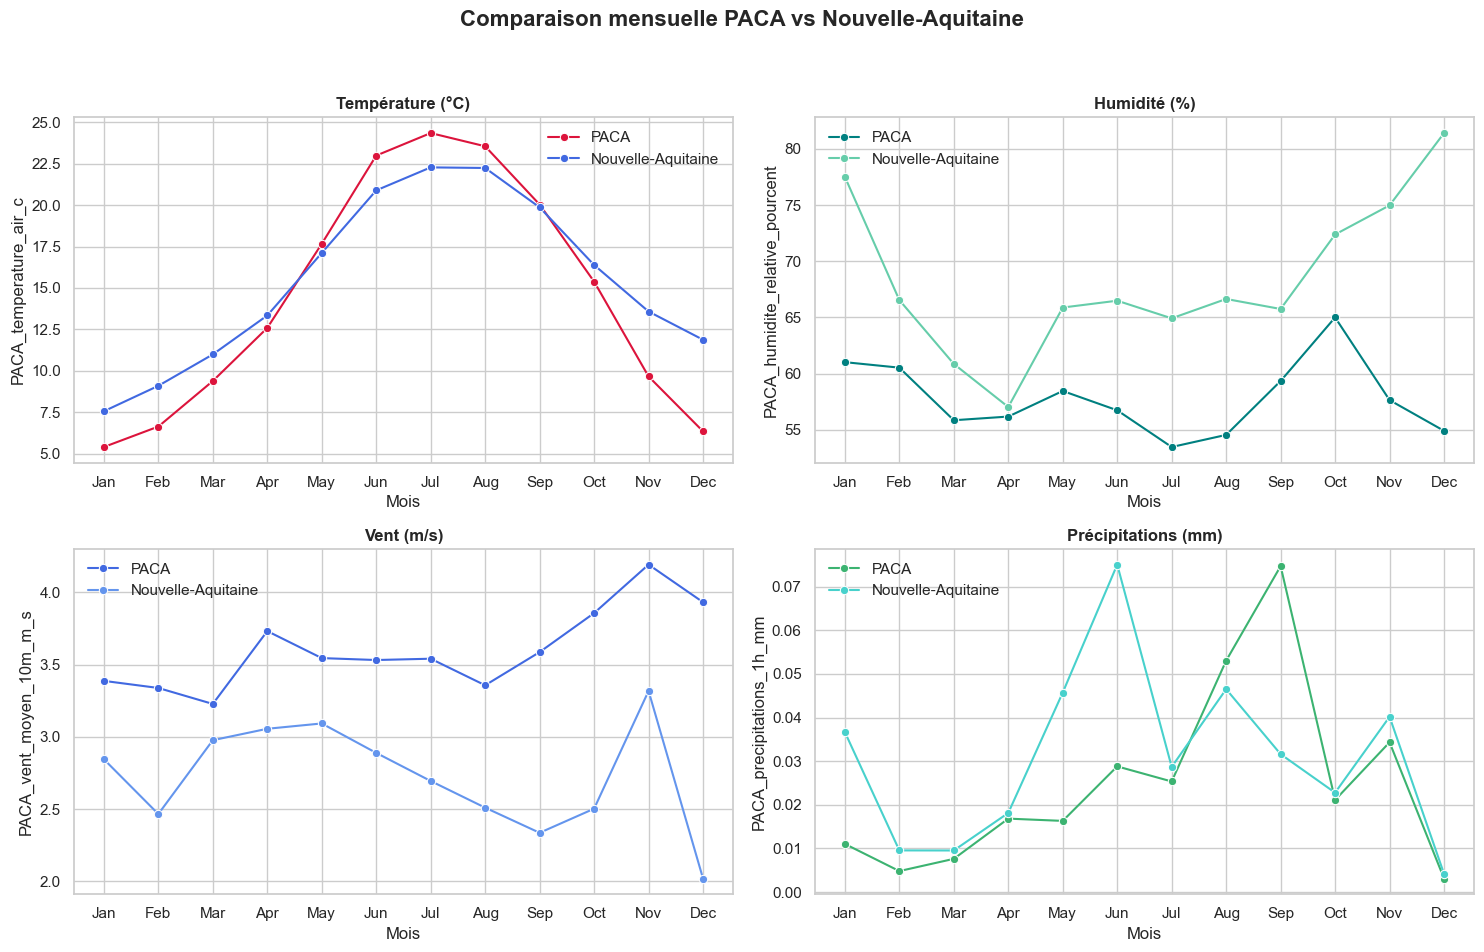

In [80]:
# Application de la comparaison
print("\n" + "="*50)
print(" COMPARAISON REGIONS ".center(50, "="))
print("="*50)       

resultats_comparaison, fig_comparaison = comparer_regions(df_paca_filtre, "PACA", df_na_filtre, "Nouvelle-Aquitaine")
resultats_mensuel, fig_mensuel = comparer_tendances_mensuelles(df_paca_filtre, "PACA", df_na_filtre, "Nouvelle-Aquitaine")

# Affichage des résultats
print("\nStatistiques comparatives:")
print(resultats_comparaison["statistiques_comparatives"])
print("\nDonnées mensuelles comparées:")
print(resultats_mensuel["donnees_mensuelles"])

La comparaison directe des profils météorologiques des régions PACA et Nouvelle-Aquitaine met en évidence deux "signatures" climatiques distinctes, qui expliquent la nature et la saisonnalité différentes de leur risque incendie respectif.

#### **a. Synthèse Globale : Deux Profils de Risque Contrastés**

Les graphiques de comparaison globale (boxplots) dressent un portrait immédiat et clair :

#### **Température**
- Les deux régions présentent des températures moyennes similaires.
- **PACA** affiche une plus grande variabilité et des extrêmes plus marqués, à la fois chauds et froids.

#### **Humidité**
- La différence la plus nette. 
- **Nouvelle-Aquitaine** est structurellement plus humide, avec une médiane et des quartiles significativement plus élevés que **PACA**, qui se caractérise par un air beaucoup plus sec.

#### **Vent**
- Le régime de vent en **PACA** est nettement plus soutenu et surtout plus extrême.
- La boîte à moustaches est plus haute et le nombre de valeurs extrêmes (rafales) est bien plus important qu'en **Nouvelle-Aquitaine**.

**En résumé :** 
- **PACA** se définit par un climat de contrastes et d'extrêmes (très chaud/froid, très sec, très venteux).
- **Nouvelle-Aquitaine** présente un profil plus tempéré et humide, mais capable d'atteindre des chaleurs estivales significatives.

#### **b. Analyse des Tendances Saisonnières : La Convergence des Dangers**

La comparaison des tendances mensuelles affine cette analyse et révèle pourquoi le risque est si différent.

#### **Température**
- Le chassé-croisé des courbes est très instructif. 
- **Nouvelle-Aquitaine** est plus douce en hiver, mais **PACA** devient nettement plus chaude au cœur de l'été (juin-août), au moment le plus critique pour les incendies.

#### **Humidité**
- Les deux courbes sont presque des images en miroir.
- L'humidité en **Nouvelle-Aquitaine** reste constamment 10 à 20 points au-dessus de celle de **PACA**. 
- En été, lorsque **PACA** atteint son minimum de sécheresse (53.5% en juillet), **Nouvelle-Aquitaine** reste à un niveau beaucoup plus élevé (autour de 65%).

#### **Vent**
- **PACA** subit un vent moyen supérieur tout au long de l'année, avec des pics notables au printemps et en automne.
- **Nouvelle-Aquitaine** a un régime de vent plus faible, atteignant son minimum en fin d'été, au moment où le risque est pourtant présent.

#### **c. Conclusion : Deux Mécanismes de Risque Distincts**

Cette comparaison permet de conclure sur deux mécanismes de risque incendie fondamentalement différents :

#### **Risque en PACA**
- **Risque de synergie extrême**
- Alimenté par la convergence en été de trois facteurs critiques : 
  - Des températures très élevées
  - Une sécheresse de l'air très marquée
  - Un vent fort et constant.
  
C'est un risque "agressif", où les conditions sont ouvertement hostiles.

#### **Risque en Nouvelle-Aquitaine**
- **Risque d'équilibre rompu**
- Survient dans un climat globalement moins hostile.
- Le danger naît lorsque la chaleur estivale parvient, malgré une humidité ambiante plus forte, à assécher suffisamment la végétation (particulièrement réactive comme les pins) pour la rendre inflammable.

Le risque y est plus subtil, dépendant de l'équilibre précaire entre la chaleur et l'humidité résiduelle.

**Cette distinction est fondamentale pour la modélisation et la prévention.** Les indicateurs de danger et les stratégies de lutte doivent être adaptés à ces deux profils climatiques spécifiques.